# Predicting voting behavior using psychology

## Setting

In [1]:
# utility
import os
from copy import deepcopy
import warnings

# data handling
import pandas as pd
import numpy as np
import missingno as msno

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats
import pingouin as pg

# modeling
import sklearn
import tensorflow as tf

# plotting setting
from IPython.core.display import display, HTML
from IPython.display import Image
plt.style.use('seaborn')  # plt.style.use('ggplot')
sns.set(font_scale=1.5)

plt.rc('font', family='AppleGothic') # For Windows
plt.rcParams['figure.figsize'] = [10, 5]
mpl.rcParams['axes.unicode_minus'] = False

%matplotlib inline

# ignore warnings
warnings.filterwarnings('ignore')

In [2]:
def outlier_check(df, method=1):

    if method == 1:  # Boxplot Method
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1-(IQR*1.5)
        upper = Q1+(IQR*1.5)

    elif method == 2:  # Normal Distribution Method
        Mean = df.mean()
        std = df.std()
        lower = Mean-std*3
        upper = Mean+std*3

    out_mask = ((df < lower) | (df > upper))
    out_info = pd.concat([pd.DataFrame(lower, columns=['lower']),
                          pd.DataFrame(upper, columns=['upper']),
                          pd.DataFrame(df.min(), columns=['min']),
                          pd.DataFrame(df.max(), columns=['max']),
                          pd.DataFrame(((df < lower) | (df > upper)).sum(), columns=['counts'])], axis=1)
    return out_info, out_mask

In [3]:
proj_dir=os.getcwd()
data_dir=(proj_dir +  '/data')
os.listdir(data_dir)

['train.csv', 'test_x.csv', 'sample_submission.csv']

## Data Preparation

### 변수 설명

* **index**
<br>

* **MAch-iv: Machiavellianism Test**
    * 1=Disagree, 2=Slightly disagree, 3=Neutral, 4=Slightly agree, 5=Agree.
    * Q_A / Q_E (a~t) 비식별화를 위해 일부 질문은 Secret 처리 (reverse coding 은 괄호에 표시)

    <br>    
   
    * QaA : Secret1 
    * QbA : The biggest difference between most criminals and other people is that the criminals are stupid enough to get caught. (+)(V)(11) 
    * QcA : Anyone who completely trusts anyone else is asking for trouble. (1)(T)(+)
    * QdA : Secret2  
    * QeA : P.T. Barnum was wrong when he said that there's a sucker born every minute. (13)(V)(-)
    * QfA : There is no excuse for lying to someone else. (19)(T)(-)
    * QgA : Secret3 
    * QhA : Most people forget more easily the death of their parents than the loss of their property.  (17)(V)(+)
    * QiA : Secret4 
    * QjA : It is safest to assume that all people have a vicious streak and it will come out when they are given a chance. (3)(V)(+)
    * QkA : All in all, it is better to be humble and honest than to be important and dishonest. (20)(M)(-)
    * QlA : Secret5 
    * QmA : It is hard to get ahead without cutting corners here and there. (7)(V)(+)
    * QnA : Secret6 
    * QoA : The best way to handle people is to tell them what they want to hear. (10)(T)(+)
    * QpA : Secret7 
    * QqA : Most people are basically good and kind. (14)(V)(-)
    * QrA : One should take action only when sure it is morally right. (4)(T)(-)
    * QsA : It is wise to flatter important people. (6)(T)(+)
    * QtA : Secret8
    
    <br>
    
    * Q_E(a~t) : 질문을 답할 때까지의 시간
    
    <br>
    
    * Secret Question
        * V-	2. Most people who get ahead in the world lead clean moral lives.
        * V+	5. Generally speaking, people won't work hard unless they're forced to do so.
        * M+	8. People suffering from incurable diseases should have the choice of being put painlessly to death.
        * V-	9. Most people are brave.
        * T-	12. Honesty is the best policy in all cases.
        * T-	15. When you ask someone to do something for you, it is best to give the real reasons for wanting it rather than giving reasons which might carry more weight.
        * T-	16. It is possible to be good in all respects.
        * T+	18. Never tell anyone the real reason you did something unless it is useful to do so.

<br>

* **Demographic characteristic**
    * age_group : 연령
    * education : 교육 수준
        * 1=Less than high school, 2=High school, 3=University degree, 4=Graduate degree, 0=무응답
    * engnat : 모국어가 영어
        * 1=Yes, 2=No, 0=무응답
    * familysize : 형제자매 수
    * gender : 성별
        * Male, Female
    * hand : 필기하는 손
        * 1=Right, 2=Left, 3=Both, 0=무응답
    * married : 혼인 상태
        * 1=Never married, 2=Currently married, 3=Previously married, 0=Other
    * race : 인종
        * Asian, Arab, Black, Indigenous Australian, Native American, White, Other
    * religion : 종교
        * Agnostic, Atheist, Buddhist, Christian_Catholic, Christian_Mormon, Christian_Protestant, Christian_Other, Hindu, Jewish, Muslim, Sikh, Other
    * urban : 유년기의 거주 구역
        * 1=Rural (country side), 2=Suburban, 3=Urban (town, city), 0=무응답        
        
<br>

* **Ten-Item Personality Inventory-(TIPI)** * 순서형 변수, Ocean Model (big 5)
    * tp__(01~07) : items were rated "I see myself as:" _____ such that
    * tp01 : Extraverted, enthusiastic. (E)(+)
    * tp02 : Critical, quarrelsome. (A)(-)
    * tp03 : Dependable, self-disciplined. (C)(+)
    * tp04 : Anxious, easily upset. (N)(-)
    * tp05 : Open to new experiences, complex. (O)(+)
    * tp06 : Reserved, quiet. (E)(-)
    * tp07 : Sympathetic, warm. (A)(+)
    * tp08 : Disorganized, careless. (C)(-)
    * tp09 : Calm, emotionally stable. (N)(+)
    * tp10 : Conventional, uncreative. (O)(-)
   
<br>

* **Others**						
    * wr_(01~13) : 실존하는 해당 단어의 정의을 앎
        * 1=Yes, 0=No
    * wf_(01~03) : 허구인 단어의 정의를 앎
        * 1=Yes, 0=No
        
<br>
        
* **Target (Voting Behavior)**
    * voted (타겟): 지난 해 국가 선거 투표 여부
        * 1=Yes, 2=No


### 데이터 로드

In [381]:
df_train_raw = pd.read_csv(('%s/train.csv' % (data_dir)), encoding='euc-kr')
df_test_raw = pd.read_csv(('%s/test_x.csv' % (data_dir)), encoding='euc-kr')
df_sample = pd.read_csv(('%s/sample_submission.csv' % (data_dir)), encoding='euc-kr')

* 주요 요인(Mach, TIPI, Demographic, others) 별로 feature를 재정렬한다.
* Mach, TIPi, 질문지 평정에서 reverse coding을 식별하고 점수 계산이 용이하도록 변환한다. 

In [382]:
mach_E_neg = ['QkE', 'QfE', 'QrE', 'QeE', 'QqE']
mach_E_T = ['QcE', 'QfE', 'QoE', 'QrE', 'QsE']
mach_E_V = ['QbE', 'QeE', 'QhE', 'QjE', 'QmE', 'QqE']
mach_E_M = ['QkE']
mach_E_na = ['QaE', 'QdE', 'QgE', 'QiE', 'QlE', 'QnE', 'QpE', 'QtE']

mach_A_neg = ['QkA','QfA','QrA','QeA','QqA']
mach_A_T=['QcA','QfA','QoA','QrA','QsA']
mach_A_V=['QbA','QeA','QhA','QjA','QmA','QqA']
mach_A_M=['QkA']
mach_A_na=['QaA','QdA','QgA','QiA','QlA','QnA','QpA','QtA']

tipi_neg = ['tp02', 'tp04', 'tp06', 'tp08', 'tp10']
tipi_O = ['tp05', 'tp10']
tipi_C = ['tp03', 'tp08']
tipi_E = ['tp01', 'tp06']
tipi_A = ['tp02', 'tp07']
tipi_N = ['tp04', 'tp09']

In [384]:
mach = [mach_A_T + mach_A_V + mach_A_M + mach_A_na + mach_E_T + mach_E_V + mach_E_M + mach_E_na] 
mach_A = [mach_A_T + mach_A_V + mach_A_M + mach_A_na]
mach_A = mach_A[0]
mach_E = [mach_E_T + mach_E_V + mach_E_M + mach_E_na]
mach_E = mach_E[0]
mach = mach[0]
tipi = [tipi_O + tipi_C + tipi_E + tipi_A + tipi_N]
tipi = tipi[0]
demog = ['age_group', 'education', 'engnat', 'familysize', 'gender', 'hand', 'married', 'race', 'religion', 'urban']
wrd = ['wf_01','wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06', 'wr_07', 'wr_08', 'wr_09',
 'wr_10', 'wr_11', 'wr_12', 'wr_13']
target = ['voted']

# targ_list = list(df_train_raw.columns.values)
# out_list1 = [x for x in targ_list if x not in set(mach)]
# out_list1
# out_list2 = [x for x in out_list1 if x not in set(tipi)]
# out_list2

In [385]:
df_label = df_train_raw[target]
df_train = df_train_raw[mach + tipi + demog + wrd]
df_test = df_test_raw[mach + tipi + demog + wrd]

In [386]:
df_train.shape, df_test.shape

((45532, 76), (11383, 76))

* 기식별되어 있는 Reverse coding 문항의 점수를 변환한다.
* 식별되지 않은 문항들은 기존 문항의 점수와 상관을 확인하여 점수를 변환한다.

In [387]:
df_train[mach_A_neg] = 6 - df_train[mach_A_neg]
df_test[mach_A_neg] = 6 - df_test[mach_A_neg]
df_train[tipi_neg] = 8 - df_train[tipi_neg]
df_train[tipi_neg] = df_train[tipi_neg].replace(8, 0)

df_test[tipi_neg] = 8 - df_test[tipi_neg]
df_test[tipi_neg] = df_test[tipi_neg].replace(8, 0)

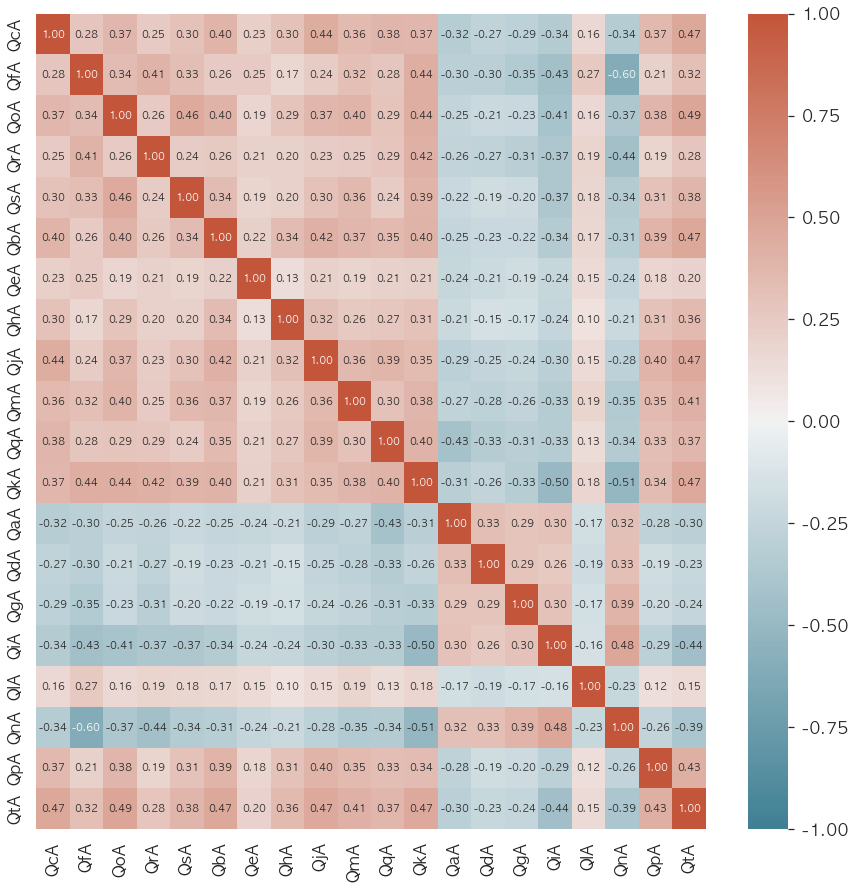

In [388]:
plt.subplots(figsize=[15,15])
sns.heatmap(df_train[mach_A].corr(method = 'spearman'), 
            annot=True, fmt=".2f", vmin=-1, vmax=1, 
            cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()

In [389]:
mach_A_pred_neg = ['QaA', 'QdA', 'QgA', 'QiA', 'QnA']

In [390]:
df_train[mach_A_pred_neg] = 6 - df_train[mach_A_pred_neg]
df_test[mach_A_pred_neg] = 6 - df_test[mach_A_pred_neg]

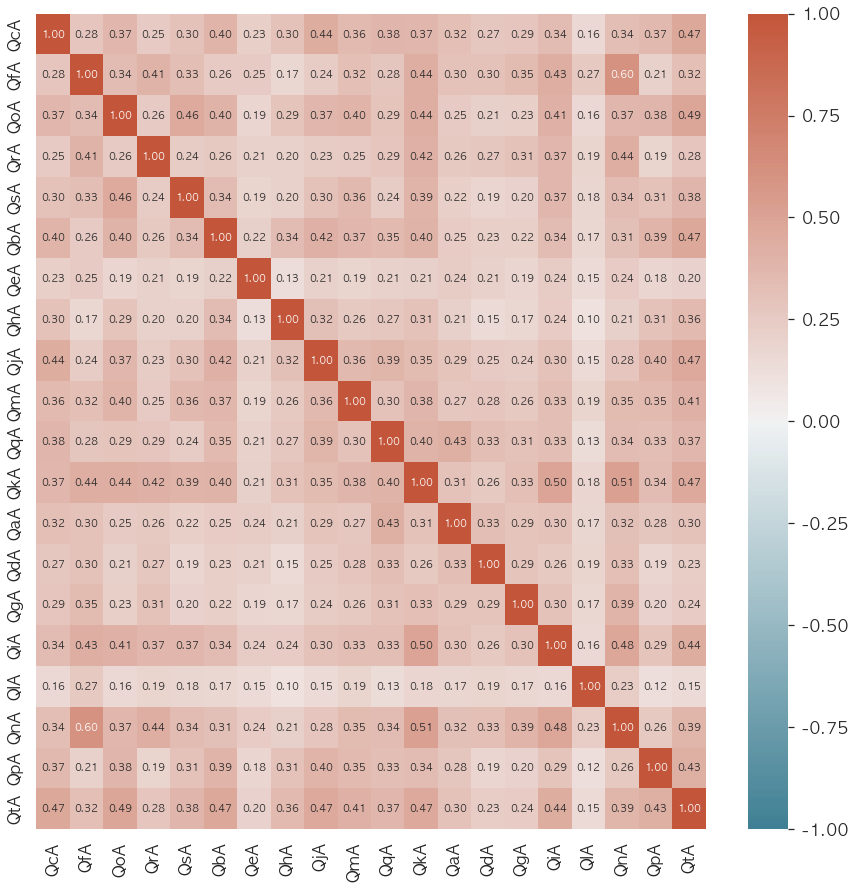

In [391]:
plt.subplots(figsize=[15,15])
sns.heatmap(df_train[mach_A].corr(method = 'spearman'), 
            annot=True, fmt=".2f", vmin=-1, vmax=1, 
            cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()

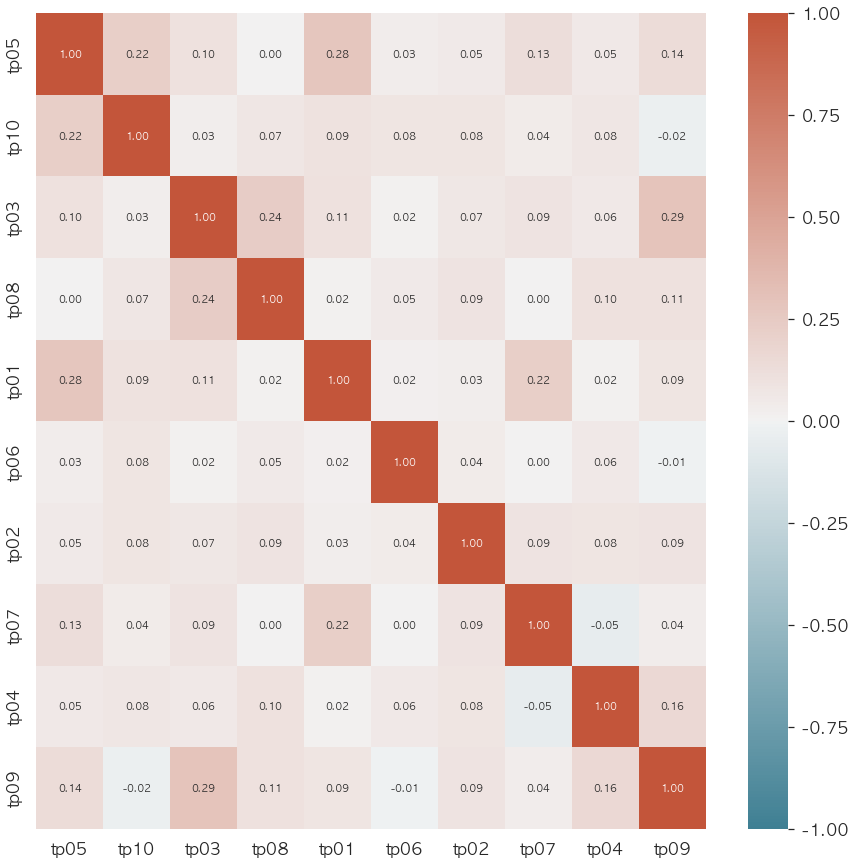

In [392]:
plt.subplots(figsize=[15,15])
sns.heatmap(df_train[tipi].corr(method = 'spearman'), 
            annot=True, fmt=".2f", vmin=-1, vmax=1, 
            cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()

### EDA

In [393]:
df_train.shape, df_test.shape, df_label.shape

((45532, 76), (11383, 76), (45532, 1))

* 가용한 Feature의 수가 많으므로, Feature에 대한 사전 정보에 따라 살펴볼 그룹을 분할한다.
* 크게, Mach, TIPI, Demographic, Word-related로 분류할 것이다.
* mach_A, mach_E // tipi // demog // wrd

#### Mach - 문항

In [394]:
tdf1 = df_train[mach_A]
tdf2 = df_test[mach_A]

* 결측치를 살펴보자

In [395]:
tdf1.isnull().sum().sum(), tdf2.isnull().sum().sum()

(0, 0)

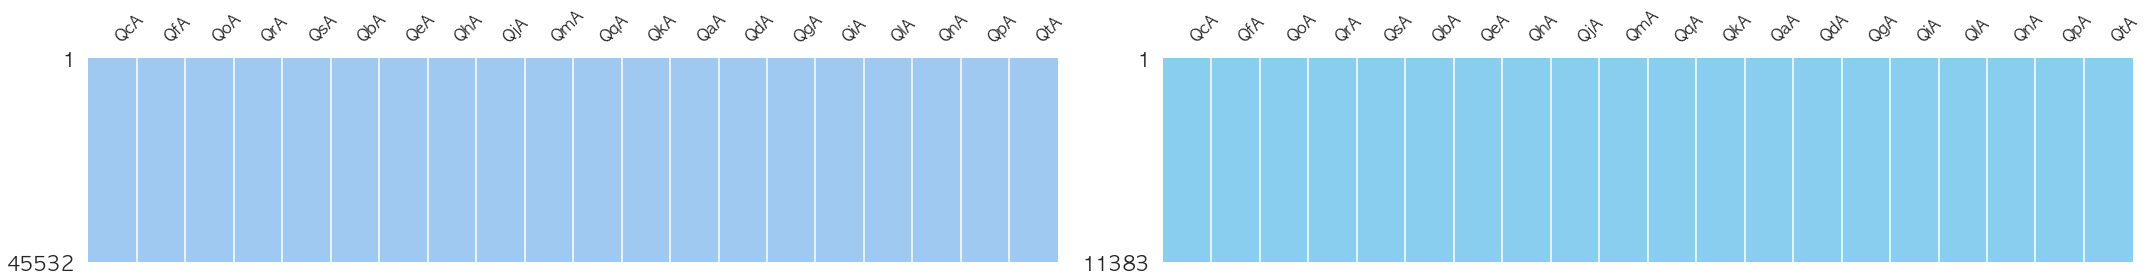

In [396]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 4))
msno.matrix(df=tdf1, color=(0.63, 0.79, 0.95), ax=axes[0])
msno.matrix(df=tdf2, color=(0.54, 0.81, 0.94), ax=axes[1])
plt.tight_layout()
plt.show()

* 결측치는 확인되지 않는다. 

* 요약치를 확인한다.

In [397]:
tmp_df = tdf1.copy()
summary = pd.DataFrame()
for idx, name in enumerate(tmp_df.columns.values):
    tmp_summary = pd.DataFrame({'Count_val':[tmp_df[('%s' % name)].count()],
              'Count_Nan':[tmp_df[('%s' % name)].isnull().sum()],
              'Mean':[tmp_df[('%s' % name)].mean()],
              'Median':[tmp_df[('%s' % name)].median()],
              #'Mode':[tmp_df[('%s' % name)].mode()],
              'Std':[tmp_df[('%s' % name)].std()],
              'Var':[tmp_df[('%s' % name)].var()],
              'Min':[tmp_df[('%s' % name)].min()],
              '25% Q':[tmp_df[('%s' % name)].quantile(q=0.25, interpolation='linear')],
              '50% Q':[tmp_df[('%s' % name)].quantile(q=0.5, interpolation='linear')],
              '75% Q':[tmp_df[('%s' % name)].quantile(q=0.75, interpolation='linear')],
              'Max':[tmp_df[('%s' % name)].max()],
              'Skewness':[tmp_df[('%s' % name)].skew()],
              'Kurtosis':[tmp_df[('%s' % name)].kurt()]}).T
    tmp_summary.columns = [('%s' % name)]
    summary = pd.concat([summary, tmp_summary], axis = 1)
summary.round(2)

QcA       QfA       QoA       QrA       QsA       QbA  \
Count_val  45532.00  45532.00  45532.00  45532.00  45532.00  45532.00   
Count_Nan      0.00      0.00      0.00      0.00      0.00      0.00   
Mean           3.66      3.83      3.22      3.18      3.43      2.90   
Median         4.00      4.00      4.00      3.00      4.00      3.00   
Std            1.43      1.35      1.48      1.42      1.37      1.57   
Var            2.05      1.82      2.18      2.03      1.89      2.45   
Min            1.00      1.00      1.00      1.00      1.00      1.00   
25% Q          2.00      3.00      2.00      2.00      2.00      1.00   
50% Q          4.00      4.00      4.00      3.00      4.00      3.00   
75% Q          5.00      5.00      5.00      4.00      5.00      4.00   
Max            5.00      5.00      5.00      5.00      5.00      5.00   
Skewness      -0.72     -0.94     -0.27     -0.17     -0.53      0.04   
Kurtosis      -0.92     -0.43     -1.38     -1.33     -0.97     -1.57   

                QeA       QhA       QjA       QmA       QqA       QkA  \
Count_val  45532.00  45532.00  45532.00  45532.00  45532.00  45532.00   
Count_Nan      0.00      0.00      0.00      0.00      0.00      0.00   
Mean           3.68      2.32      3.58      3.51      3.16      2.19   
Median         4.00      2.00      4.00      4.00      3.00      2.00   
Std            1.37      1.46      1.36      1.38      1.40      1.37   
Var            1.87      2.13      1.85      1.89      1.97      1.88   
Min            1.00      1.00      1.00      1.00      1.00      1.00   
25% Q          3.00      1.00      2.00      2.00      2.00      1.00   
50% Q          4.00      2.00      4.00      4.00      3.00      2.00   
75% Q          5.00      4.00      5.00      5.00      4.00      3.00   
Max            5.00      5.00      5.00      5.00      5.00      5.00   
Skewness      -0.70      0.65     -0.62     -0.60     -0.08      0.82   
Kurtosis      -0.79     -1.05     -0.90     -0.94     -1.32     -0.68   

                QaA       QdA       QgA       QiA       QlA       QnA  \
Count_val  45532.00  45532.00  45532.00  45532.00  45532.00  45532.00   
Count_Nan      0.00      0.00      0.00      0.00      0.00      0.00   
Mean           3.87      4.25      3.44      2.84      4.33      3.37   
Median         4.00      5.00      4.00      3.00      5.00      4.00   
Std            1.20      1.04      1.51      1.48      1.15      1.47   
Var            1.43      1.09      2.28      2.20      1.32      2.17   
Min            1.00      1.00      1.00      1.00      1.00      1.00   
25% Q          3.00      4.00      2.00      1.00      4.00      2.00   
50% Q          4.00      5.00      4.00      3.00      5.00      4.00   
75% Q          5.00      5.00      5.00      4.00      5.00      5.00   
Max            5.00      5.00      5.00      5.00      5.00      5.00   
Skewness      -0.84     -1.45     -0.43      0.11     -1.77     -0.34   
Kurtosis      -0.32      1.42     -1.34     -1.44      2.13     -1.36   

                QpA       QtA  
Count_val  45532.00  45532.00  
Count_Nan      0.00      0.00  
Mean           3.07      3.23  
Median         3.00      4.00  
Std            1.49      1.52  
Var            2.22      2.32  
Min            1.00      1.00  
25% Q          2.00      2.00  
50% Q          3.00      4.00  
75% Q          4.00      5.00  
Max            5.00      5.00  
Skewness      -0.11     -0.24  
Kurtosis      -1.47     -1.44

* Outlier를 확인한다

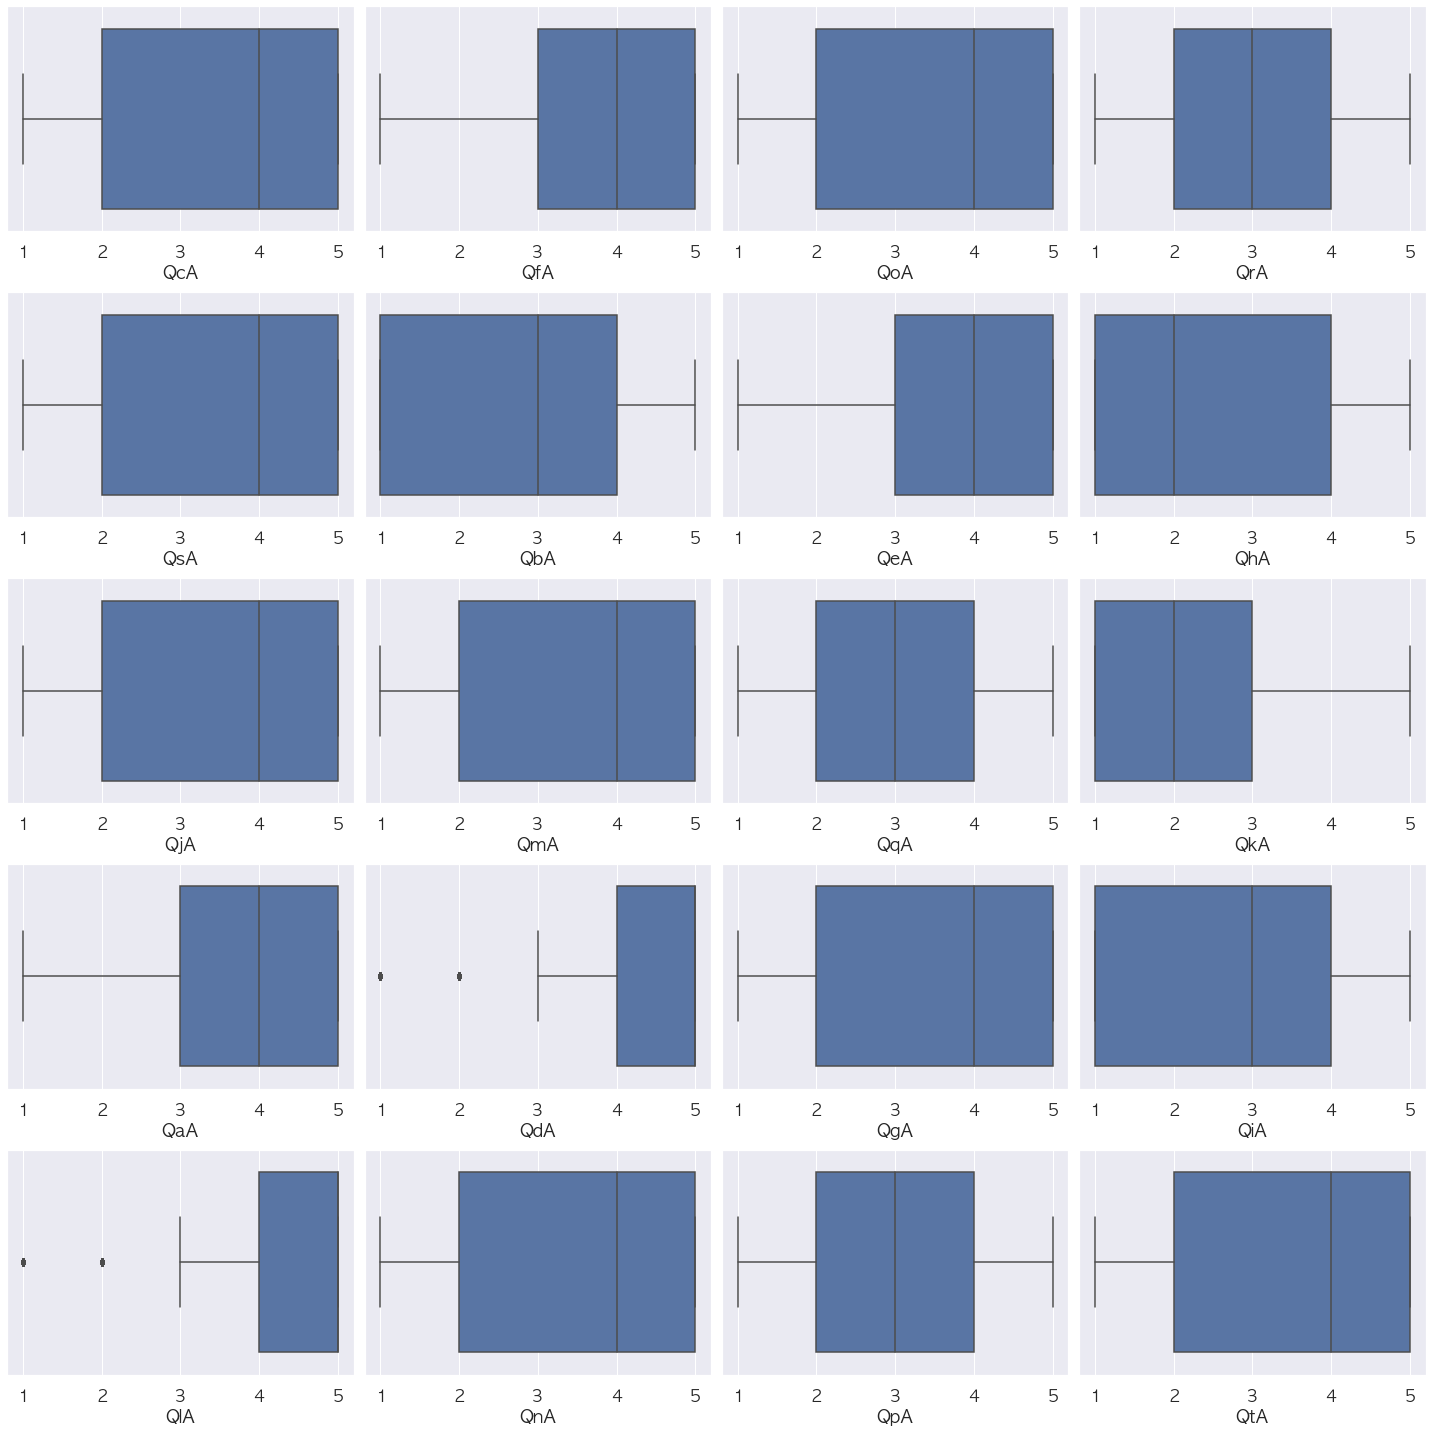

In [398]:
ax_list = []
t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])


fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])

for idx, name in enumerate(ax_list):
    sns.boxplot(x=tdf1[('%s' % (t_col[idx]))], ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()    

In [21]:
info, mask = outlier_check(tdf1, 2) # 1 = IQR method, 2 = 3sd method
info

lower     upper  min  max  counts
QcA -0.632133  7.956828  1.0  5.0       0
QfA -0.214103  7.877812  1.0  5.0       0
QoA -1.212009  7.646473  1.0  5.0       0
QrA -1.096636  7.449663  1.0  5.0       0
QsA -0.691866  7.557762  1.0  5.0       0
QbA -1.793962  7.602888  1.0  5.0       0
QeA -0.425568  7.789663  1.0  5.0       0
QhA -2.064487  6.700391  1.0  5.0       0
QjA -0.508130  7.659188  1.0  5.0       0
QmA -0.615781  7.635021  1.0  5.0       0
QqA -1.053489  7.372561  1.0  5.0       0
QkA -1.931585  6.303719  1.0  5.0       0
QaA  0.279609  7.461321  1.0  5.0       0
QdA  1.120048  7.381797  1.0  5.0    1378
QgA -1.092396  7.971207  1.0  5.0       0
QiA -1.602912  7.287529  1.0  5.0       0
QlA  0.884751  7.766703  1.0  5.0       0
QnA -1.051961  7.786170  1.0  5.0       0
QpA -1.397479  7.540983  1.0  5.0       0
QtA -1.339122  7.790497  1.0  5.0       0

* 각 Feature의 분포를 확인한다.

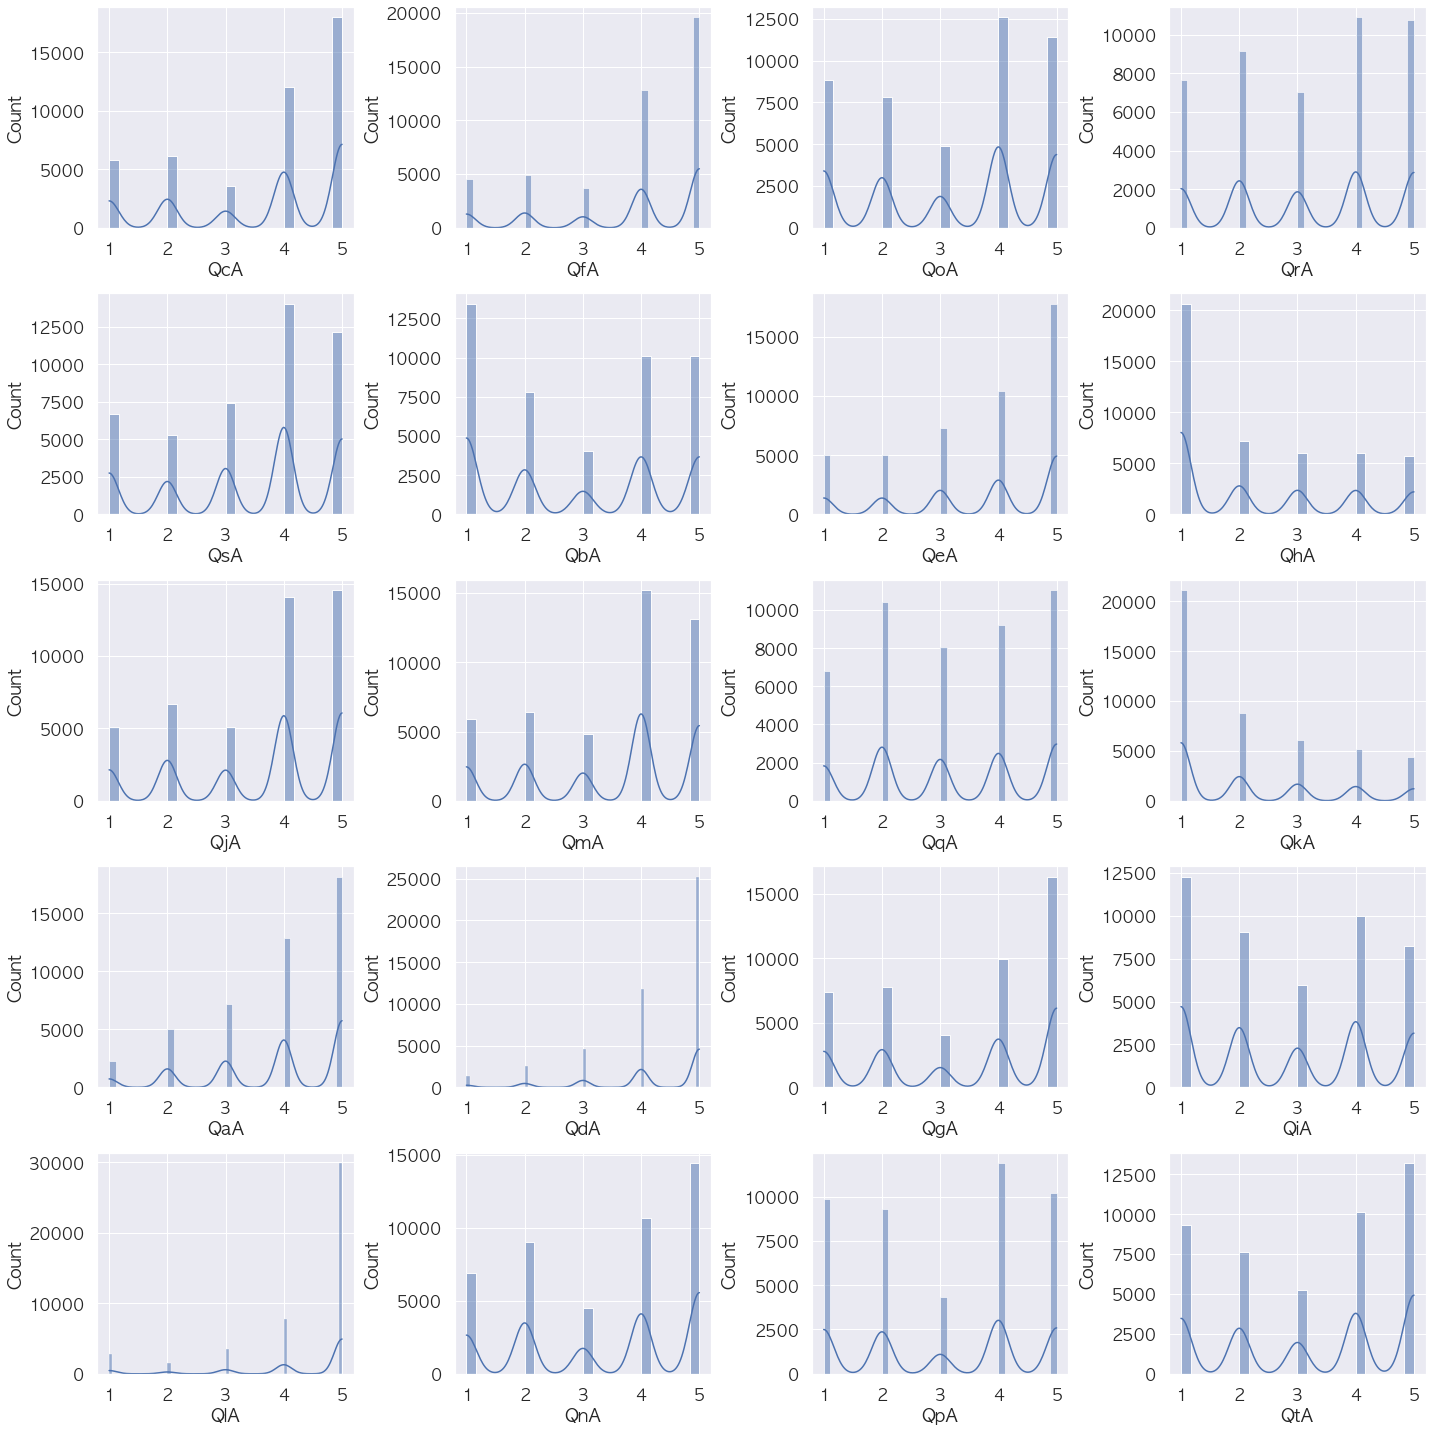

In [399]:
ax_list = []
t_col = tdf1.columns.values

t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])
        
fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])
for idx, name in enumerate(ax_list):
        if idx < len(t_col):
            sns.histplot(tdf1[('%s' % (t_col[idx]))], kde=True, ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()

* discrete numerical, 정규분포와 거리가 있어보인다.

* 변수간 상관을 확인해보자 

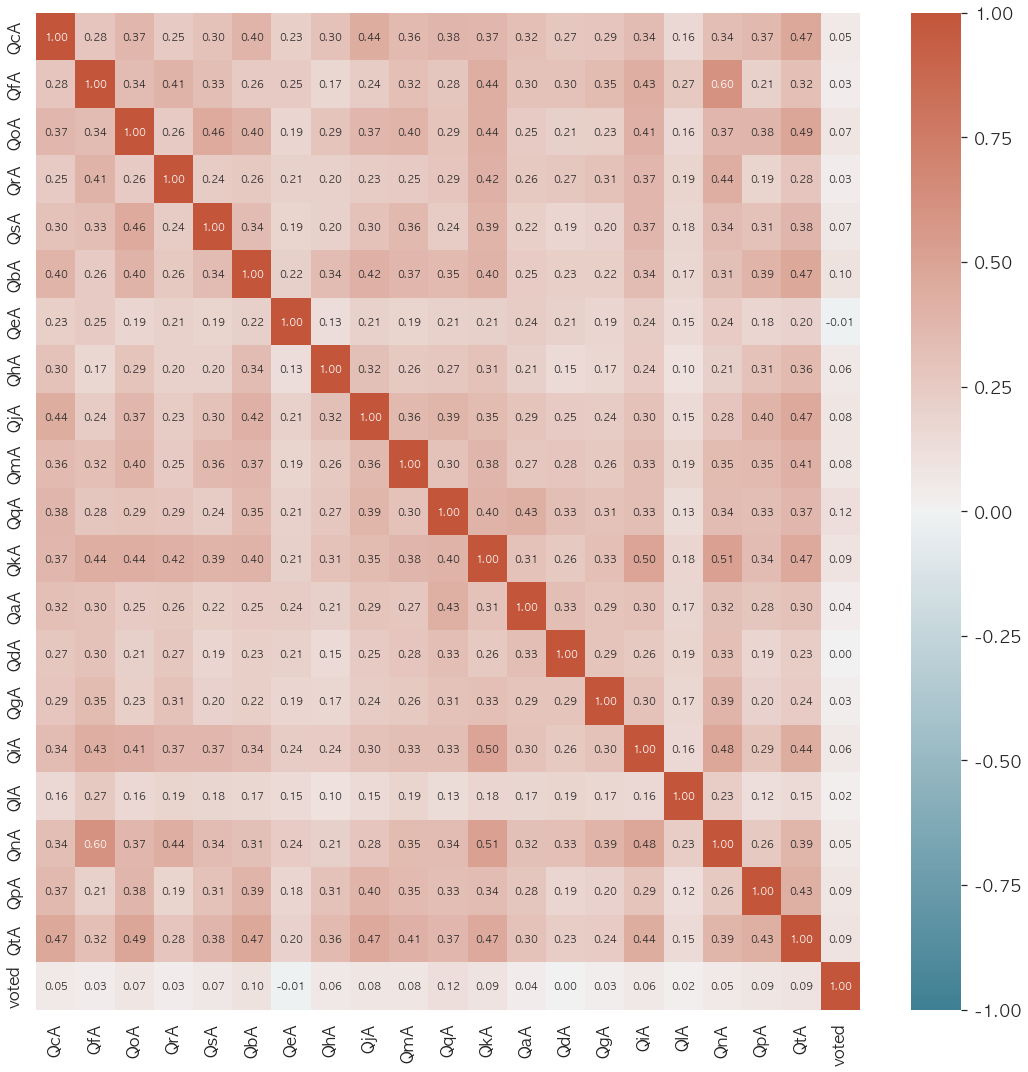

In [401]:
plt.subplots(figsize=[15,15])
sns.heatmap(pd.concat([tdf1, df_label], axis = 1).corr('spearman'),
            annot=True, fmt='.2f', 
            vmin = -1, vmax =1, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.tight_layout()
plt.show()

* Target은 Categorical Value이므로 Target과의 상관을 판정핫기는 어렵다. 다만, 거의 모든 feature에서 정적 상관이 관찰되었다.
* Mach feature 간에서 높은 상관이 관찰되지는 않는다. 일부 상관이 .5를 넘지만 섣불리 제거하기 어렵다

* Mach feature들은 조합을 통해 Tactic/ Morality/ View 구인의 점수를 구성한다. 
* 문항이 식별되는 feature들은 구인에 맞추어 평균을 내주자.

In [ ]:
mach_A_T=['QcA','QfA','QoA','QrA','QsA']
mach_A_V=['QbA','QeA','QhA','QjA','QmA','QqA']
mach_A_M=['QkA']

In [408]:
tdf1['mach_T'] = tdf1[mach_A_T].mean(axis=1)
tdf1['mach_V'] = tdf1[mach_A_V].mean(axis=1)
tdf1['mach_M'] = tdf1[mach_A_M].mean(axis=1)

tdf2['mach_T'] = tdf2[mach_A_T].mean(axis=1)
tdf2['mach_V'] = tdf2[mach_A_V].mean(axis=1)
tdf2['mach_M'] = tdf2[mach_A_M].mean(axis=1)

In [410]:
df_machA_train = tdf1.copy()
df_machA_test = tdf2.copy()

#### Mash - RT

In [411]:
tdf1 = df_train[mach_E]
tdf2 = df_test[mach_E]

* 결측치 확인

In [412]:
tdf1.isnull().sum().sum(), tdf2.isnull().sum().sum()

(0, 0)

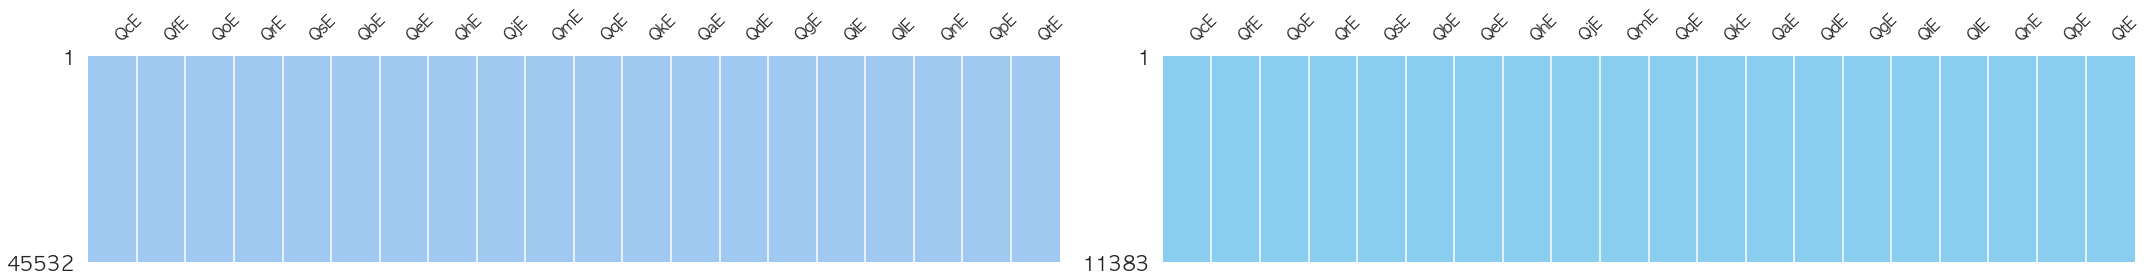

In [413]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 4))
msno.matrix(df=tdf1, color=(0.63, 0.79, 0.95), ax=axes[0])
msno.matrix(df=tdf2, color=(0.54, 0.81, 0.94), ax=axes[1])
plt.tight_layout()
plt.show()

* 요약치 확인

In [414]:
tmp_df = tdf1.copy()
summary = pd.DataFrame()
for idx, name in enumerate(tmp_df.columns.values):
    tmp_summary = pd.DataFrame({'Count_val':[tmp_df[('%s' % name)].count()],
              'Count_Nan':[tmp_df[('%s' % name)].isnull().sum()],
              'Mean':[tmp_df[('%s' % name)].mean()],
              'Median':[tmp_df[('%s' % name)].median()],
              #'Mode':[tmp_df[('%s' % name)].mode()],
              'Std':[tmp_df[('%s' % name)].std()],
              'Var':[tmp_df[('%s' % name)].var()],
              'Min':[tmp_df[('%s' % name)].min()],
              '25% Q':[tmp_df[('%s' % name)].quantile(q=0.25, interpolation='linear')],
              '50% Q':[tmp_df[('%s' % name)].quantile(q=0.5, interpolation='linear')],
              '75% Q':[tmp_df[('%s' % name)].quantile(q=0.75, interpolation='linear')],
              'Max':[tmp_df[('%s' % name)].max()],
              'Skewness':[tmp_df[('%s' % name)].skew()],
              'Kurtosis':[tmp_df[('%s' % name)].kurt()]}).T
    tmp_summary.columns = [('%s' % name)]
    summary = pd.concat([summary, tmp_summary], axis = 1)
summary.round(2)

QcE           QfE           QoE           QrE          QsE  \
Count_val     45532.00  4.553200e+04  4.553200e+04  4.553200e+04     45532.00   
Count_Nan         0.00  0.000000e+00  0.000000e+00  0.000000e+00         0.00   
Mean           1484.29  1.850650e+03  1.435760e+03  2.470810e+03      1164.12   
Median          899.00  7.120000e+02  8.830000e+02  1.117000e+03       747.00   
Std            8977.66  7.608236e+04  1.084997e+04  1.482890e+05      7433.52   
Var        80598456.61  5.788525e+09  1.177219e+08  2.198962e+10  55257150.53   
Min              25.00  2.500000e+01  0.000000e+00  2.500000e+01        25.00   
25% Q           651.00  5.040000e+02  6.380000e+02  7.940000e+02       527.00   
50% Q           899.00  7.120000e+02  8.830000e+02  1.117000e+03       747.00   
75% Q          1335.00  1.078000e+03  1.300000e+03  1.664000e+03      1124.00   
Max          871557.00  1.176370e+07  1.309739e+06  3.159328e+07   1286581.00   
Skewness         56.10  1.256000e+02  7.665000e+01  2.123700e+02       130.39   
Kurtosis       3875.93  1.722721e+04  7.094730e+03  4.524071e+04     20758.56   

                    QbE           QeE           QhE           QjE  \
Count_val  4.553200e+04  4.553200e+04  4.553200e+04  4.553200e+04   
Count_Nan  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Mean       2.189590e+03  1.899290e+03  4.584270e+03  2.576360e+03   
Median     1.218000e+03  1.154000e+03  1.464000e+03  1.260000e+03   
Std        3.351027e+04  1.670765e+04  5.020265e+05  5.411432e+04   
Var        1.122938e+09  2.791457e+08  2.520306e+11  2.928359e+09   
Min        2.500000e+01  2.500000e+01  0.000000e+00  0.000000e+00   
25% Q      8.750000e+02  8.340000e+02  1.077000e+03  9.020000e+02   
50% Q      1.218000e+03  1.154000e+03  1.464000e+03  1.260000e+03   
75% Q      1.838000e+03  1.656000e+03  2.090000e+03  1.899000e+03   
Max        5.580395e+06  1.919926e+06  1.070860e+08  9.910006e+06   
Skewness   1.290300e+02  8.537000e+01  2.131500e+02  1.521300e+02   
Kurtosis   1.921215e+04  8.392090e+03  4.546442e+04  2.606558e+04   

                    QmE           QqE           QkE           QaE  \
Count_val  4.553200e+04  4.553200e+04  4.553200e+04  4.553200e+04   
Count_Nan  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Mean       2.050290e+03  1.154350e+03  2.038990e+03  9.453600e+02   
Median     9.060000e+02  6.520000e+02  1.178000e+03  5.570000e+02   
Std        7.530787e+04  2.250689e+04  3.069164e+04  1.307565e+04   
Var        5.671275e+09  5.065599e+08  9.419770e+08  1.709726e+08   
Min        2.500000e+01  0.000000e+00  0.000000e+00  2.500000e+01   
25% Q      6.500000e+02  4.610000e+02  8.590000e+02  4.040000e+02   
50% Q      9.060000e+02  6.520000e+02  1.178000e+03  5.570000e+02   
75% Q      1.342000e+03  9.820000e+02  1.721000e+03  8.270000e+02   
Max        1.410832e+07  4.277510e+06  4.824953e+06  2.413960e+06   
Skewness   1.590700e+02  1.614400e+02  1.187000e+02  1.476700e+02   
Kurtosis   2.804659e+04  2.928974e+04  1.624450e+04  2.589912e+04   

                    QdE          QgE           QiE           QlE          QnE  \
Count_val  4.553200e+04     45532.00  4.553200e+04  4.553200e+04     45532.00   
Count_Nan  0.000000e+00         0.00  0.000000e+00  0.000000e+00         0.00   
Mean       1.490670e+03      1284.61  4.068430e+03  3.741020e+03       959.88   
Median     9.310000e+02       772.00  1.800000e+03  1.125000e+03       596.00   
Std        1.092260e+04      9756.58  1.141738e+05  3.663672e+05      5869.96   
Var        1.193032e+08  95190930.21  1.303565e+10  1.342249e+11  34456478.86   
Min        2.600000e+01        25.00  0.000000e+00  2.500000e+01        25.00   
25% Q      6.790000e+02       549.00  1.259000e+03  8.060000e+02       428.00   
50% Q      9.310000e+02       772.00  1.800000e+03  1.125000e+03       596.00   
75% Q      1.355000e+03      1150.00  2.761000e+03  1.649000e+03       891.00   
Max        1.552821e+06   1068252.00  1.703586e+07  7.75435

* Outlier 확인

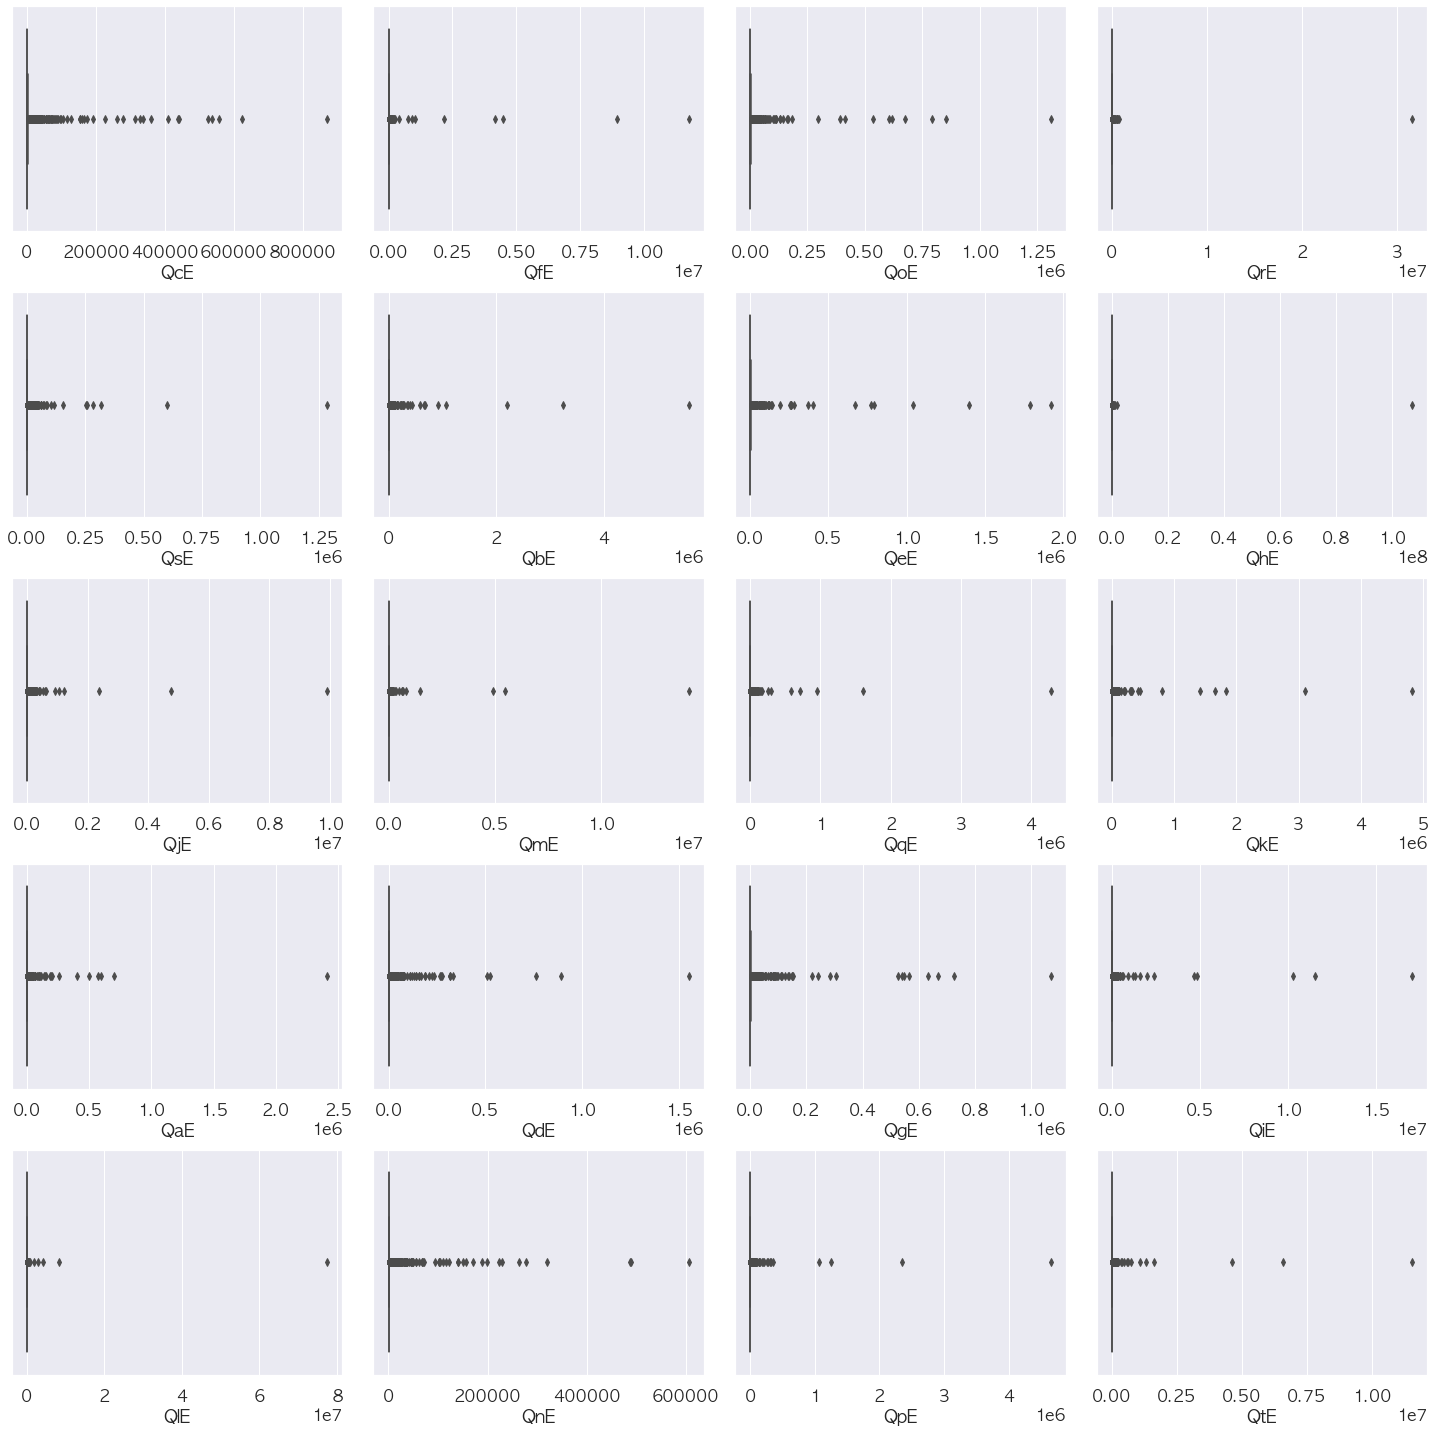

In [415]:
ax_list = []
t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])

fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])

for idx, name in enumerate(ax_list):
    if idx < len(t_col):
        sns.boxplot(x=tdf1[('%s' % (t_col[idx]))], ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()    

In [416]:
info, mask = outlier_check(tdf1, 2) # 1 = IQR method, 2 = 3sd method
info

lower         upper  min        max  counts
QcE -2.544870e+04  2.841729e+04   25     871557      89
QfE -2.263964e+05  2.300977e+05   25   11763701      10
QoE -3.111416e+04  3.398568e+04    0    1309739      59
QrE -4.423961e+05  4.473377e+05   25   31593284       7
QsE -2.113643e+04  2.346466e+04   25    1286581      55
QbE -9.834121e+04  1.027204e+05   25    5580395      28
QeE -4.822367e+04  5.202225e+04   25    1919926      51
QhE -1.501495e+06  1.510664e+06    0  107086013       2
QjE -1.597666e+05  1.649193e+05    0    9910006      33
QmE -2.238733e+05  2.279739e+05   25   14108320      12
QqE -6.636631e+04  6.867501e+04    0    4277510      24
QkE -9.003595e+04  9.411392e+04    0    4824953      23
QaE -3.828159e+04  4.017230e+04   25    2413960      31
QdE -3.127713e+04  3.425847e+04   26    1552821      55
QgE -2.798514e+04  3.055436e+04   25    1068252      56
QiE -3.384529e+05  3.465898e+05    0   17035860      18
QlE -1.095361e+06  1.102843e+06   25   77543511       5
QnE -1.665001e+04  1.856977e+04   25     606694      72
QpE -7.637315e+04  7.964010e+04    0    4650742      26
QtE -1.996877e+05  2.041678e+05   25   11556504      15

* Q_E 변수들은 해당 항목을 반응하는데 걸린 반응시간(ms)을 나타낸다.
* 과도하게 값이 높은 Outlier과 관찰된다.

* 분포 확인, Outlier에 의해 분포가 왜곡된 것으로 보인다. 

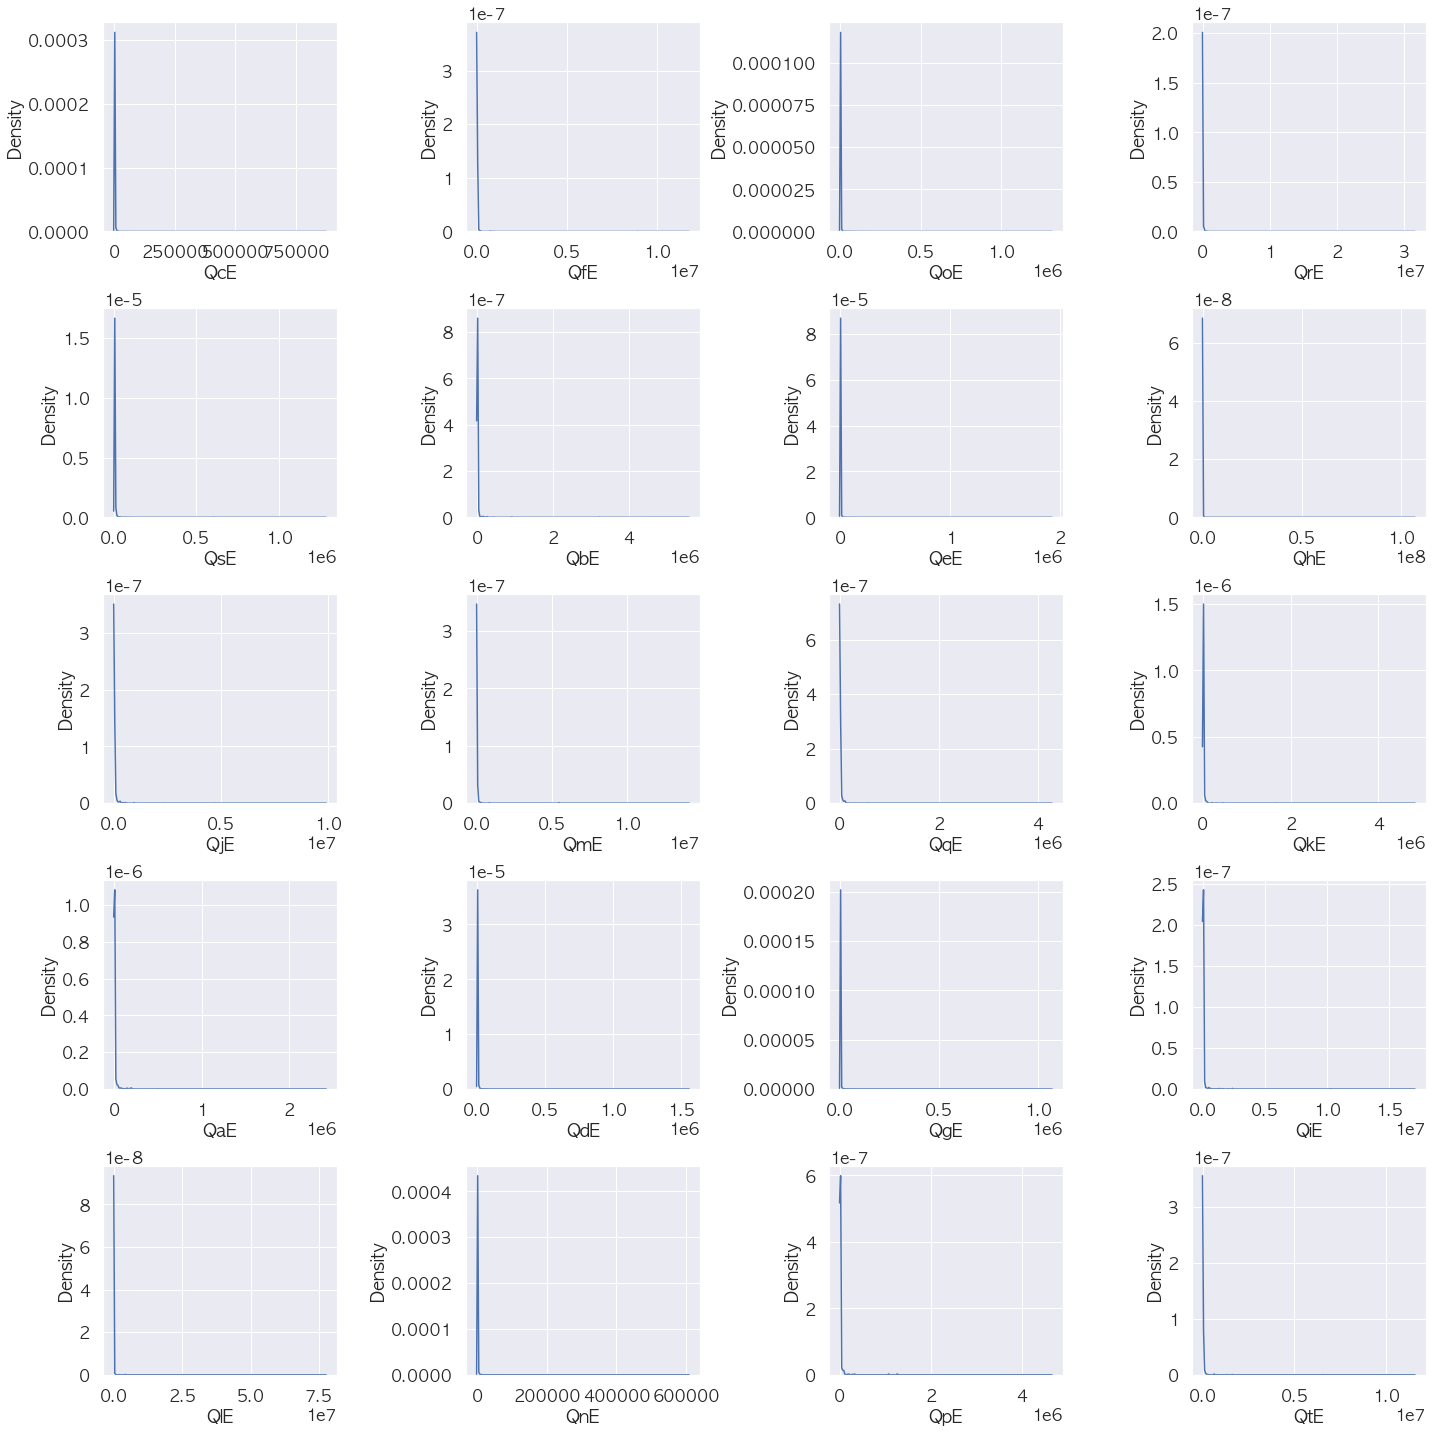

In [417]:
ax_list = []
t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])
        
fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])
for idx, name in enumerate(ax_list):
    if idx < len(t_col):
        sns.kdeplot(tdf1[('%s' % (t_col[idx]))], ax = ax[name[0], name[1]])
        #sns.histplot(tdf1[('%s' % (t_col[idx]))], kde=False, ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()

* outlier를 제거할 경우 다른 유용한 feature가 모두 제거될 위험성이 있으므로 outlier 값을 numpy.clip 으로 변환해준다. 
* 변환 기준은 95%로 한다. 

In [418]:
outlier_col = tdf1.columns.values
ctdf1 = tdf1.loc[:,outlier_col].apply(lambda x: x.clip(x.quantile(.00), x.quantile(.95)), axis=0)

* 재확인한다.

In [419]:
info, mask = outlier_check(ctdf1, 2) # 1 = IQR method, 2 = 3sd method
info

lower        upper   min      max  counts
QcE  -938.672441  3164.834993  25.0  3052.45       0
QfE  -800.352039  2585.236237  25.0  2485.45       0
QoE  -875.859182  3034.921688   0.0  2924.00       0
QrE -1323.835891  4114.546717  25.0  4006.45       0
QsE  -882.235668  2752.718274  25.0  2671.00       0
QbE -1357.872411  4399.863990  25.0  4230.90       0
QeE -1203.347259  4001.408636  25.0  3913.90       0
QhE -1179.368841  4638.399369   0.0  4397.00       0
QjE -1784.108600  5034.344830   0.0  5052.00    2287
QmE -1077.005476  3350.935942  25.0  3297.00       0
QqE  -660.158557  2267.939590   0.0  2152.00       0
QkE -1141.076501  4012.344972   0.0  3860.00       0
QaE  -497.318643  1857.740133  25.0  1759.45       0
QdE  -883.022102  3147.560594  26.0  3031.90       0
QgE  -789.828118  2687.239960  25.0  2580.00       0
QiE -2157.579507  6691.768954   0.0  6412.35       0
QlE -1057.537934  3775.465546  25.0  3592.00       0
QnE  -578.266652  2047.219153  25.0  1942.45       0
QpE  -880.571795  3218.101429   0.0  3089.45       0
QtE -1176.998911  3738.678842  25.0  3630.90       0

In [420]:
tmp_df = ctdf1.copy()
summary = pd.DataFrame()
for idx, name in enumerate(tmp_df.columns.values):
    tmp_summary = pd.DataFrame({'Count_val':[tmp_df[('%s' % name)].count()],
              'Count_Nan':[tmp_df[('%s' % name)].isnull().sum()],
              'Mean':[tmp_df[('%s' % name)].mean()],
              'Median':[tmp_df[('%s' % name)].median()],
              #'Mode':[tmp_df[('%s' % name)].mode()],
              'Std':[tmp_df[('%s' % name)].std()],
              'Var':[tmp_df[('%s' % name)].var()],
              'Min':[tmp_df[('%s' % name)].min()],
              '25% Q':[tmp_df[('%s' % name)].quantile(q=0.25, interpolation='linear')],
              '50% Q':[tmp_df[('%s' % name)].quantile(q=0.5, interpolation='linear')],
              '75% Q':[tmp_df[('%s' % name)].quantile(q=0.75, interpolation='linear')],
              'Max':[tmp_df[('%s' % name)].max()],
              'Skewness':[tmp_df[('%s' % name)].skew()],
              'Kurtosis':[tmp_df[('%s' % name)].kurt()]}).T
    tmp_summary.columns = [('%s' % name)]
    summary = pd.concat([summary, tmp_summary], axis = 1)
summary.round(2)

QcE        QfE        QoE        QrE        QsE        QbE  \
Count_val   45532.00   45532.00   45532.00   45532.00   45532.00   45532.00   
Count_Nan       0.00       0.00       0.00       0.00       0.00       0.00   
Mean         1113.08     892.44    1079.53    1395.36     935.24    1521.00   
Median        899.00     712.00     883.00    1117.00     747.00    1218.00   
Std           683.92     564.26     651.80     906.40     605.83     959.62   
Var        467743.70  318394.67  424839.08  821555.71  367024.73  920875.79   
Min            25.00      25.00       0.00      25.00      25.00      25.00   
25% Q         651.00     504.00     638.00     794.00     527.00     875.00   
50% Q         899.00     712.00     883.00    1117.00     747.00    1218.00   
75% Q        1335.00    1078.00    1300.00    1664.00    1124.00    1838.00   
Max          3052.45    2485.45    2924.00    4006.45    2671.00    4230.90   
Skewness        1.47       1.47       1.45       1.53       1.52       1.45   
Kurtosis        1.60       1.54       1.59       1.82       1.76       1.55   

                 QeE        QhE         QjE        QmE        QqE        QkE  \
Count_val   45532.00   45532.00    45532.00   45532.00   45532.00   45532.00   
Count_Nan       0.00       0.00        0.00       0.00       0.00       0.00   
Mean         1399.03    1729.52     1625.12    1136.97     803.89    1435.63   
Median       1154.00    1464.00     1260.00     906.00     652.00    1178.00   
Std           867.46     969.63     1136.41     737.99     488.02     858.90   
Var        752485.66  940178.53  1291425.20  544629.59  238159.97  737715.36   
Min            25.00       0.00        0.00      25.00       0.00       0.00   
25% Q         834.00    1077.00      902.00     650.00     461.00     859.00   
50% Q        1154.00    1464.00     1260.00     906.00     652.00    1178.00   
75% Q        1656.00    2090.00     1899.00    1342.00     982.00    1721.00   
Max          3913.90    4397.00     5052.00    3297.00    2152.00    3860.00   
Skewness        1.51       1.29        1.73       1.60       1.38       1.44   
Kurtosis        1.89       1.22        2.50       2.04       1.27       1.56   

                 QaE        QdE        QgE         QiE        QlE        QnE  \
Count_val   45532.00   45532.00   45532.00    45532.00   45532.00   45532.00   
Count_Nan       0.00       0.00       0.00        0.00       0.00       0.00   
Mean          680.21    1132.27     948.71     2267.09    1358.96     734.48   
Median        557.00     931.00     772.00     1800.00    1125.00     596.00   
Std           392.51     671.76     579.51     1474.89     805.50     437.58   
Var        154063.94  451266.58  335833.40  2175304.67  648831.18  191477.10   
Min            25.00      26.00      25.00        0.00      25.00      25.00   
25% Q         404.00     679.00     549.00     1259.00     806.00     428.00   
50% Q         557.00     931.00     772.00     1800.00    1125.00     596.00   
75% Q         827.00    1355.00    1150.00     2761.00    1649.00     891.00   
Max          1759.45    3031.90    2580.00     6412.35    3592.00    1942.45   
Skewness        1.37       1.44       1.43        1.44       1.36       1.39   
Kurtosis        1.22       1.56       1.50        1.50       1.32       1.30   

                 QpE        QtE  
Count_val   45532.00   45532.00  
Count_Nan       0.00       0.00  
Mean         1168.76    1280.84  
Median        970.00    1020.00  
Std           683.11     819.28  
Var        466642.28  671219.10  
Min             0.00      25.00  
25% Q         706.00     733.00  
50% Q         970.00    1020.00  
75% Q        1409.00    1526.00  
Max          3089.45    3630.90  
Skewness        1.40       1.53  
Kurtosis        1.47       1.78

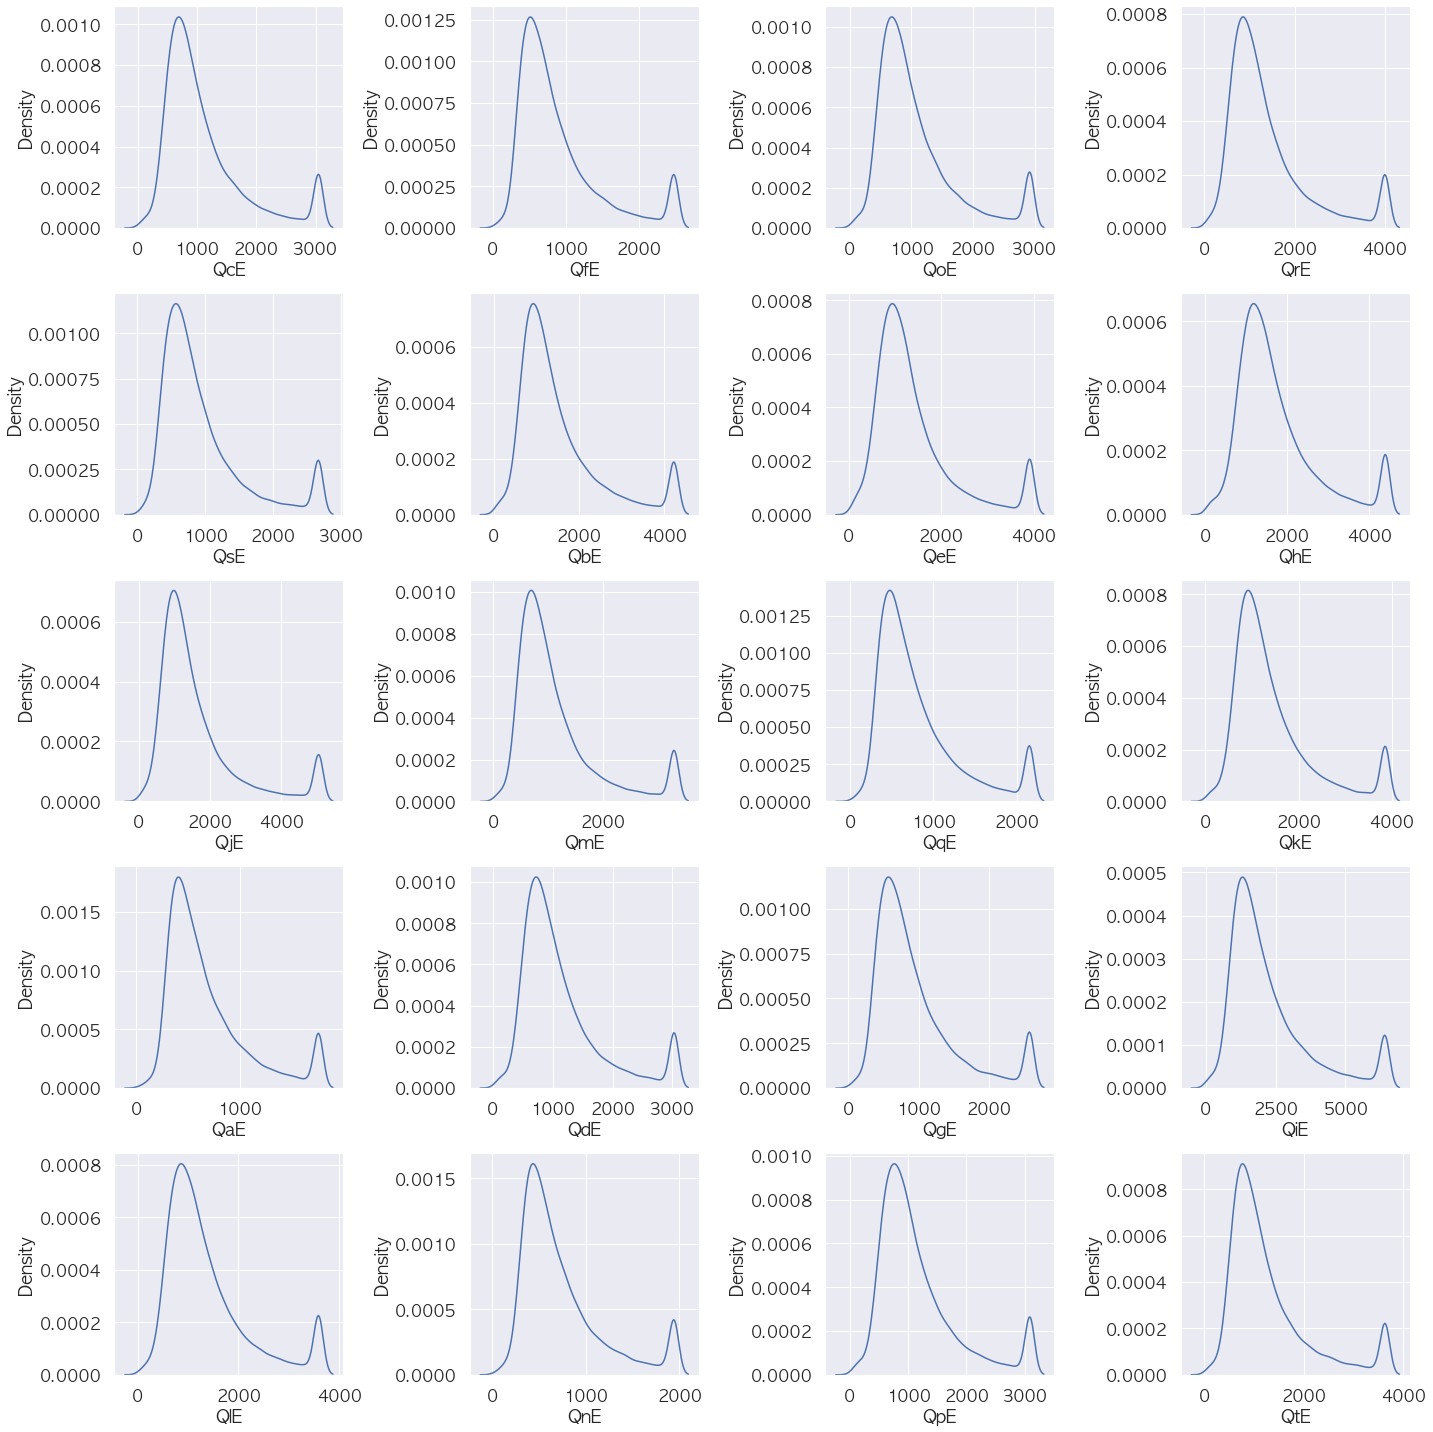

In [34]:
ax_list = []
t_col = ctdf1.columns.values
for i in range(np.ceil(np.sqrt(ctdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(ctdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])
        
fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(ctdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(ctdf1.shape[1]))), 
            figsize=[20, 20])
for idx, name in enumerate(ax_list):
    if idx < len(t_col):
        sns.kdeplot(ctdf1[('%s' % (t_col[idx]))], ax = ax[name[0], name[1]])
        #sns.histplot(tdf1[('%s' % (t_col[idx]))], kde=False, ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()

* 분포가 더 보기 좋게 변환되었다. 하지만 normality를 충족하지는 않으므로 차후 log 변환을 고려한다.

In [421]:
outlier_col = tdf2.columns.values
ctdf2 = tdf2.loc[:,outlier_col].apply(lambda x: x.clip(x.quantile(.00), x.quantile(.95)), axis=0)

In [423]:
df_machE_train = ctdf1.copy()
df_machE_test = ctdf2.copy()

#### TIPI

In [424]:
tdf1 = df_train[tipi]
tdf2 = df_test[tipi]

* 결측치 확인

In [425]:
tdf1.isnull().sum().sum(), tdf2.isnull().sum().sum()

(0, 0)

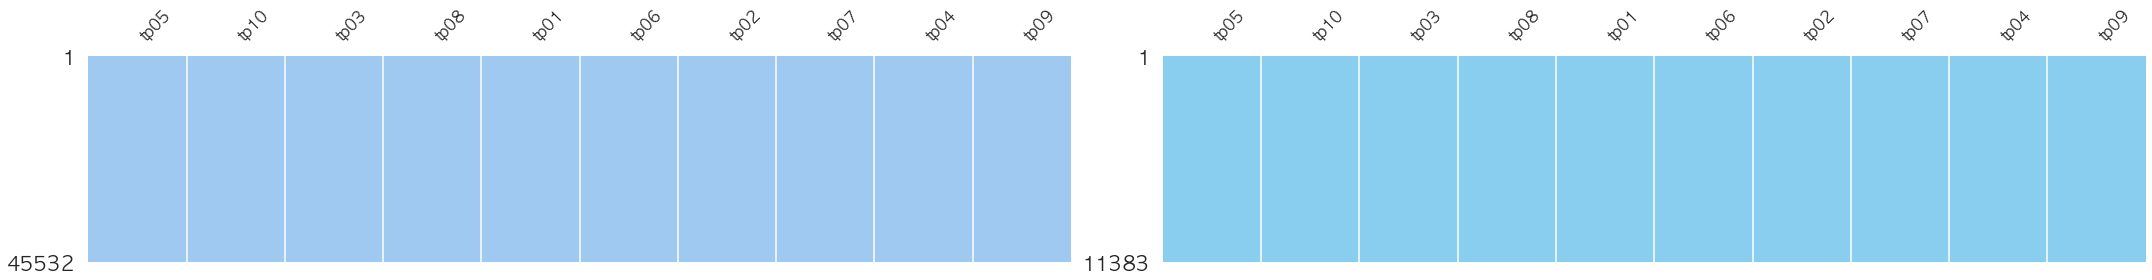

In [426]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 4))
msno.matrix(df=tdf1, color=(0.63, 0.79, 0.95), ax=axes[0])
msno.matrix(df=tdf2, color=(0.54, 0.81, 0.94), ax=axes[1])
plt.tight_layout()
plt.show()

* 요약치 확인

In [427]:
tmp_df = tdf1.copy()
summary = pd.DataFrame()
for idx, name in enumerate(tmp_df.columns.values):
    tmp_summary = pd.DataFrame({'Count_val':[tmp_df[('%s' % name)].count()],
              'Count_Nan':[tmp_df[('%s' % name)].isnull().sum()],
              'Mean':[tmp_df[('%s' % name)].mean()],
              'Median':[tmp_df[('%s' % name)].median()],
              #'Mode':[tmp_df[('%s' % name)].mode()],
              'Std':[tmp_df[('%s' % name)].std()],
              'Var':[tmp_df[('%s' % name)].var()],
              'Min':[tmp_df[('%s' % name)].min()],
              '25% Q':[tmp_df[('%s' % name)].quantile(q=0.25, interpolation='linear')],
              '50% Q':[tmp_df[('%s' % name)].quantile(q=0.5, interpolation='linear')],
              '75% Q':[tmp_df[('%s' % name)].quantile(q=0.75, interpolation='linear')],
              'Max':[tmp_df[('%s' % name)].max()],
              'Skewness':[tmp_df[('%s' % name)].skew()],
              'Kurtosis':[tmp_df[('%s' % name)].kurt()]}).T
    tmp_summary.columns = [('%s' % name)]
    summary = pd.concat([summary, tmp_summary], axis = 1)
summary.round(2)

tp05      tp10      tp03      tp08      tp01      tp06  \
Count_val  45532.00  45532.00  45532.00  45532.00  45532.00  45532.00   
Count_Nan      0.00      0.00      0.00      0.00      0.00      0.00   
Mean           1.34      3.43      1.77      3.93      3.02      3.96   
Median         1.00      3.00      1.00      4.00      3.00      4.00   
Std            1.45      1.66      1.69      2.03      2.01      2.52   
Var            2.11      2.74      2.84      4.13      4.03      6.34   
Min            0.00      0.00      0.00      0.00      0.00      0.00   
25% Q          0.00      2.00      0.00      2.00      1.00      2.00   
50% Q          1.00      3.00      1.00      4.00      3.00      4.00   
75% Q          2.00      5.00      3.00      6.00      5.00      6.00   
Max            7.00      7.00      7.00      7.00      7.00      7.00   
Skewness       1.36      0.48      0.99     -0.13      0.09     -0.38   
Kurtosis       1.75     -0.40      0.23     -1.00     -1.34     -1.25   

               tp02      tp07      tp04      tp09  
Count_val  45532.00  45532.00  45532.00  45532.00  
Count_Nan      0.00      0.00      0.00      0.00  
Mean           4.42      2.03      4.00      2.28  
Median         5.00      2.00      4.00      2.00  
Std            2.31      1.79      2.25      1.85  
Var            5.32      3.19      5.07      3.42  
Min            0.00      0.00      0.00      0.00  
25% Q          3.00      1.00      2.00      1.00  
50% Q          5.00      2.00      4.00      2.00  
75% Q          6.00      3.00      6.00      4.00  
Max            7.00      7.00      7.00      7.00  
Skewness      -0.64      0.81     -0.30      0.51  
Kurtosis      -0.84     -0.25     -1.07     -0.81

* Outlier 확인

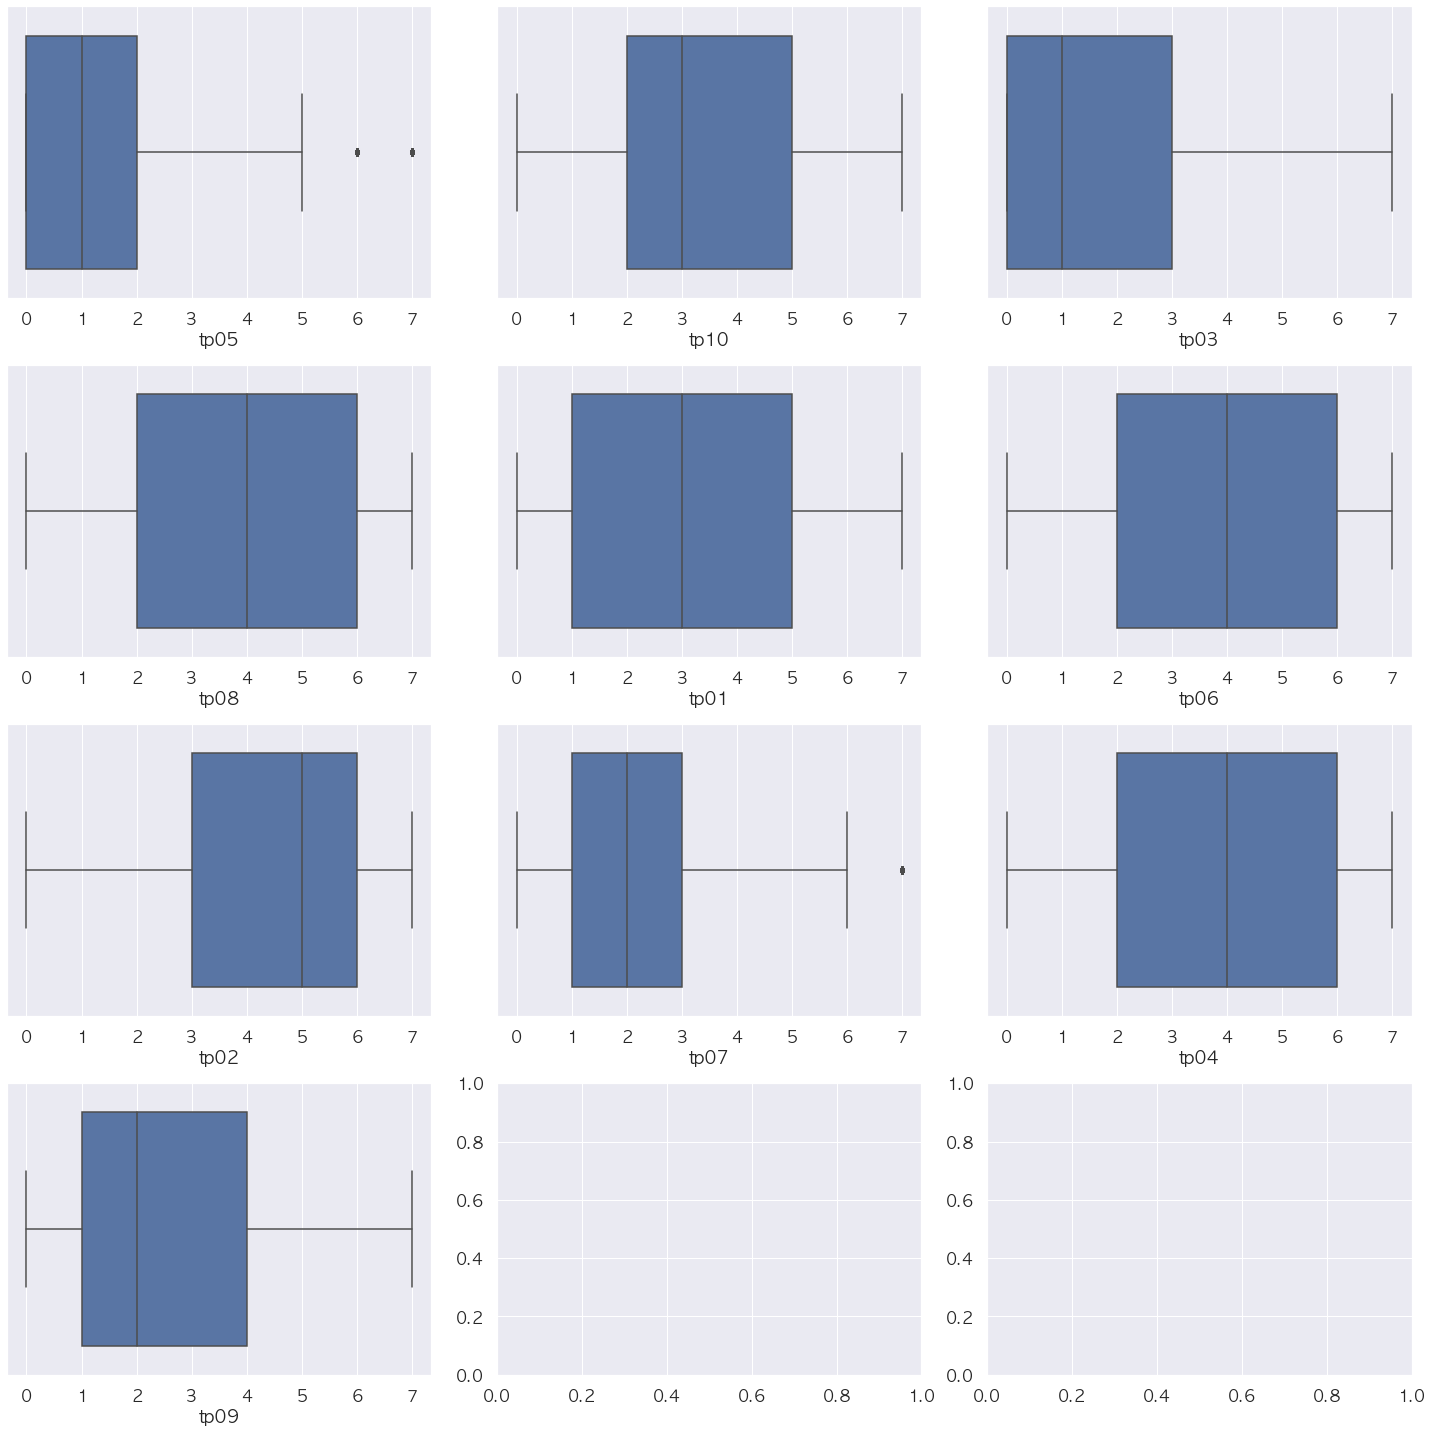

In [428]:
ax_list = []
t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])
        
fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])

for idx, name in enumerate(ax_list):
    if idx < len(t_col):
        sns.boxplot(x=tdf1[('%s' % (t_col[idx]))], ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()    

In [429]:
info, mask = outlier_check(tdf1, 2) # 1 = IQR method, 2 = 3sd method
info

lower      upper  min  max  counts
tp05 -3.021715   5.693550    0    7     798
tp10 -1.539647   8.395528    0    7       0
tp03 -3.286494   6.823918    0    7     361
tp08 -2.159707  10.026394    0    7       0
tp01 -3.005899   9.040380    0    7       0
tp06 -3.589100  11.512978    0    7       0
tp02 -2.496738  11.343439    0    7       0
tp07 -3.326373   7.388571    0    7       0
tp04 -2.751342  10.758282    0    7       0
tp09 -3.268851   7.823845    0    7       0

* 분포 확인

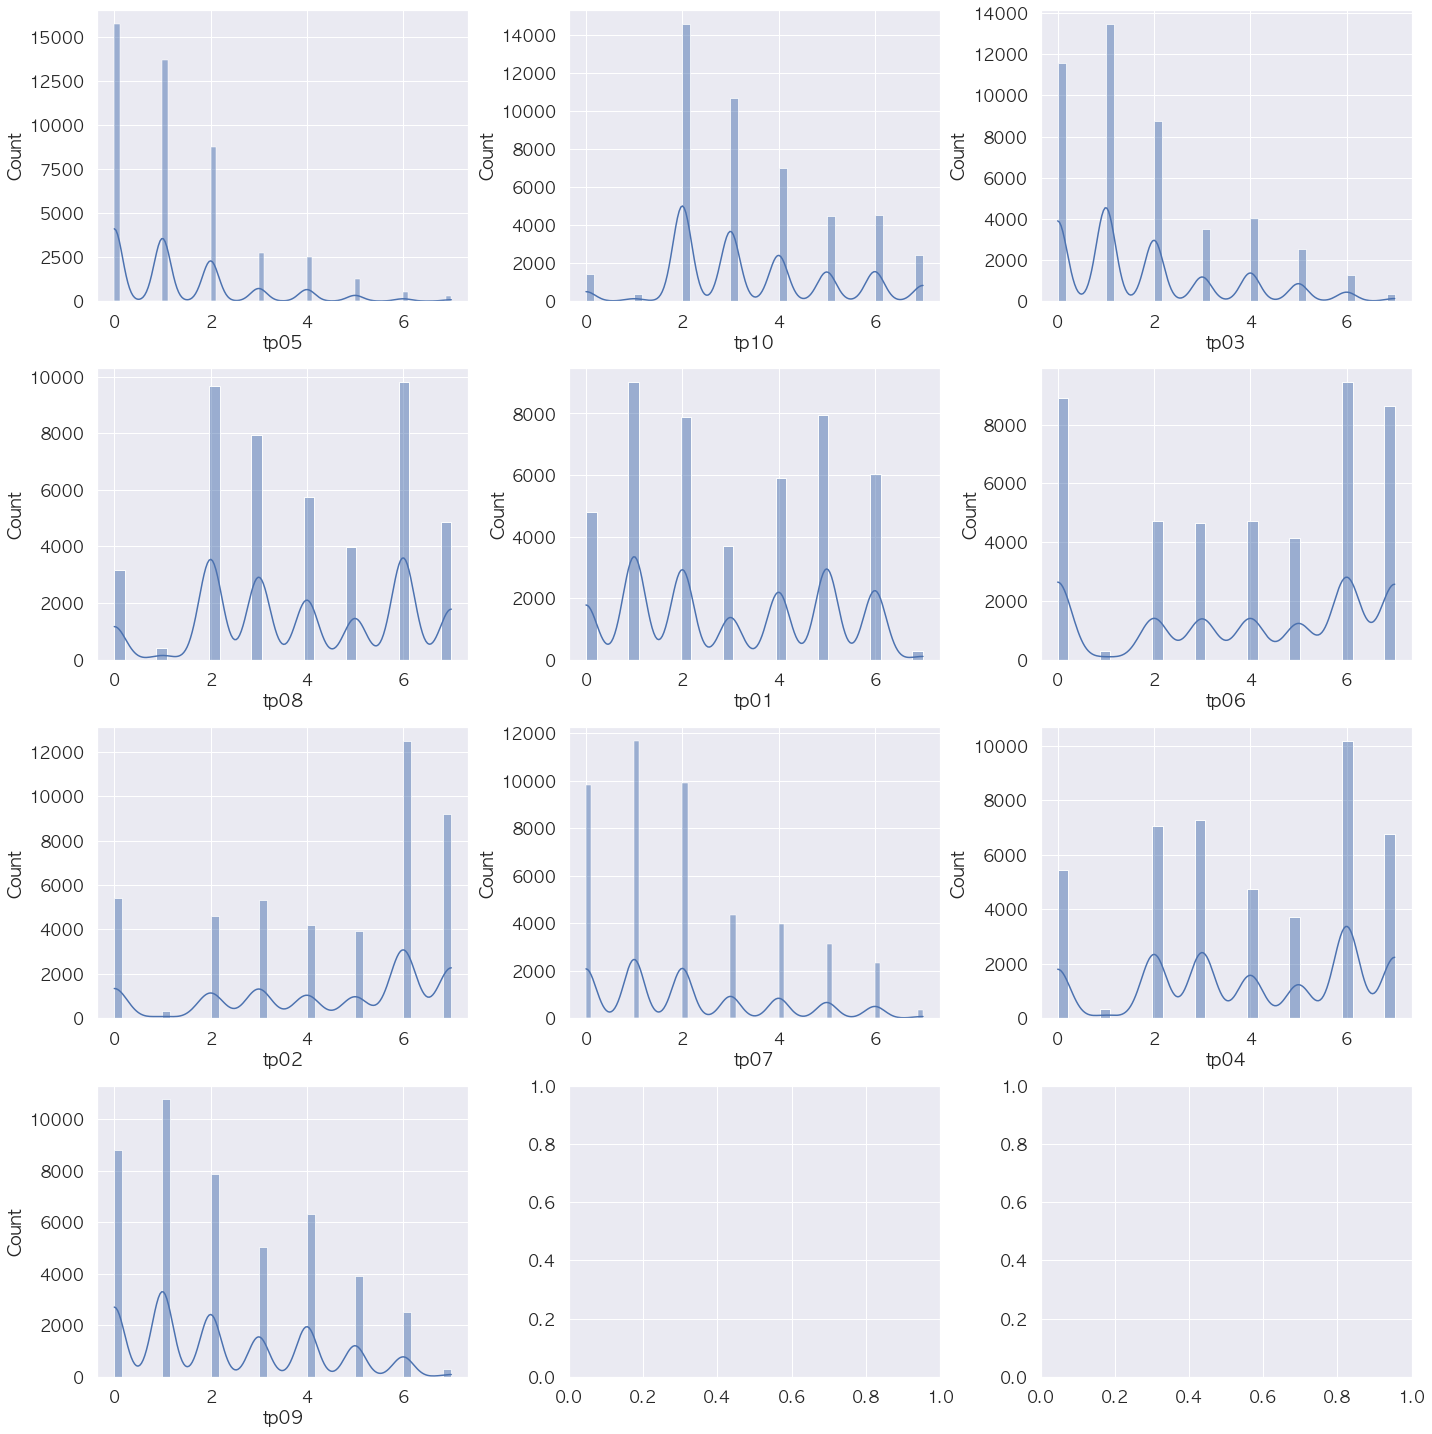

In [430]:
ax_list = []
t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])
        
fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])

for idx, name in enumerate(ax_list):
    if idx < len(t_col):
        sns.histplot(tdf1[('%s' % (t_col[idx]))], kde=True, ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()

* 해당 질문지의 반응 변수 범위는 1-7임에도 불구하고 0 값이 많이 관찰된다.
* 0 값을 결측치로 간주하여 변환 후 결측치를 다시 확인한다. 

In [431]:
tdf1 = tdf1.replace(0, np.nan)
tdf2 = tdf2.replace(0, np.nan)

In [432]:
tdf1.isnull().sum(), tdf2.isnull().sum()

(tp05    15772
 tp10     1446
 tp03    11567
 tp08     3184
 tp01     4783
 tp06     8912
 tp02     5438
 tp07     9811
 tp04     5437
 tp09     8799
 dtype: int64,
 tp05    3903
 tp10     333
 tp03    2775
 tp08     775
 tp01    1203
 tp06    2239
 tp02    1432
 tp07    2485
 tp04    1365
 tp09    2144
 dtype: int64)

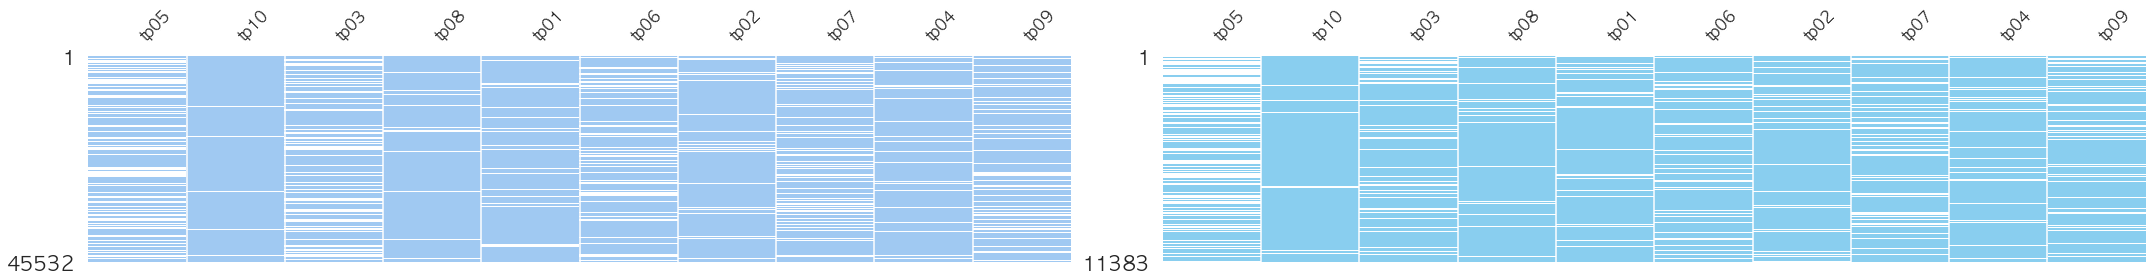

In [433]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 4))
msno.matrix(df=tdf1, color=(0.63, 0.79, 0.95), ax=axes[0])
msno.matrix(df=tdf2, color=(0.54, 0.81, 0.94), ax=axes[1])
plt.tight_layout()
plt.show()

In [434]:
tmp_df = tdf1.copy()
summary = pd.DataFrame()
for idx, name in enumerate(tmp_df.columns.values):
    tmp_summary = pd.DataFrame({'Count_val':[tmp_df[('%s' % name)].count()],
              'Count_Nan':[tmp_df[('%s' % name)].isnull().sum()],
              'Mean':[tmp_df[('%s' % name)].mean()],
              'Median':[tmp_df[('%s' % name)].median()],
              #'Mode':[tmp_df[('%s' % name)].mode()],
              'Std':[tmp_df[('%s' % name)].std()],
              'Var':[tmp_df[('%s' % name)].var()],
              'Min':[tmp_df[('%s' % name)].min()],
              '25% Q':[tmp_df[('%s' % name)].quantile(q=0.25, interpolation='linear')],
              '50% Q':[tmp_df[('%s' % name)].quantile(q=0.5, interpolation='linear')],
              '75% Q':[tmp_df[('%s' % name)].quantile(q=0.75, interpolation='linear')],
              'Max':[tmp_df[('%s' % name)].max()],
              'Skewness':[tmp_df[('%s' % name)].skew()],
              'Kurtosis':[tmp_df[('%s' % name)].kurt()]}).T
    tmp_summary.columns = [('%s' % name)]
    summary = pd.concat([summary, tmp_summary], axis = 1)
summary.round(2)

tp05      tp10      tp03      tp08      tp01      tp06  \
Count_val  29760.00  44086.00  33965.00  42348.00  40749.00  36620.00   
Count_Nan  15772.00   1446.00  11567.00   3184.00   4783.00   8912.00   
Mean           2.04      3.54      2.37      4.23      3.37      4.93   
Median         2.00      3.00      2.00      4.00      3.00      5.00   
Std            1.33      1.56      1.54      1.78      1.82      1.77   
Var            1.78      2.43      2.38      3.18      3.31      3.13   
Min            1.00      1.00      1.00      1.00      1.00      1.00   
25% Q          1.00      2.00      1.00      3.00      2.00      3.00   
50% Q          2.00      3.00      2.00      4.00      3.00      5.00   
75% Q          2.00      5.00      3.00      6.00      5.00      6.00   
Max            7.00      7.00      7.00      7.00      7.00      7.00   
Skewness       1.48      0.72      1.01      0.10      0.07     -0.42   
Kurtosis       1.77     -0.59      0.05     -1.41     -1.42     -1.16   

               tp02      tp07      tp04      tp09  
Count_val  40094.00  35721.00  40095.00  36733.00  
Count_Nan   5438.00   9811.00   5437.00   8799.00  
Mean           5.02      2.59      4.55      2.82  
Median         6.00      2.00      5.00      2.00  
Std            1.74      1.62      1.81      1.64  
Var            3.03      2.62      3.29      2.70  
Min            1.00      1.00      1.00      1.00  
25% Q          3.00      1.00      3.00      1.00  
50% Q          6.00      2.00      5.00      2.00  
75% Q          6.00      4.00      6.00      4.00  
Max            7.00      7.00      7.00      7.00  
Skewness      -0.54      0.85     -0.12      0.51  
Kurtosis      -1.06     -0.38     -1.43     -0.88

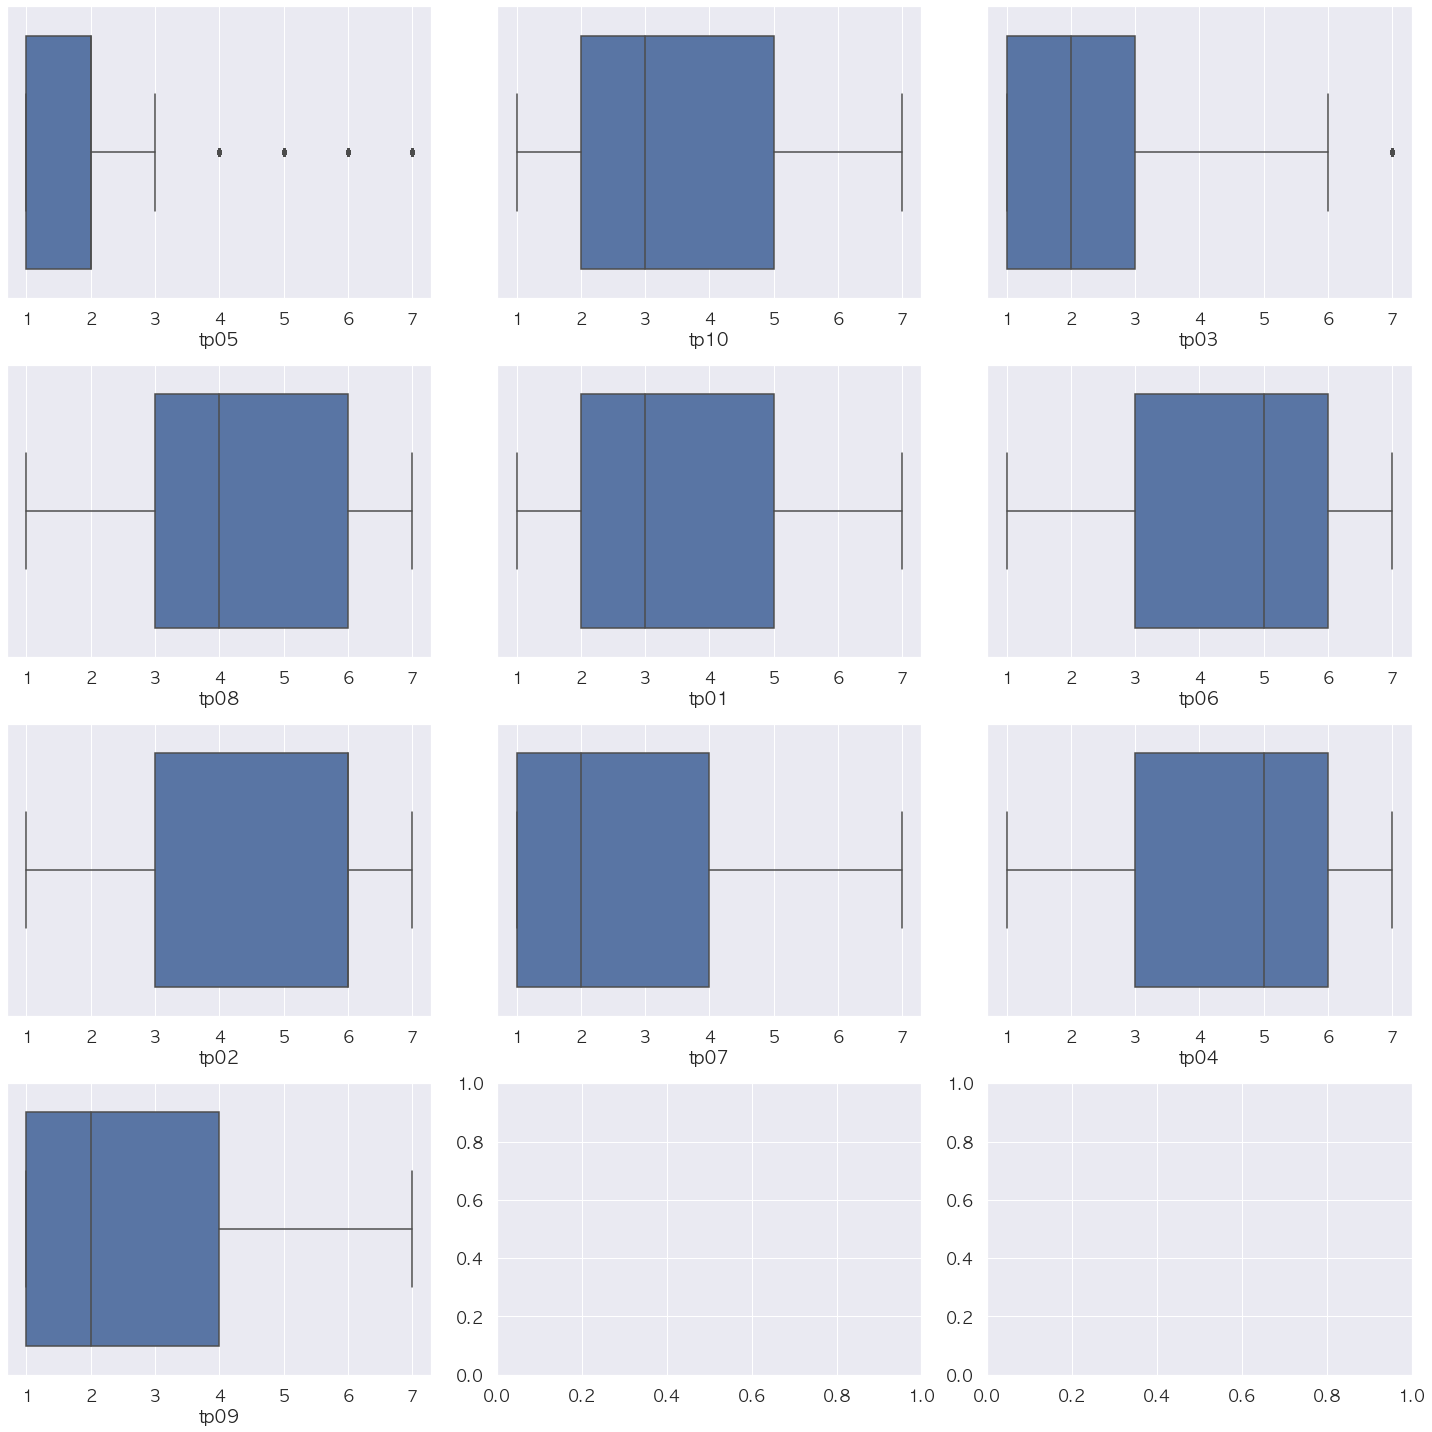

In [48]:
ax_list = []
t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])

fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])

for idx, name in enumerate(ax_list):
    if idx < len(t_col):
        sns.boxplot(x=tdf1[('%s' % (t_col[idx]))], ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()    

In [435]:
info, mask = outlier_check(tdf1, 2) # 1 = IQR method, 2 = 3sd method
info

lower      upper  min  max  counts
tp05 -1.959661   6.047497  1.0  7.0     291
tp10 -1.139763   8.220515  1.0  7.0       0
tp03 -2.255405   6.997522  1.0  7.0     361
tp08 -1.124446   9.582602  1.0  7.0       0
tp01 -2.086655   8.829446  1.0  7.0       0
tp06 -0.379133  10.231399  1.0  7.0       0
tp02 -0.197708  10.244299  1.0  7.0       0
tp07 -2.267728   7.445635  1.0  7.0       0
tp04 -0.894337   9.987042  1.0  7.0       0
tp09 -2.103358   7.749453  1.0  7.0       0

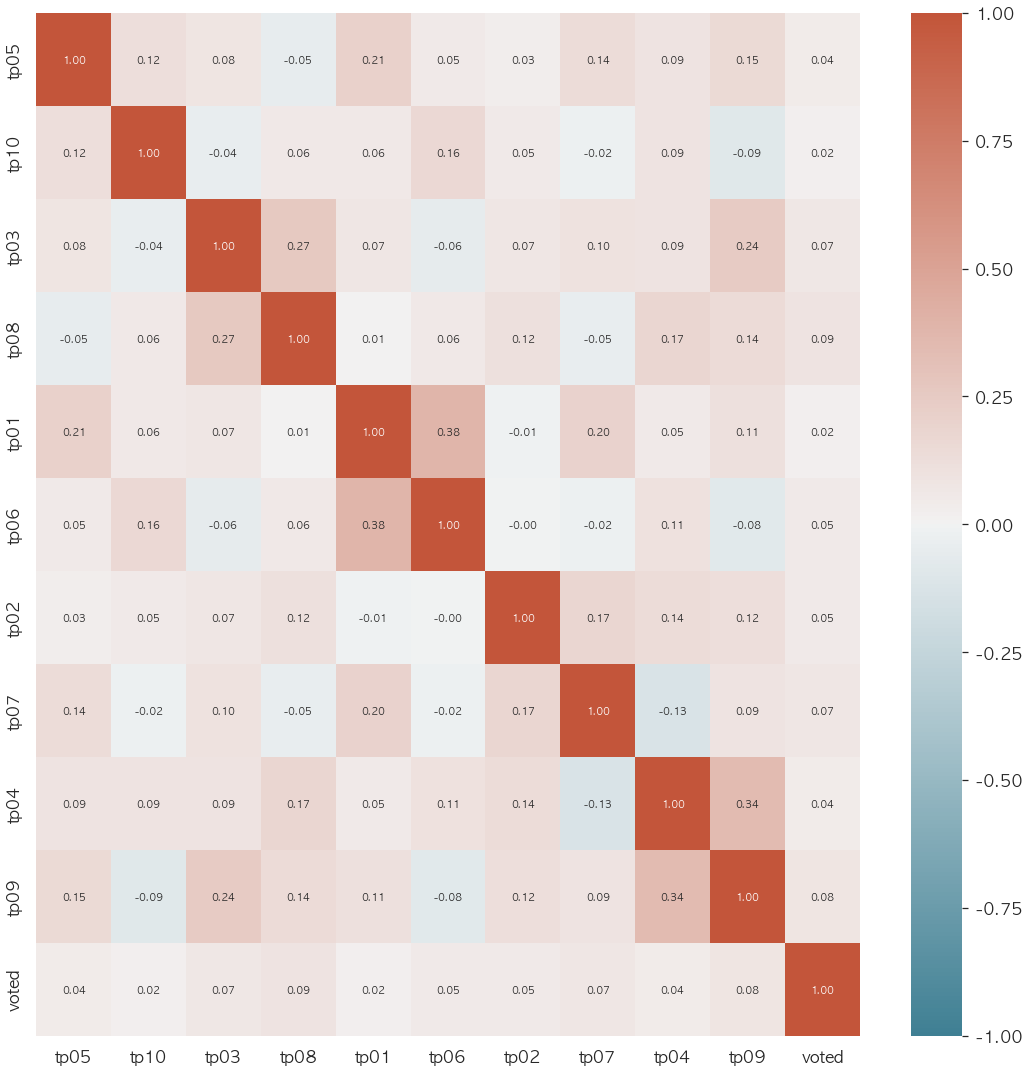

In [436]:
plt.subplots(figsize=[15,15])
sns.heatmap(pd.concat([tdf1, df_label], axis = 1).corr('spearman'),
            annot=True, fmt='.2f',
           vmin = -1, vmax =1, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.tight_layout()
plt.show()

* null 값을 대체하기 위해 두  가지 방법을 확인해본다. 

* Linear Model 활용범
    * Feature 간 선형 관계를 고려하여 간단한 linear model의 추정치로 null 값을 대체한다.
    * sklearn의 IterativeImputer를 사용한다. 이 방법은 다변량 데이터에 적합한 방법으로, 데이터에서 각 열을 y, 나머지 열을 x로 두고 설정한 모델을 적합하고, 모델에 근거하여 y 열의 결측치를 추정한다. 이러한 절차를 모든 열에 대해 반복함으로써 모든 열의 결측치를 추정하는 방법이다. 여기서 모델은 Ridge로 설정한다. (모델 설정에 따라 Linear model이 아닌 다른 방법을 사용할 수도 있다. 

<br>

* Feature 간 거리를 활용하는 방법.
    * feature 값들 간의 거리를 계산하여 결측값을 추정한다.
    * sklearn의 knnimputer를 사용한다. 이 방법 또한 다변량 데이터에 적합한 방법으로, 각 데이터 포인트 간의 거리를 계산한 후, 결측치와 가까운 데이터 포인트 n개(n_neighbors)의 평균치 혹은 가중된 평균치를 사용한다.
    from sklearn.impute import KNNImputer

In [437]:
null_col = tdf1.columns.values
ctdf1_1 = tdf1.copy()
ctdf2_1 = tdf2.copy()
ctdf1_2 = tdf1.copy()
ctdf2_2 = tdf2.copy()

In [438]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge
from sklearn.impute import KNNImputer

In [439]:
linear_imputer = IterativeImputer(estimator=Ridge())
knn_imputer = KNNImputer(n_neighbors=3, weights = 'distance')

In [440]:
ctdf1_1 = linear_imputer.fit_transform(ctdf1_1)
ctdf1_1 = pd.DataFrame(ctdf1_1)
ctdf1_1.columns = tdf1.columns.values

ctdf1_2 = knn_imputer.fit_transform(ctdf1_2)
ctdf1_2 = pd.DataFrame(ctdf1_2)
ctdf1_2.columns = tdf1.columns.values

* Linear Impute 결과

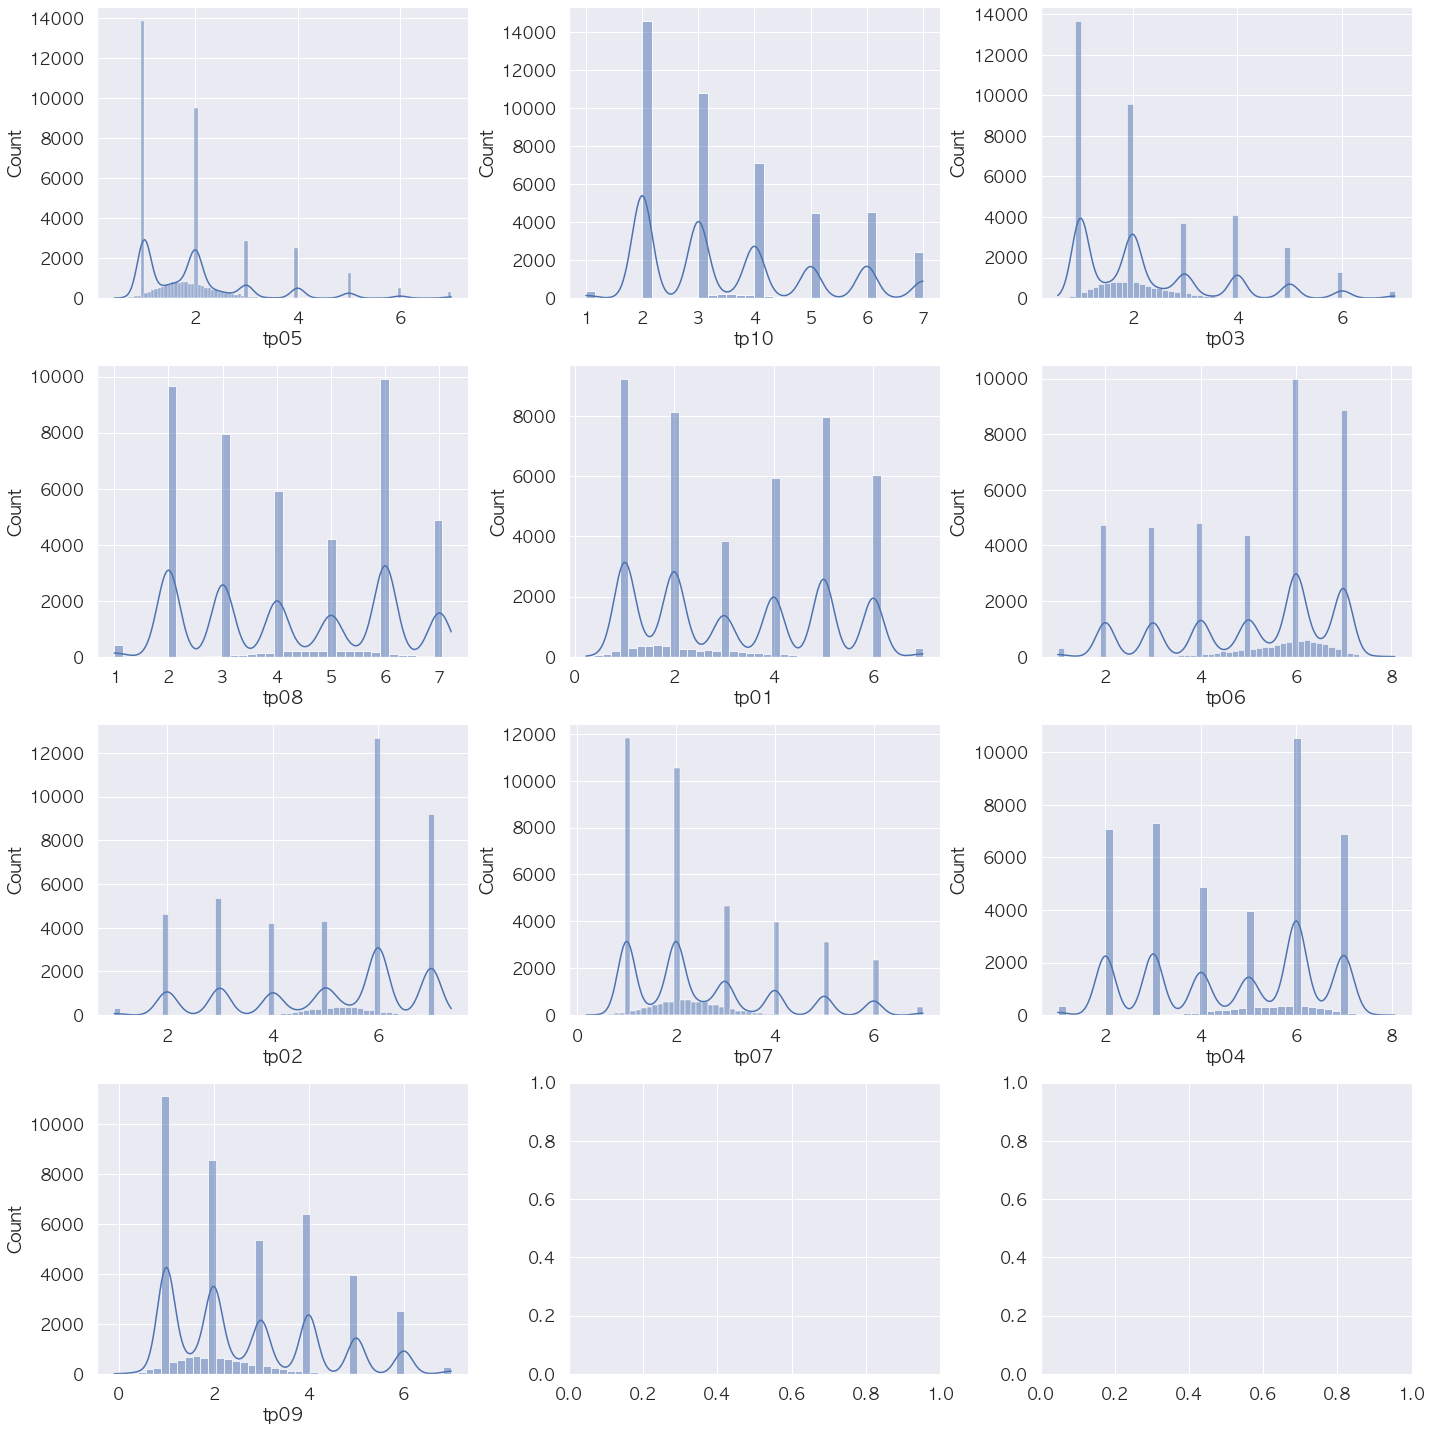

In [441]:
ax_list = []
t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])
        
fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])

for idx, name in enumerate(ax_list):
    if idx < len(t_col):
        sns.histplot(ctdf1_1[('%s' % (t_col[idx]))], kde=True, ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()

* Knn impute 결과

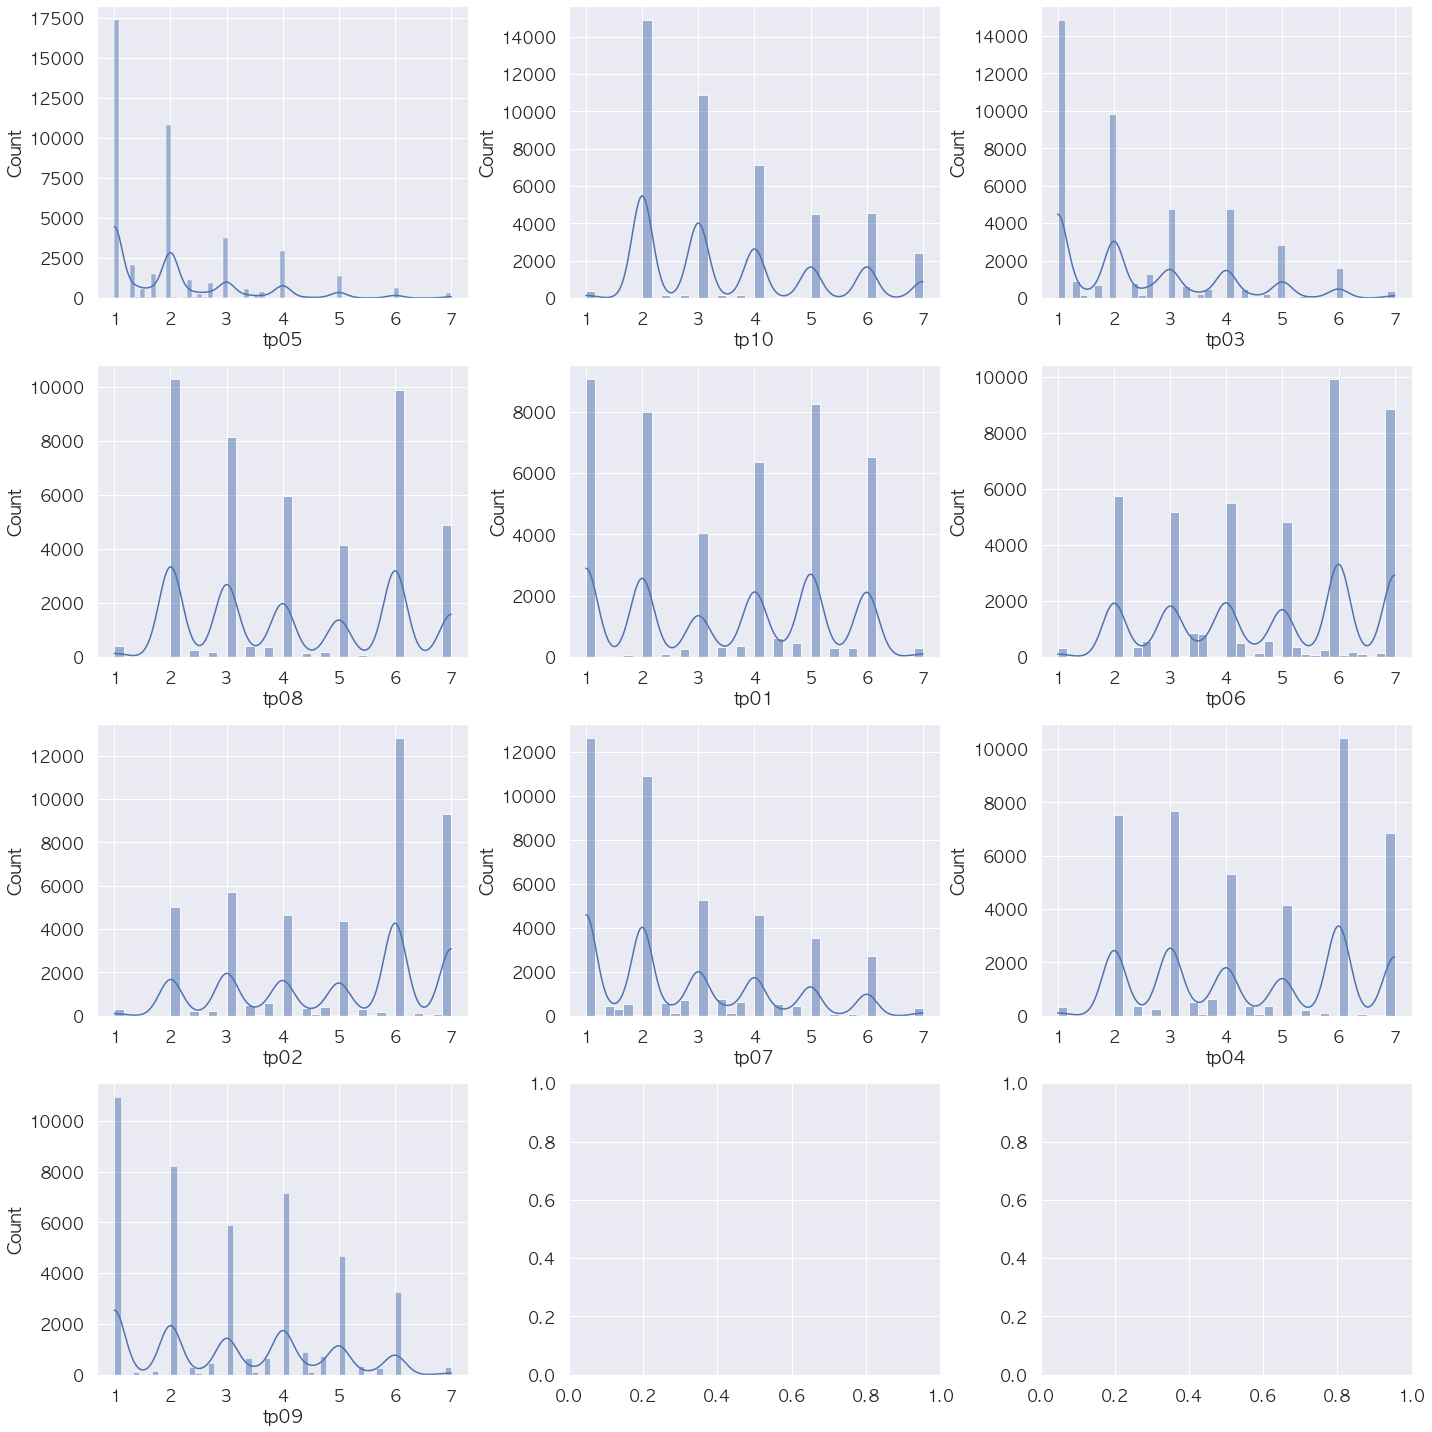

In [442]:
ax_list = []
t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])
        
fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])

for idx, name in enumerate(ax_list):
    if idx < len(t_col):
        sns.histplot(ctdf1_2[('%s' % (t_col[idx]))], kde=True, ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()

* 두 결과에서의 Feature 간 상관

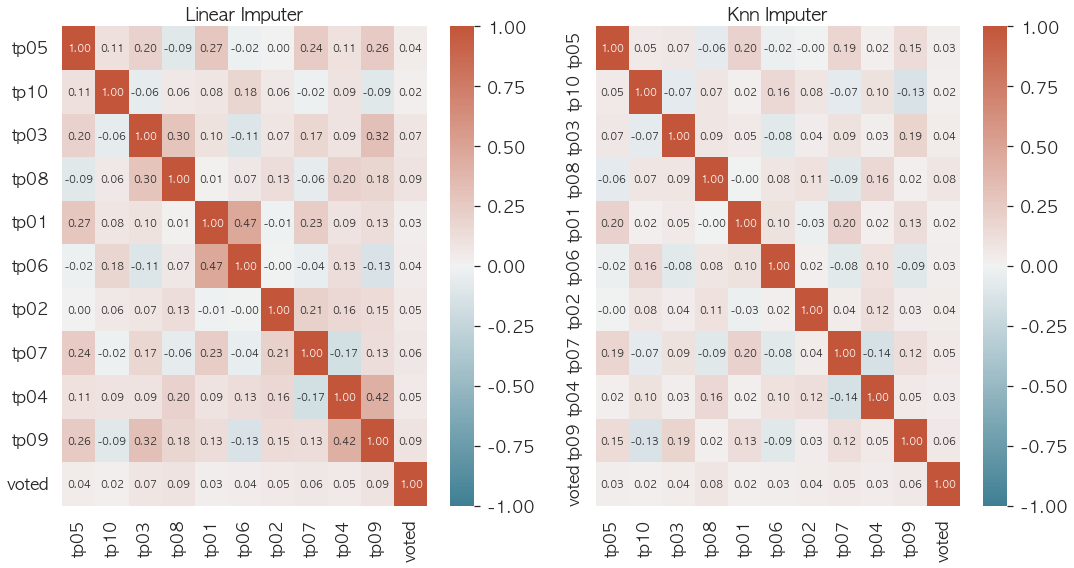

In [443]:
fig, ax = plt.subplots(ncols=2, figsize=[15,8])
g1 = sns.heatmap(pd.concat([ctdf1_1, df_label], axis = 1).corr('spearman'),
            annot=True, fmt='.2f', 
            vmin = -1, vmax =1, cmap=sns.diverging_palette(220, 20, as_cmap=True),
                ax = ax[0])
g1.set_title('Linear Imputer')
plt.tight_layout()
g2= sns.heatmap(pd.concat([ctdf1_2, df_label], axis = 1).corr('spearman'),
            annot=True, fmt='.2f', 
            vmin = -1, vmax =1, cmap=sns.diverging_palette(220, 20, as_cmap=True),
                ax = ax[1])
g2.set_title('Knn Imputer')
#plt.tight_layout()
plt.show()

* feature 간 상관 상에서는 linear imputer 가 더 좋아보인다. 보다 현실적인 값을 산출한 건 Knn Imputer이다. 이 두 방법 중 어떤 것을 선택할지는 실제 모델링 결과를 확인하여 결정하도록 한다.

In [444]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

In [445]:
ctdf_label = df_label-1
impute_name_list = ['nan', 'linear', 'knn']
impute_model_list = [tdf1.replace(np.nan, 0), ctdf1_1, ctdf1_2]

for idx, name in enumerate(impute_name_list):
    x_train, x_val, y_train, y_val = train_test_split(impute_model_list[idx], ctdf_label,
                                                      test_size=0.2,
                                                      stratify=ctdf_label,
                                                      shuffle=True,
                                                      random_state=22)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
    test_model = LogisticRegression(penalty='l2', random_state=22)

    cross_val_acc = cross_val_score(test_model, X=x_train, y=y_train, cv=cv)
    test_model.fit(x_train, y_train)

    y_val_pred = test_model.predict(x_val)
    test_acc = accuracy_score(y_val, y_val_pred)

    print('Imputer : ', name,
          '\n',
          'train acc : ', cross_val_acc*100,
          '\n',
          'test acc : ', test_acc*100)

Imputer :  nan 
 train acc :  [55.88194921 56.19766644 56.95264242 56.73301304 56.58201784] 
 test acc :  56.989129241243
Imputer :  linear 
 train acc :  [56.69183253 57.15854496 57.50171585 57.36444749 57.25463281] 
 test acc :  57.12089601405512
Imputer :  knn 
 train acc :  [55.648593   55.89567605 55.97803706 56.48592999 55.68977351] 
 test acc :  56.18754803996926


* 두 방법 모두 큰 차이는 없어보인다. 하지만 Linear가 조금 더 우수하므로 linear Imputer의 결과를 사용해보자.

In [446]:
ctdf2_1 = linear_imputer.transform(ctdf2_1)
ctdf2_1 = pd.DataFrame(ctdf2_1)
ctdf2_1.columns = tdf2.columns.values
# ctdf2_2 = knn_imputer.transform(ctdf2_2)
# ctdf2_2 = pd.DataFrame(ctdf2_2)
# ctdf2_2.columns = tdf2.columns.values

In [447]:
df_tipi_train = ctdf1_1.copy()
df_tipi_test = ctdf1_2.copy()

 * TIPI 점수도 각각의 Feature 간 결합으로 구인을 구성한다. 
 * 구인에 따라 점수를 종합해준다. 

In [450]:
df_tipi_train['tipi_o'] = df_tipi_train[tipi_O].mean(axis=1)
df_tipi_train['tipi_c'] = df_tipi_train[tipi_C].mean(axis=1)
df_tipi_train['tipi_e'] = df_tipi_train[tipi_E].mean(axis=1)
df_tipi_train['tipi_a'] = df_tipi_train[tipi_A].mean(axis=1)
df_tipi_train['tipi_n'] = df_tipi_train[tipi_N].mean(axis=1)


df_tipi_test['tipi_o'] = df_tipi_test[tipi_O].mean(axis=1)
df_tipi_test['tipi_c'] = df_tipi_test[tipi_C].mean(axis=1)
df_tipi_test['tipi_e'] = df_tipi_test[tipi_E].mean(axis=1)
df_tipi_test['tipi_a'] = df_tipi_test[tipi_A].mean(axis=1)
df_tipi_test['tipi_n'] = df_tipi_test[tipi_N].mean(axis=1)

In [451]:
df_tipi_train.shape, df_tipi_test.shape

((45532, 15), (45532, 15))

* 테스트셋까지 변환이 완료되었다.

#### Demographics

In [541]:
tdf1 = df_train[demog]
tdf2 = df_test[demog]

In [542]:
tdf1.head(3)

age_group  education  engnat  familysize  gender  hand  married   race  \
0       30s          2       1         4.0  Female     1        3  White   
1       20s          4       2         3.0  Female     1        1  Asian   
2       30s          3       1         3.0    Male     1        2  White   

  religion  urban  
0    Other      1  
1    Hindu      3  
2    Other      2

* 결측치는 관찰되지 않는다.

In [543]:
tdf1.isnull().sum().sum(), tdf2.isnull().sum().sum()

(0, 0)

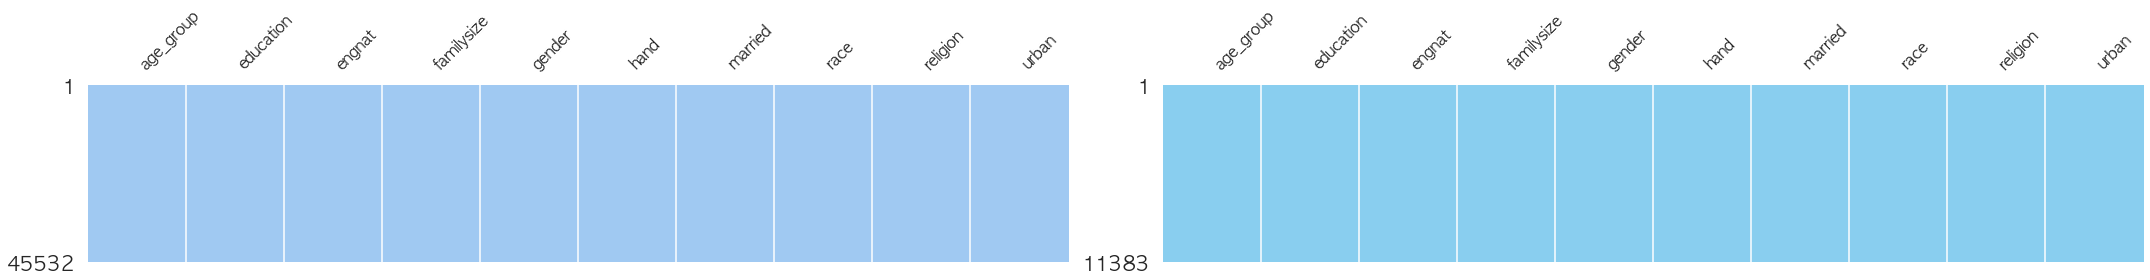

In [544]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 4))
msno.matrix(df=tdf1, color=(0.63, 0.79, 0.95), ax=axes[0])
msno.matrix(df=tdf2, color=(0.54, 0.81, 0.94), ax=axes[1])
plt.tight_layout()
plt.show()

##### Age

* Age는 범주형 변수이며 서열의 의미를 가진다

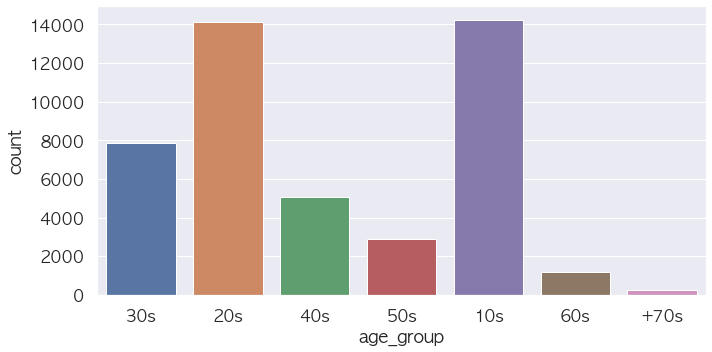

In [545]:
plt.subplots(figsize=[10,5])
sns.countplot(x=tdf1.age_group)
plt.tight_layout()
plt.show()

* 60대 이상의 count가 적다. crosstab으로 voting 과의 관계를 보고, 차이가 없다면 그룹을 통일하자

In [546]:
tmp_tb = pd.crosstab(df_label.voted, tdf1.age_group, margins = False)
tmp_tb_p = pd.crosstab(df_label.voted, tdf1.age_group, margins = False, normalize='index')
tmp_tb

age_group  +70s    10s   20s   30s   40s   50s  60s
voted                                              
1           173   2314  7484  4614  3243  1936  870
2            62  11901  6628  3222  1808   953  324

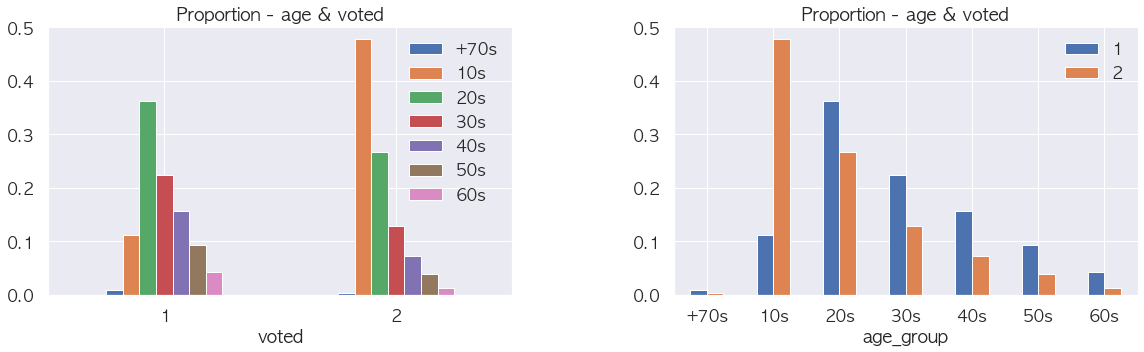

In [547]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
g1 = tmp_tb_p.plot.bar(rot=0, ax=axes[0])
g1.legend(bbox_to_anchor=(1.0, 1.0))
axes[0].set_title('Proportion - age & voted')
g2 = tmp_tb_p.T.plot.bar(rot=0, ax=axes[1])
g2.legend(bbox_to_anchor=(1.0, 1.0))
axes[1].set_title('Proportion - age & voted')
plt.tight_layout()
plt.show()

* 60대와 70대 모두 vote 1 이 높다. 따라서 두 집단을 통일한다.

In [548]:
tdf1.age_group = tdf1.age_group.replace('+70s','+60s')
tdf1.age_group = tdf1.age_group.replace('60s','+60s')
tdf2.age_group = tdf2.age_group.replace('+70s','+60s')
tdf2.age_group = tdf2.age_group.replace('60s','+60s')

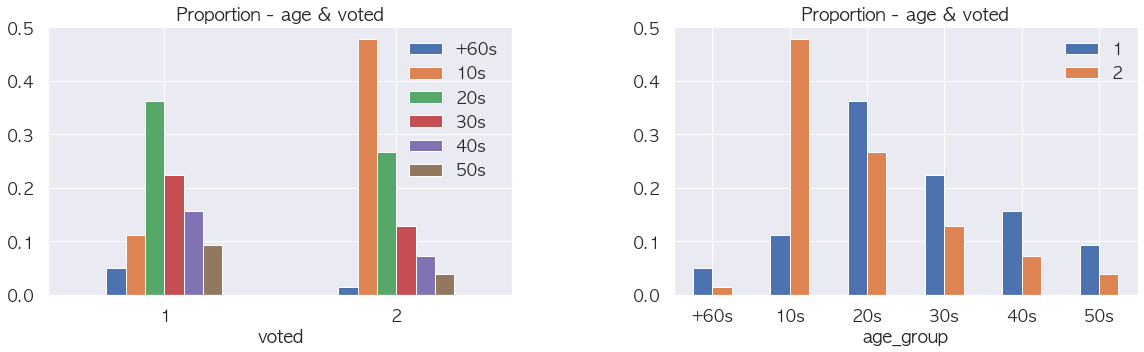

In [549]:
tmp_tb_p = pd.crosstab(df_label.voted, tdf1.age_group, margins = False, normalize='index')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
g1 = tmp_tb_p.plot.bar(rot=0, ax=axes[0])
g1.legend(bbox_to_anchor=(1.0, 1.0))
axes[0].set_title('Proportion - age & voted')
g2 = tmp_tb_p.T.plot.bar(rot=0, ax=axes[1])
g2.legend(bbox_to_anchor=(1.0, 1.0))
axes[1].set_title('Proportion - age & voted')
plt.tight_layout()
plt.show()

* 연령 그룹에 따라 voting behaviour의 차이가 관찰된다.

##### Education

* education은 범주형 변수이며 서열의 의미를 가진다
* 1=Less than high school, 2=High school, 3=University degree, 4=Graduate degree, 0=무응답

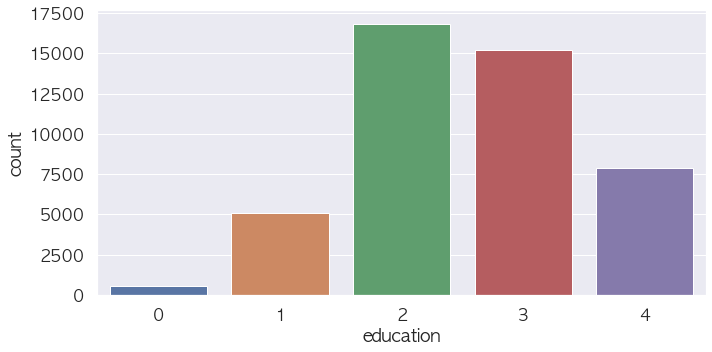

In [461]:
plt.subplots(figsize=[10,5])
sns.countplot(x=tdf1.education)
plt.tight_layout()
plt.show()

* Education 0의 빈도가 매우 적다.

In [462]:
tmp_tb = pd.crosstab(df_label.voted, tdf1.education, margins = False)
tmp_tb_p = pd.crosstab(df_label.voted, tdf1.education, margins = False, normalize='index')
tmp_tb

education    0     1      2     3     4
voted                                  
1          252   253   6179  9083  4867
2          276  4835  10656  6144  2987

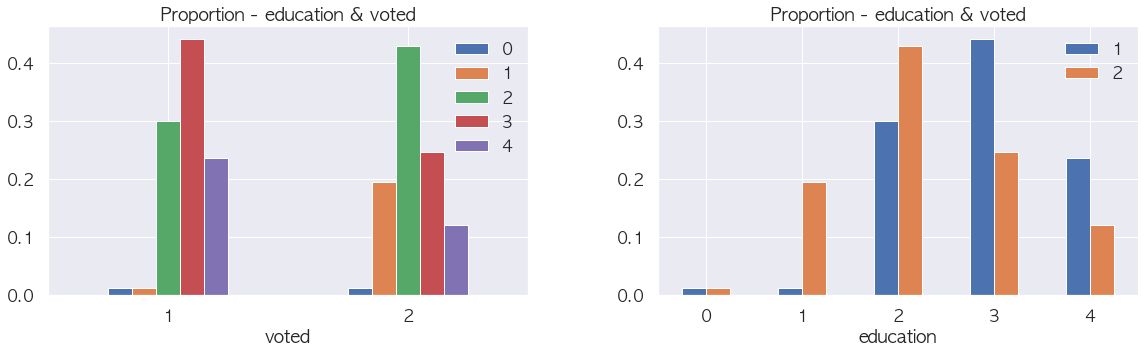

In [463]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
g1 = tmp_tb_p.plot.bar(rot=0, ax=axes[0])
g1.legend(bbox_to_anchor=(1.0, 1.0))
axes[0].set_title('Proportion - education & voted')
g2 = tmp_tb_p.T.plot.bar(rot=0, ax=axes[1])
g2.legend(bbox_to_anchor=(1.0, 1.0))
axes[1].set_title('Proportion - education & voted')
plt.tight_layout()
plt.show()

* Education 0은 무응답이다. 앞선 성격 문항처럼 impute할 수도 있지만 무응답을 하나의 특성으로 본다면 impute가 적절하지 않을 수도 있다. 만약 demographic 변수들 간 체계적인 관계가 있다면 imputer를 고려해보자. 일단 전체 변수를 각각 확인해보고, 변수 간 관계를 확인해본 후 결정한다.
* 다른 Education 항목들도 vote와 관련성이 있어보인다. 

##### engnat

* engnat은 모국어가 영어인지를 나타내는 범주형 변수이며 명목형 특성을 가진다.
* 1=Yes, 2=No, 0=무응답

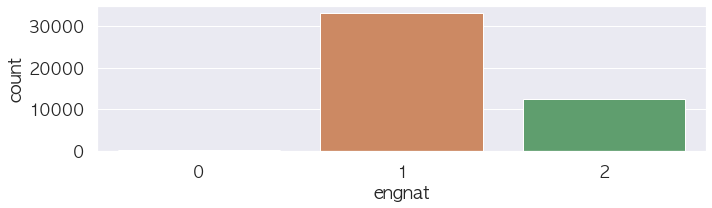

In [464]:
plt.subplots(figsize=[10,3])
sns.countplot(x=tdf1.engnat)
plt.tight_layout()
plt.show()

In [465]:
tdf1.engnat.value_counts()

1    33024
2    12431
0       77
Name: engnat, dtype: int64

* 마찬가지로 0값이 매우 적다

In [466]:
tmp_tb = pd.crosstab(df_label.voted, tdf1.engnat, margins = False)
tmp_tb_p = pd.crosstab(df_label.voted, tdf1.engnat, margins = False, normalize='index')
tmp_tb

engnat   0      1     2
voted                  
1       29  15277  5328
2       48  17747  7103

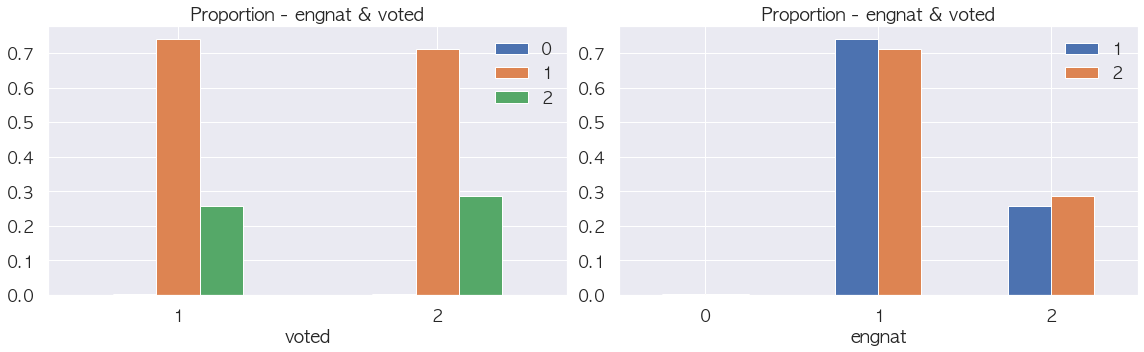

In [467]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
g1 = tmp_tb_p.plot.bar(rot=0, ax=axes[0])
g1.legend(bbox_to_anchor=(1.0, 1.0))
axes[0].set_title('Proportion - engnat & voted')
g2 = tmp_tb_p.T.plot.bar(rot=0, ax=axes[1])
g2.legend(bbox_to_anchor=(1.0, 1.0))
axes[1].set_title('Proportion - engnat & voted')
plt.tight_layout()
plt.show()

* 0값은 education과 마찬가지의 방법으로 추후 확인한다.
* 상호작용의 그래프 패턴이 관찰되지만 voting과 강한 관련성이 있는 것 같아 보이진 않는다.

##### familysize

* 해당 변수는 형제 자매의 수를 나타내며 범주형 변수가 아니다

In [468]:
tmp_df = pd.DataFrame(tdf1['familysize'])
summary = pd.DataFrame()
for idx, name in enumerate(tmp_df.columns.values):
    tmp_summary = pd.DataFrame({'Count_val':[tmp_df[('%s' % name)].count()],
              'Count_Nan':[tmp_df[('%s' % name)].isnull().sum()],
              'Mean':[tmp_df[('%s' % name)].mean()],
              'Median':[tmp_df[('%s' % name)].median()],
              #'Mode':[tmp_df[('%s' % name)].mode()],
              'Std':[tmp_df[('%s' % name)].std()],
              'Var':[tmp_df[('%s' % name)].var()],
              'Min':[tmp_df[('%s' % name)].min()],
              '25% Q':[tmp_df[('%s' % name)].quantile(q=0.25, interpolation='linear')],
              '50% Q':[tmp_df[('%s' % name)].quantile(q=0.5, interpolation='linear')],
              '75% Q':[tmp_df[('%s' % name)].quantile(q=0.75, interpolation='linear')],
              'Max':[tmp_df[('%s' % name)].max()],
              'Skewness':[tmp_df[('%s' % name)].skew()],
              'Kurtosis':[tmp_df[('%s' % name)].kurt()]}).T
    tmp_summary.columns = [('%s' % name)]
    summary = pd.concat([summary, tmp_summary], axis = 1)
summary.astype('int').round(2)

familysize
Count_val            45532
Count_Nan                0
Mean                 47166
Median                   2
Std               10064020
Var        101284503269673
Min                      0
25% Q                    2
50% Q                    2
75% Q                    3
Max             2147483647
Skewness               213
Kurtosis             45531

* 과도하게 값이 큰 이상치가 관찰된다. 

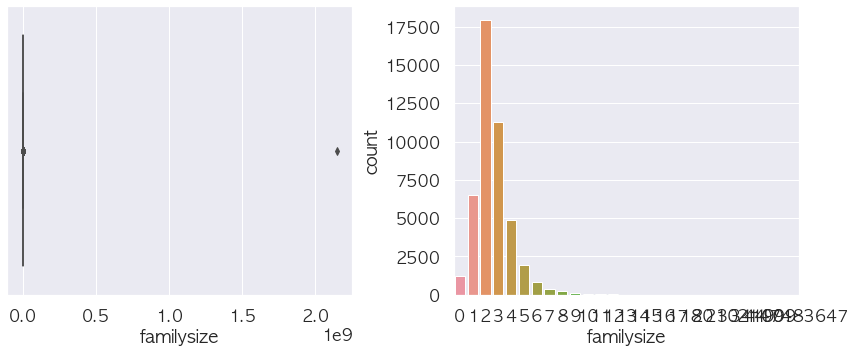

In [469]:
fig, ax = plt.subplots(ncols=2, figsize=[12,5])
sns.boxplot(tdf1['familysize'], ax = ax[0])
sns.countplot(x=tdf1.familysize, ax = ax[1])
#sns.kdeplot(tdf1['familysize'], ax = ax[1])
plt.tight_layout()
plt.show()

In [470]:
info, mask = outlier_check(pd.DataFrame(tdf1['familysize']), 1)

In [471]:
info

lower  upper  min         max  counts
familysize    0.5    3.5    0  2147483647    9823

In [472]:
tdf1.loc[np.where(mask == True)[0],:].familysize.value_counts()

4             4907
5             1962
0             1217
6              838
7              387
8              221
9              126
10              59
11              39
12              21
13              11
14               9
15               8
44               3
17               3
21               2
20               2
16               2
999              1
2147483647       1
100              1
34               1
30               1
18               1
Name: familysize, dtype: int64

* 비현실적인 값들이 관찰된다. mach RT와 같이 비현실적인 값들을 numpy clip을 활용해 조정해준다. 기준은 0.99로 설정해준다. 

In [473]:
tmp_faml = pd.DataFrame(tdf1.loc[:,'familysize']).apply(lambda x: x.clip(x.quantile(.00), x.quantile(.99)))

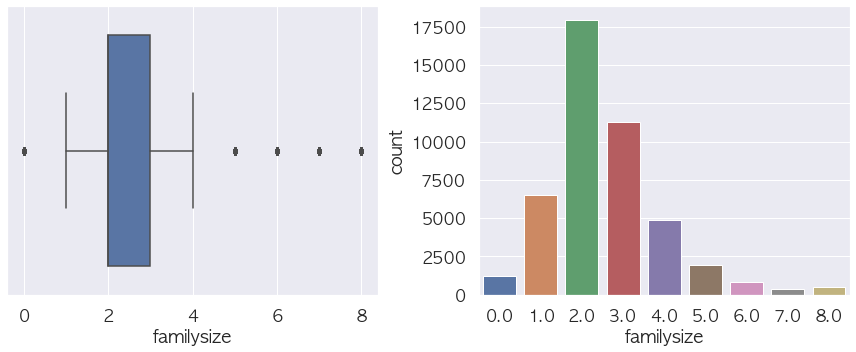

In [474]:
fig, ax = plt.subplots(ncols=2, figsize=[12,5])
sns.boxplot(tmp_faml.familysize, ax = ax[0])
sns.countplot(x=tmp_faml.familysize, ax = ax[1])
#sns.kdeplot(tdf1['familysize'], ax = ax[1])
plt.tight_layout()
plt.show()

In [475]:
tdf1.familysize = tmp_faml

In [476]:
tdf2.familysize.value_counts()

2     4454
3     2836
1     1679
4     1237
5      495
0      287
6      185
7       97
8       51
9       28
10      18
11       6
12       6
23       1
15       1
14       1
20       1
Name: familysize, dtype: int64

* 처리는 완료되었다. Target 과의 관계를 살펴보자.

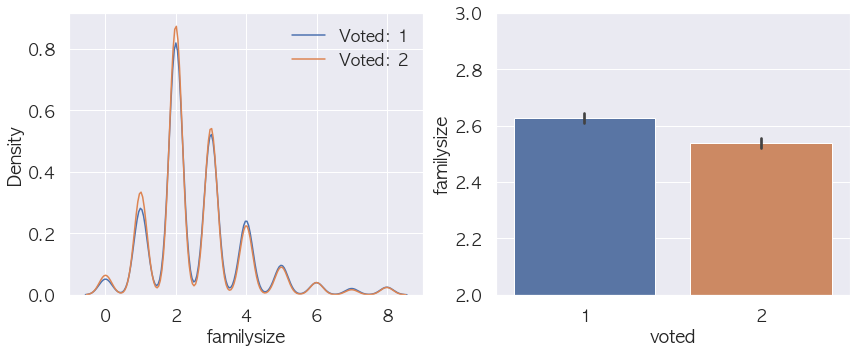

In [477]:
fig, ax = plt.subplots(1, 2, figsize=[12,5])
g1=sns.kdeplot(tdf1[df_label['voted'] == 1]['familysize'], ax=ax[0])
g1=sns.kdeplot(tdf1[df_label['voted'] == 2]['familysize'], ax=ax[0])
g1.legend(['Voted: 1', 'Voted: 2'], bbox_to_anchor=(1.0, 1.0))
g2 = sns.barplot(y=tdf1.familysize, x=df_label.voted, ax = ax[1])
g2.set_ylim([2, 3])
plt.tight_layout()
plt.show()

* Vote 1인 경우가 더 가족수가 많은 것으로 보인다. 

In [478]:
df_train['familysize'] = tdf1.familysize

##### Gender

* gender는 범주형 변수이며 명목형 특성을 가진다.

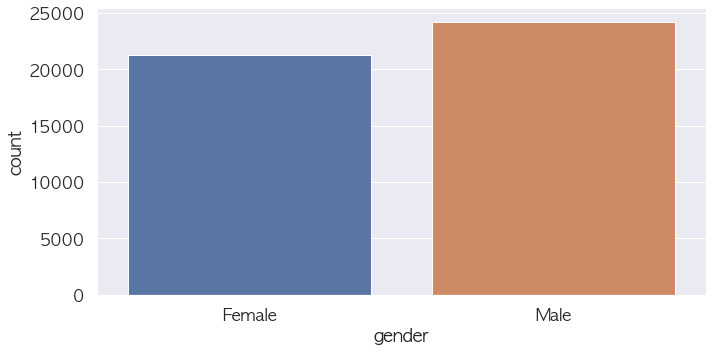

In [479]:
plt.subplots(figsize=[10,5])
sns.countplot(x=tdf1.gender)
plt.tight_layout()
plt.show()

In [480]:
tmp_tb = pd.crosstab(df_label.voted, tdf1.gender, margins = False)
tmp_tb_p = pd.crosstab(df_label.voted, tdf1.gender, margins = False, normalize='index')
tmp_tb

gender  Female   Male
voted                
1         9814  10820
2        11501  13397

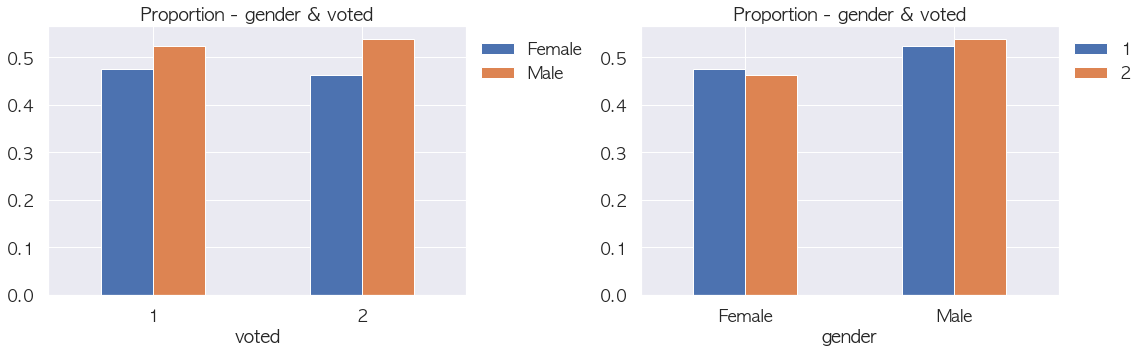

In [481]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
g1 = tmp_tb_p.plot.bar(rot=0, ax=axes[0])
g1.legend(bbox_to_anchor=(1.0, 1.0))
axes[0].set_title('Proportion - gender & voted')
g2 = tmp_tb_p.T.plot.bar(rot=0, ax=axes[1])
g2.legend(bbox_to_anchor=(1.0, 1.0))
axes[1].set_title('Proportion - gender & voted')
plt.tight_layout()
plt.show()

* vote 와 약한 관계가 있어보인다. 

##### Hand

* Hand 는 필기하는 손을 나타내는 범주형 변수이며 명목형 특성을 가진다. 
* 1=Right, 2=Left, 3=Both, 0=무응답

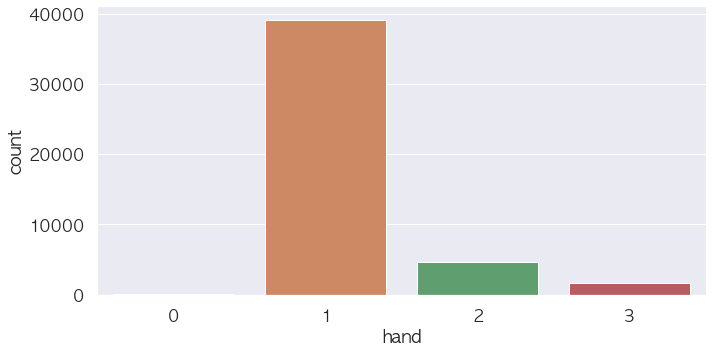

In [482]:
plt.subplots(figsize=[10,5])
sns.countplot(x=tdf1.hand)
plt.tight_layout()
plt.show()

In [483]:
tdf1.hand.value_counts()

1    39058
2     4692
3     1621
0      161
Name: hand, dtype: int64

* 무응답이 일부 관찰된다. 

In [484]:
tmp_tb = pd.crosstab(df_label.voted, tdf1.hand, margins = False)
tmp_tb_p = pd.crosstab(df_label.voted, tdf1.hand, margins = False, normalize='index')
tmp_tb

hand     0      1     2    3
voted                       
1       59  17759  2156  660
2      102  21299  2536  961

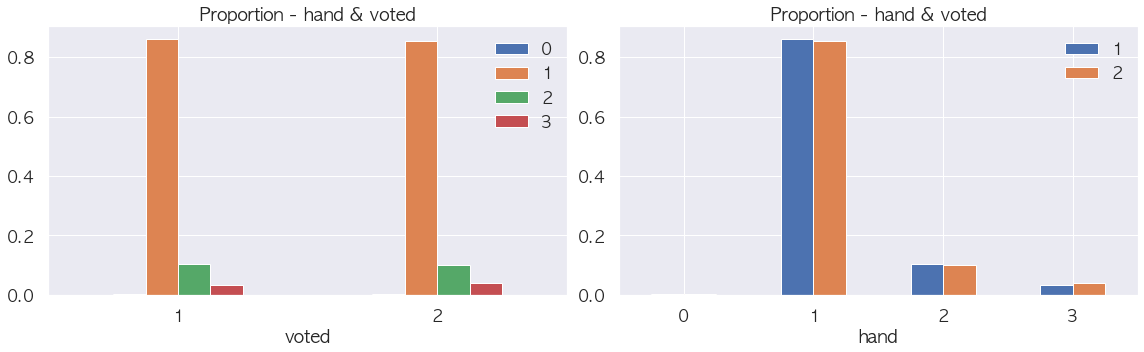

In [485]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
g1 = tmp_tb_p.plot.bar(rot=0, ax=axes[0])
g1.legend(bbox_to_anchor=(1.0, 1.0))
axes[0].set_title('Proportion - hand & voted')
g2 = tmp_tb_p.T.plot.bar(rot=0, ax=axes[1])
g2.legend(bbox_to_anchor=(1.0, 1.0))
axes[1].set_title('Proportion - hand & voted')
plt.tight_layout()
plt.show()

* vote와 특별한 관계가 관찰되진 않는다.
* 무응답의 처리는 추후 재확인한다.

##### Married

* Married는 결혼 여부를 나타내는 범주형 변수이며 명목형 특성을 가진다.
* 1=Never married, 2=Currently married, 3=Previously married, 0=Other

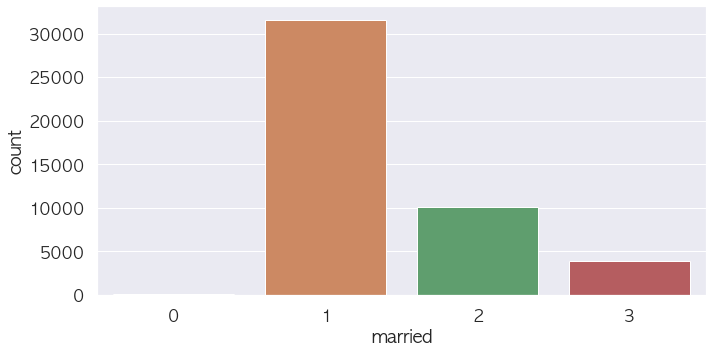

In [486]:
plt.subplots(figsize=[10,5])
sns.countplot(x=tdf1.married)
plt.tight_layout()
plt.show()

In [487]:
tdf1.married.value_counts()

1    31550
2    10059
3     3830
0       93
Name: married, dtype: int64

In [488]:
tmp_tb = pd.crosstab(df_label.voted, tdf1.married, margins = False)
tmp_tb_p = pd.crosstab(df_label.voted, tdf1.married, margins = False, normalize='index')
tmp_tb

married   0      1     2     3
voted                         
1        30  11687  6705  2212
2        63  19863  3354  1618

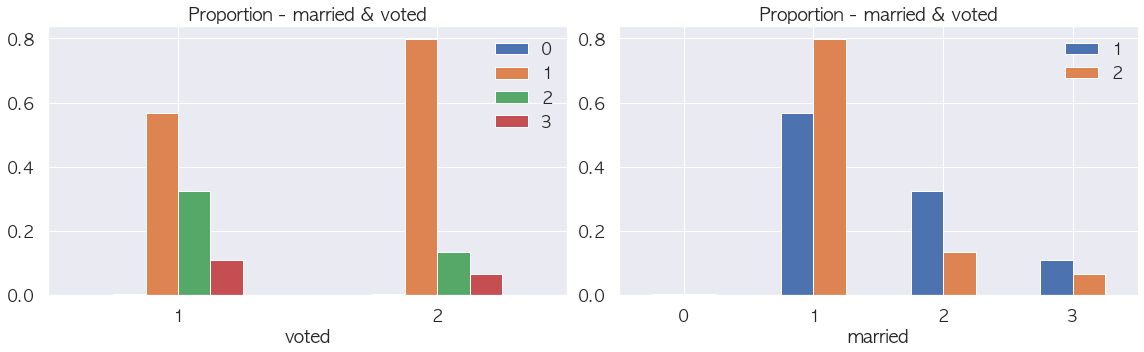

In [489]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
g1 = tmp_tb_p.plot.bar(rot=0, ax=axes[0])
g1.legend(bbox_to_anchor=(1.0, 1.0))
axes[0].set_title('Proportion - married & voted')
g2 = tmp_tb_p.T.plot.bar(rot=0, ax=axes[1])
g2.legend(bbox_to_anchor=(1.0, 1.0))
axes[1].set_title('Proportion - married & voted')

plt.tight_layout()
plt.show()

* Vote 와의 관련성이 있는 것으로 보인다. 
* 무응답의 처리는 추후 재확인한다.

##### Race

* Race는 인종을 나타내는 범주형 변수이며. 명목형 특성을 가진다.
* Asian, Arab, Black, Indigenous Australian, Native American, White, Other

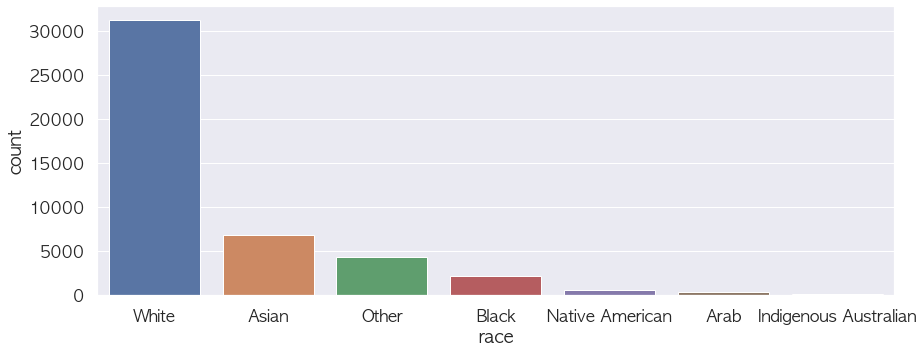

In [490]:
plt.subplots(figsize=[13,5])
sns.countplot(x=tdf1.race)
plt.tight_layout()
plt.show()

In [491]:
tdf1.race.value_counts()

White                    31248
Asian                     6834
Other                     4330
Black                     2168
Native American            548
Arab                       351
Indigenous Australian       53
Name: race, dtype: int64

In [492]:
tmp_tb = pd.crosstab(df_label.voted, tdf1.race, margins = False)
tmp_tb_p = pd.crosstab(df_label.voted, tdf1.race, margins = False, normalize='index')
tmp_tb

race   Arab  Asian  Black  Indigenous Australian  Native American  Other  \
voted                                                                      
1       102   2019    872                     24              226   1635   
2       249   4815   1296                     29              322   2695   

race   White  
voted         
1      15756  
2      15492

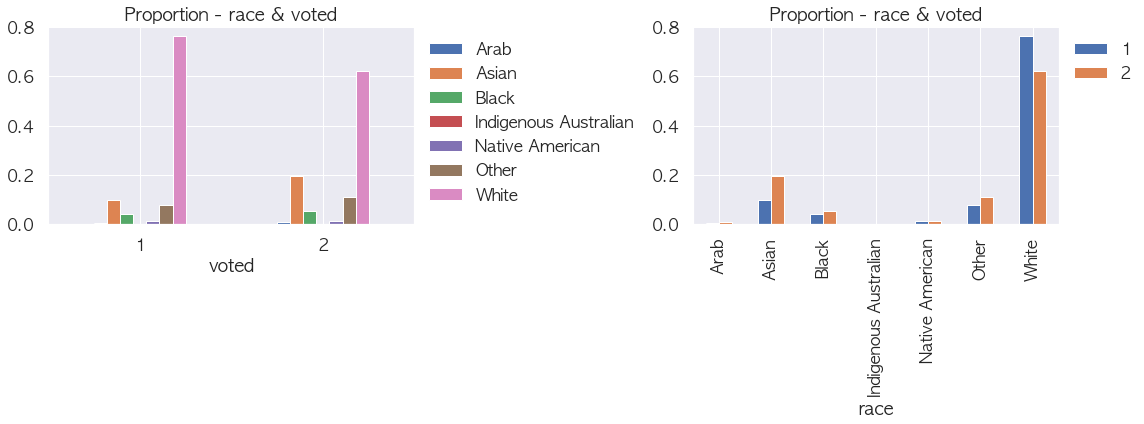

In [493]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
g1 = tmp_tb_p.plot.bar(rot=0, ax=axes[0])
g1.legend(bbox_to_anchor=(1.0, 1.0))
axes[0].set_title('Proportion - race & voted')
g2 = tmp_tb_p.T.plot.bar(rot=90, ax=axes[1])
g2.legend(bbox_to_anchor=(1.0, 1.0))
axes[1].set_title('Proportion - race & voted')

plt.tight_layout()
plt.show()

* race는 vote와 관련성이 있는 것으로 보인다. 
* 빈도수가 적은 값의 처리는 추후 재확인한다.

##### Religion

* Regligion은 종교를 나타내는 범주형 변수이며, 명목형 특성을 가진다. 
* Agnostic, Atheist, Buddhist, Christian_Catholic, Christian_Mormon, Christian_Protestant, Christian_Other, Hindu, Jewish, Muslim, Sikh, Other


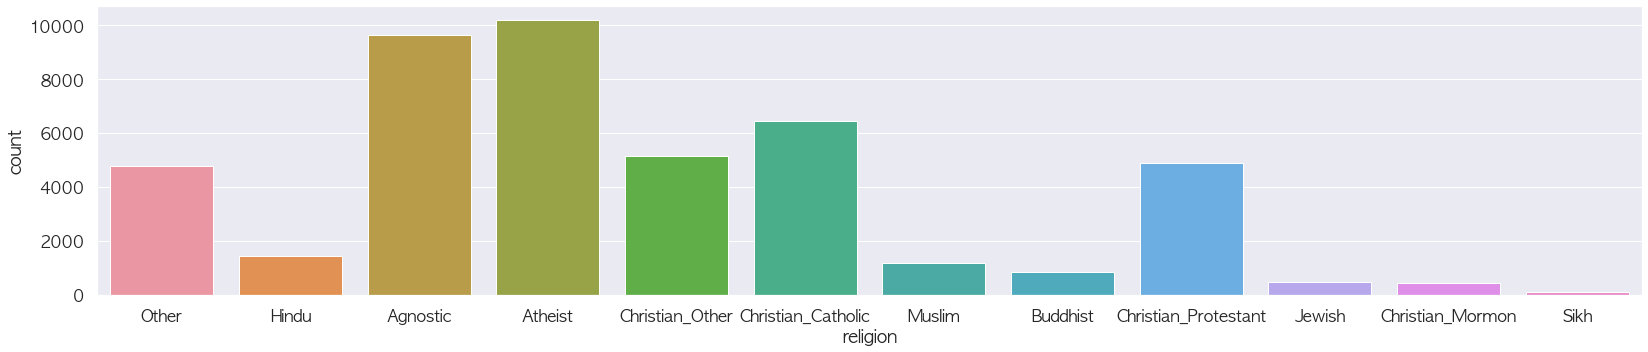

In [494]:
plt.subplots(figsize=[23,5])
sns.countplot(x=tdf1.religion)
plt.tight_layout()
plt.show()

In [495]:
tdf1.religion.value_counts()

Atheist                 10192
Agnostic                 9624
Christian_Catholic       6431
Christian_Other          5137
Christian_Protestant     4875
Other                    4770
Hindu                    1429
Muslim                   1192
Buddhist                  850
Jewish                    487
Christian_Mormon          428
Sikh                      117
Name: religion, dtype: int64

In [496]:
tmp_tb = pd.crosstab(df_label.voted, tdf1.religion, margins = False)
tmp_tb_p = pd.crosstab(df_label.voted, tdf1.religion, margins = False, normalize='index')
tmp_tb

religion  Agnostic  Atheist  Buddhist  Christian_Catholic  Christian_Mormon  \
voted                                                                         
1             4402     4355       322                3045               163   
2             5222     5837       528                3386               265   

religion  Christian_Other  Christian_Protestant  Hindu  Jewish  Muslim  Other  \
voted                                                                           
1                    2365                  2756    553     268     373   1990   
2                    2772                  2119    876     219     819   2780   

religion  Sikh  
voted           
1           42  
2           75

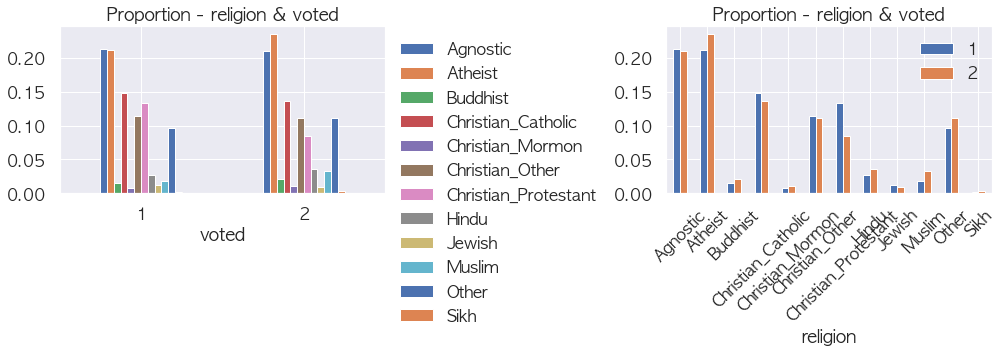

In [497]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
g1 = tmp_tb_p.plot.bar(rot=0, ax=axes[0])
g1.legend(bbox_to_anchor=(1.0, 1.0))
axes[0].set_title('Proportion - religion & voted')
g2 = tmp_tb_p.T.plot.bar(rot=45, ax=axes[1])
g2.legend(bbox_to_anchor=(1.0, 1.0))
axes[1].set_title('Proportion - religion & voted')

plt.tight_layout()
plt.show()

##### Urban

* Urban은 유년기의 거주 구역을 나타내는 범주형 변수이며 명목형 특성을 가진다. 
* 1=Rural (country side), 2=Suburban, 3=Urban (town, city), 0=무응답

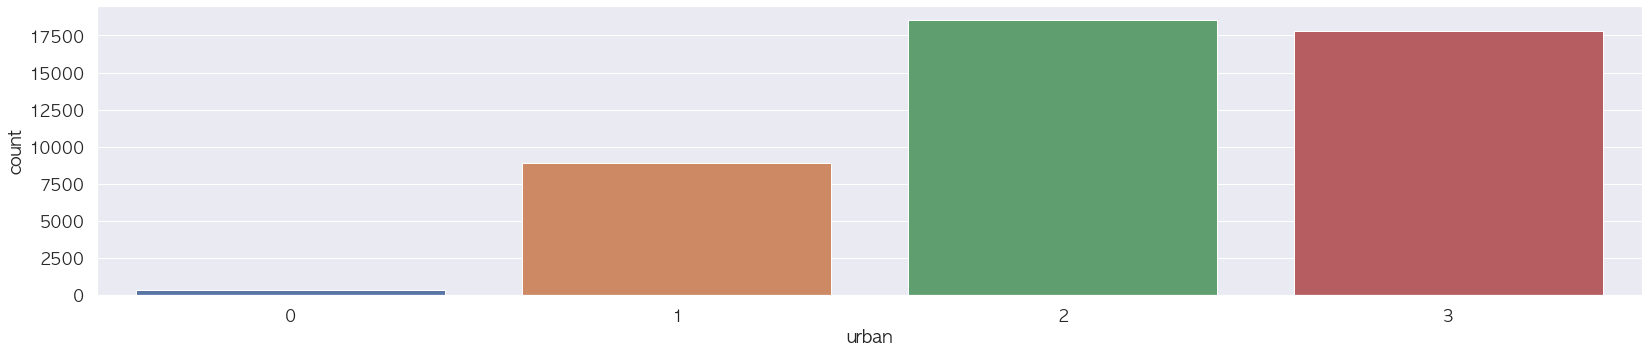

In [498]:
plt.subplots(figsize=[23,5])
sns.countplot(x=tdf1.urban)
plt.tight_layout()
plt.show()

In [499]:
tdf1.urban.value_counts()

2    18534
3    17767
1     8909
0      322
Name: urban, dtype: int64

In [500]:
tmp_tb = pd.crosstab(df_label.voted, tdf1.urban, margins = False)
tmp_tb_p = pd.crosstab(df_label.voted, tdf1.urban, margins = False, normalize='index')
tmp_tb

urban    0     1      2      3
voted                         
1      164  4518   8497   7455
2      158  4391  10037  10312

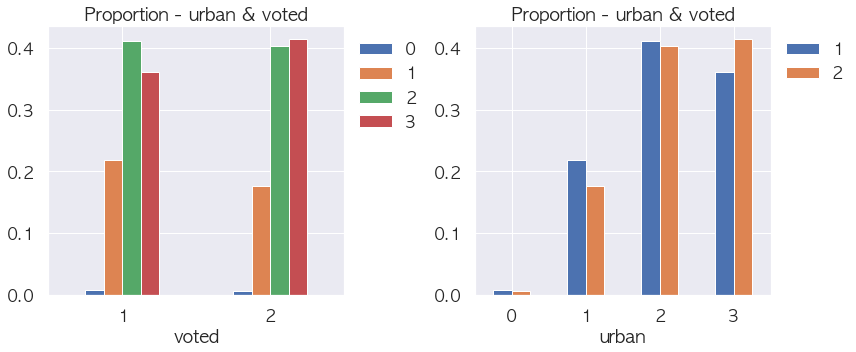

In [501]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
g1 = tmp_tb_p.plot.bar(rot=0, ax=axes[0])
g1.legend(bbox_to_anchor=(1.0, 1.0))
axes[0].set_title('Proportion - urban & voted')
g2 = tmp_tb_p.T.plot.bar(rot=0, ax=axes[1])
g2.legend(bbox_to_anchor=(1.0, 1.0))
axes[1].set_title('Proportion - urban & voted')

plt.tight_layout()
plt.show()

##### Demographics 변수 간 상관

* 범주,이산형 변수 간 상관 분석은 Cramér's V를 활용하여 수행할 수 있다.
* Cramér's V는 두 범주,이산형 변수 간의 연관성의 크기 정도를 나타낸다. V coefficienct는 항상 양수이며, 두 변수가 최대의 연관성을 가질때는 1, 아무런 연관성이 없을 때는 0 으로 계산된다.
* v ≤ 0.2 는 범주 간 연관성이 약한 경우, 0.2 < v ≤ 0.6는 범주 간 중간 수준의 연관성을 보이는 경우, v > 0.6는 범주 간 연관성이 강한 경우를 나타낸다.

In [502]:
demog = ['age_group', 'education', 'engnat', 'familysize', 
         'gender', 'hand', 'married', 'race', 'religion', 'urban']

In [503]:
# https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix/notebook
def cramers_V(var1,var2):
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    chi2  = stats.chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    n = np.sum(crosstab) # Number of observations
    phi2 = chi2 / n 
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))    

In [504]:
targ_data = pd.concat([df_train[demog], df_label], axis=1)

rows= []
for var1 in targ_data:
    col = []
    for var2 in targ_data:
        cramers =cramers_V(targ_data[var1], targ_data[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
results_matrix = pd.DataFrame(cramers_results, columns = targ_data.columns, index = targ_data.columns)
results_matrix

age_group  education  engnat  familysize  gender  hand  married  \
age_group        1.00       0.32    0.13        0.08    0.09  0.02     0.41   
education        0.32       1.00    0.10        0.02    0.04  0.03     0.18   
engnat           0.13       0.10    1.00        0.09    0.07  0.03     0.08   
familysize       0.08       0.02    0.09        1.00    0.04  0.01     0.08   
gender           0.09       0.04    0.07        0.04    1.00  0.04     0.12   
hand             0.02       0.03    0.03        0.01    0.04  1.00     0.02   
married          0.41       0.18    0.08        0.08    0.12  0.02     1.00   
race             0.08       0.05    0.27        0.05    0.02  0.04     0.09   
religion         0.10       0.09    0.22        0.08    0.13  0.03     0.11   
urban            0.05       0.04    0.14        0.06    0.01  0.01     0.05   
voted            0.41       0.36    0.03        0.03    0.01  0.02     0.26   

            race  religion  urban  voted  
age_group   0.08      0.10   0.05   0.41  
education   0.05      0.09   0.04   0.36  
engnat      0.27      0.22   0.14   0.03  
familysize  0.05      0.08   0.06   0.03  
gender      0.02      0.13   0.01   0.01  
hand        0.04      0.03   0.01   0.02  
married     0.09      0.11   0.05   0.26  
race        1.00      0.23   0.12   0.16  
religion    0.23      1.00   0.09   0.10  
urban       0.12      0.09   1.00   0.06  
voted       0.16      0.10   0.06   1.00

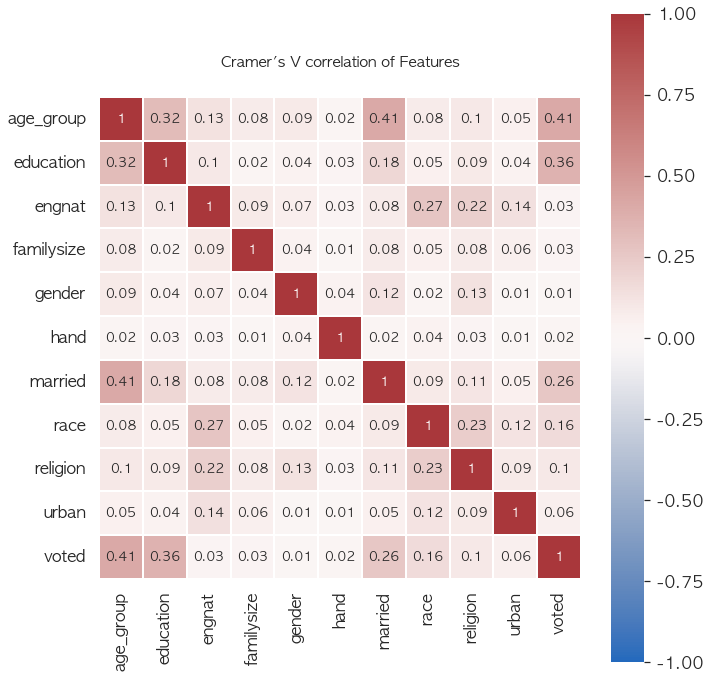

In [505]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plt.title("Cramer's V correlation of Features", y=1.05, size=15)
g1= sns.heatmap(results_matrix, linewidths=0.1, vmax=1.0, vmin=-1.0,
           square=True, cmap= "vlag", linecolor='white', annot=True, annot_kws={"size": 13},
               ax = ax)
plt.tight_layout()
plt.show()

* Voted와 관련성이 큰 feature는 age, education, married, race, religion이다. 
* 인구 통계 변인 간 관련성이 크지는 않다. 무응답 처리가 골치아파졌다.
* 서열형 특성을 가진 변수들은 label encoding, 명목형 변수들은 one-hot encoding을 해서 간단하게 처리해버리자

##### 변수형 변환

In [550]:
demog_nominal = ['engnat', 'gender', 'hand', 'married', 'race','religion','urban']
demog_ordinal = ['age_group', 'education']
demog_numerical = ['familysize']

In [551]:
tdf1_1 = df_train[demog_ordinal] 
tdf1_2 = df_train[demog_nominal]
tdf1_3 = df_train[demog_numerical]

tdf2_1 = df_test[demog_ordinal] 
tdf2_2 = df_test[demog_nominal]
tdf2_3 = df_test[demog_numerical]

* Label encoding

In [552]:
tdf1_1['age_group'] = (tdf1_1['age_group']
                       .replace(['10s', '20s', '30s', '40s', '50s', '60s', '+70s'], [1,2,3,4,5,6,7]))
                       
tdf1_1['education'] = tdf1_1['age_group'].replace([1, 2, 3, 4, 0], [1,2,3,4,5])

tdf2_1['age_group'] = (tdf2_1['age_group']
                       .replace(['10s', '20s', '30s', '40s', '50s', '60s', '+70s'], [1,2,3,4,5,6,7]))
                       
tdf2_1['education'] = tdf2_1['age_group'].replace([1, 2, 3, 4, 0], [1,2,3,4,5])

* One-hot encoding

In [553]:
tdf1_2_oh = pd.get_dummies(tdf1_2,
                           columns=tdf1_2.columns.values,
                           prefix=tdf1_2.columns.values)
tdf2_2_oh = pd.get_dummies(tdf2_2,
                           columns=tdf2_2.columns.values,
                           prefix=tdf2_2.columns.values)

* Combine

In [574]:
df_d_nominal_train = tdf1_2_oh.copy()
df_d_ordinal_train = tdf1_1.copy()
df_d_num_train = tdf1_3.copy()

df_d_nominal_test = tdf2_2_oh.copy()
df_d_ordinal_test = tdf2_1.copy()
df_d_num_test = tdf2_3.copy()

In [575]:
df_d_nominal_train.shape, df_d_ordinal_train.shape, df_d_num_train.shape

((45532, 36), (45532, 2), (45532, 1))

In [576]:
df_d_nominal_test.shape, df_d_ordinal_test.shape, df_d_num_test.shape

((11383, 36), (11383, 2), (11383, 1))

#### Word-Related

* 해당 변수들은 모두 binary category 변수이다.
* wr_(01~13) : 실존하는 해당 단어의 정의을 앎, 1=Yes, 0=No
* wf_(01~03) : 허구인 단어의 정의를 앎, 1=Yes, 0=No

In [512]:
tdf1 = df_train[wrd]
tdf2 = df_test[wrd]

In [522]:
tdf1.head(3)

wf_01  wf_02  wf_03  wr_01  wr_02  wr_03  wr_04  wr_05  wr_06  wr_07  \
0      0      0      0      0      1      0      0      1      0      1   
1      0      0      0      0      1      0      1      1      0      1   
2      0      0      1      1      1      0      1      1      0      1   

   wr_08  wr_09  wr_10  wr_11  wr_12  wr_13  
0      1      0      1      0      1      1  
1      1      0      1      0      1      1  
2      1      1      1      0      1      1

In [519]:
tdf1.isnull().sum().sum(), tdf2.isnull().sum().sum()

(0, 0)

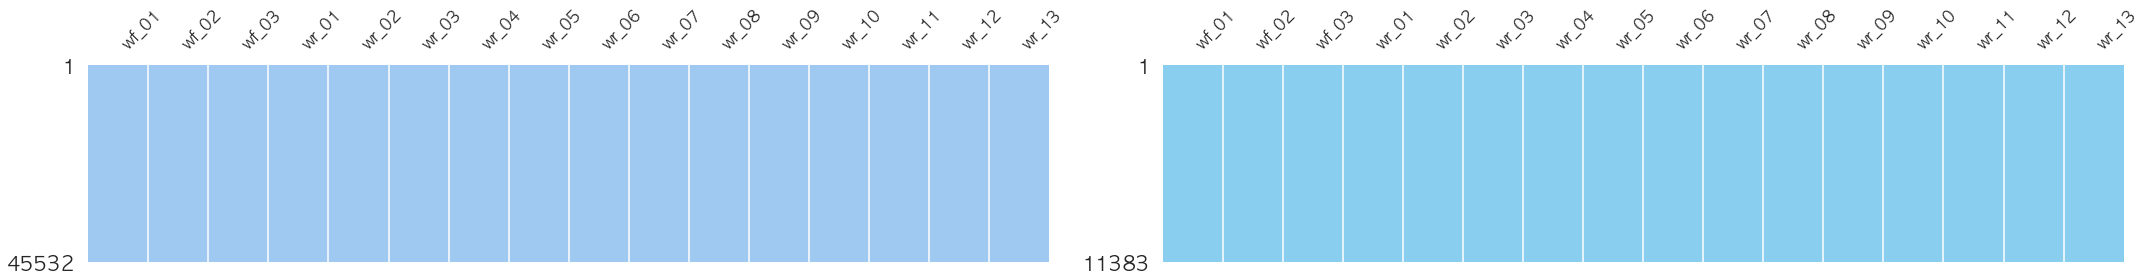

In [523]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 4))
msno.matrix(df=tdf1, color=(0.63, 0.79, 0.95), ax=axes[0])
msno.matrix(df=tdf2, color=(0.54, 0.81, 0.94), ax=axes[1])
plt.tight_layout()
plt.show()

##### Frequency

In [90]:
tmp_df = tdf1.copy()
summary = pd.DataFrame()
for idx, name in enumerate(tmp_df.columns.values):
    tmp_summary = pd.DataFrame({'Count_val':[tmp_df[('%s' % name)].count()],
              'Count_Nan':[tmp_df[('%s' % name)].isnull().sum()],
              'Mean':[tmp_df[('%s' % name)].mean()],
              'Median':[tmp_df[('%s' % name)].median()],
              #'Mode':[tmp_df[('%s' % name)].mode()],
              'Std':[tmp_df[('%s' % name)].std()],
              'Var':[tmp_df[('%s' % name)].var()],
              'Min':[tmp_df[('%s' % name)].min()],
              '25% Q':[tmp_df[('%s' % name)].quantile(q=0.25, interpolation='linear')],
              '50% Q':[tmp_df[('%s' % name)].quantile(q=0.5, interpolation='linear')],
              '75% Q':[tmp_df[('%s' % name)].quantile(q=0.75, interpolation='linear')],
              'Max':[tmp_df[('%s' % name)].max()],
              'Skewness':[tmp_df[('%s' % name)].skew()],
              'Kurtosis':[tmp_df[('%s' % name)].kurt()]}).T
    tmp_summary.columns = [('%s' % name)]
    summary = pd.concat([summary, tmp_summary], axis = 1)
summary.round(2)

wf_01     wf_02     wf_03     wr_01     wr_02     wr_03  \
Count_val  45532.00  45532.00  45532.00  45532.00  45532.00  45532.00   
Count_Nan      0.00      0.00      0.00      0.00      0.00      0.00   
Mean           0.08      0.16      0.12      0.71      0.93      0.21   
Median         0.00      0.00      0.00      1.00      1.00      0.00   
Std            0.27      0.37      0.32      0.45      0.25      0.41   
Var            0.07      0.14      0.10      0.21      0.06      0.17   
Min            0.00      0.00      0.00      0.00      0.00      0.00   
25% Q          0.00      0.00      0.00      0.00      1.00      0.00   
50% Q          0.00      0.00      0.00      1.00      1.00      0.00   
75% Q          0.00      0.00      0.00      1.00      1.00      0.00   
Max            1.00      1.00      1.00      1.00      1.00      1.00   
Skewness       3.11      1.82      2.36     -0.92     -3.52      1.43   
Kurtosis       7.65      1.31      3.58     -1.15     10.41      0.05   

              wr_04     wr_05     wr_06     wr_07     wr_08     wr_09  \
Count_val  45532.00  45532.00  45532.00  45532.00  45532.00  45532.00   
Count_Nan      0.00      0.00      0.00      0.00      0.00      0.00   
Mean           0.87      0.90      0.33      0.94      0.97      0.20   
Median         1.00      1.00      0.00      1.00      1.00      0.00   
Std            0.34      0.31      0.47      0.24      0.16      0.40   
Var            0.11      0.09      0.22      0.06      0.03      0.16   
Min            0.00      0.00      0.00      0.00      0.00      0.00   
25% Q          1.00      1.00      0.00      1.00      1.00      0.00   
50% Q          1.00      1.00      0.00      1.00      1.00      0.00   
75% Q          1.00      1.00      1.00      1.00      1.00      0.00   
Max            1.00      1.00      1.00      1.00      1.00      1.00   
Skewness      -2.18     -2.59      0.73     -3.67     -5.74      1.48   
Kurtosis       2.77      4.71     -1.47     11.43     31.00      0.18   

              wr_10     wr_11     wr_12     wr_13  
Count_val  45532.00  45532.00  45532.00  45532.00  
Count_Nan      0.00      0.00      0.00      0.00  
Mean           0.95      0.40      0.95      0.93  
Median         1.00      0.00      1.00      1.00  
Std            0.23      0.49      0.22      0.26  
Var            0.05      0.24      0.05      0.07  
Min            0.00      0.00      0.00      0.00  
25% Q          1.00      0.00      1.00      1.00  
50% Q          1.00      0.00      1.00      1.00  
75% Q          1.00      1.00      1.00      1.00  
Max            1.00      1.00      1.00      1.00  
Skewness      -3.95      0.43     -4.02     -3.28  
Kurtosis      13.61     -1.82     14.19      8.79

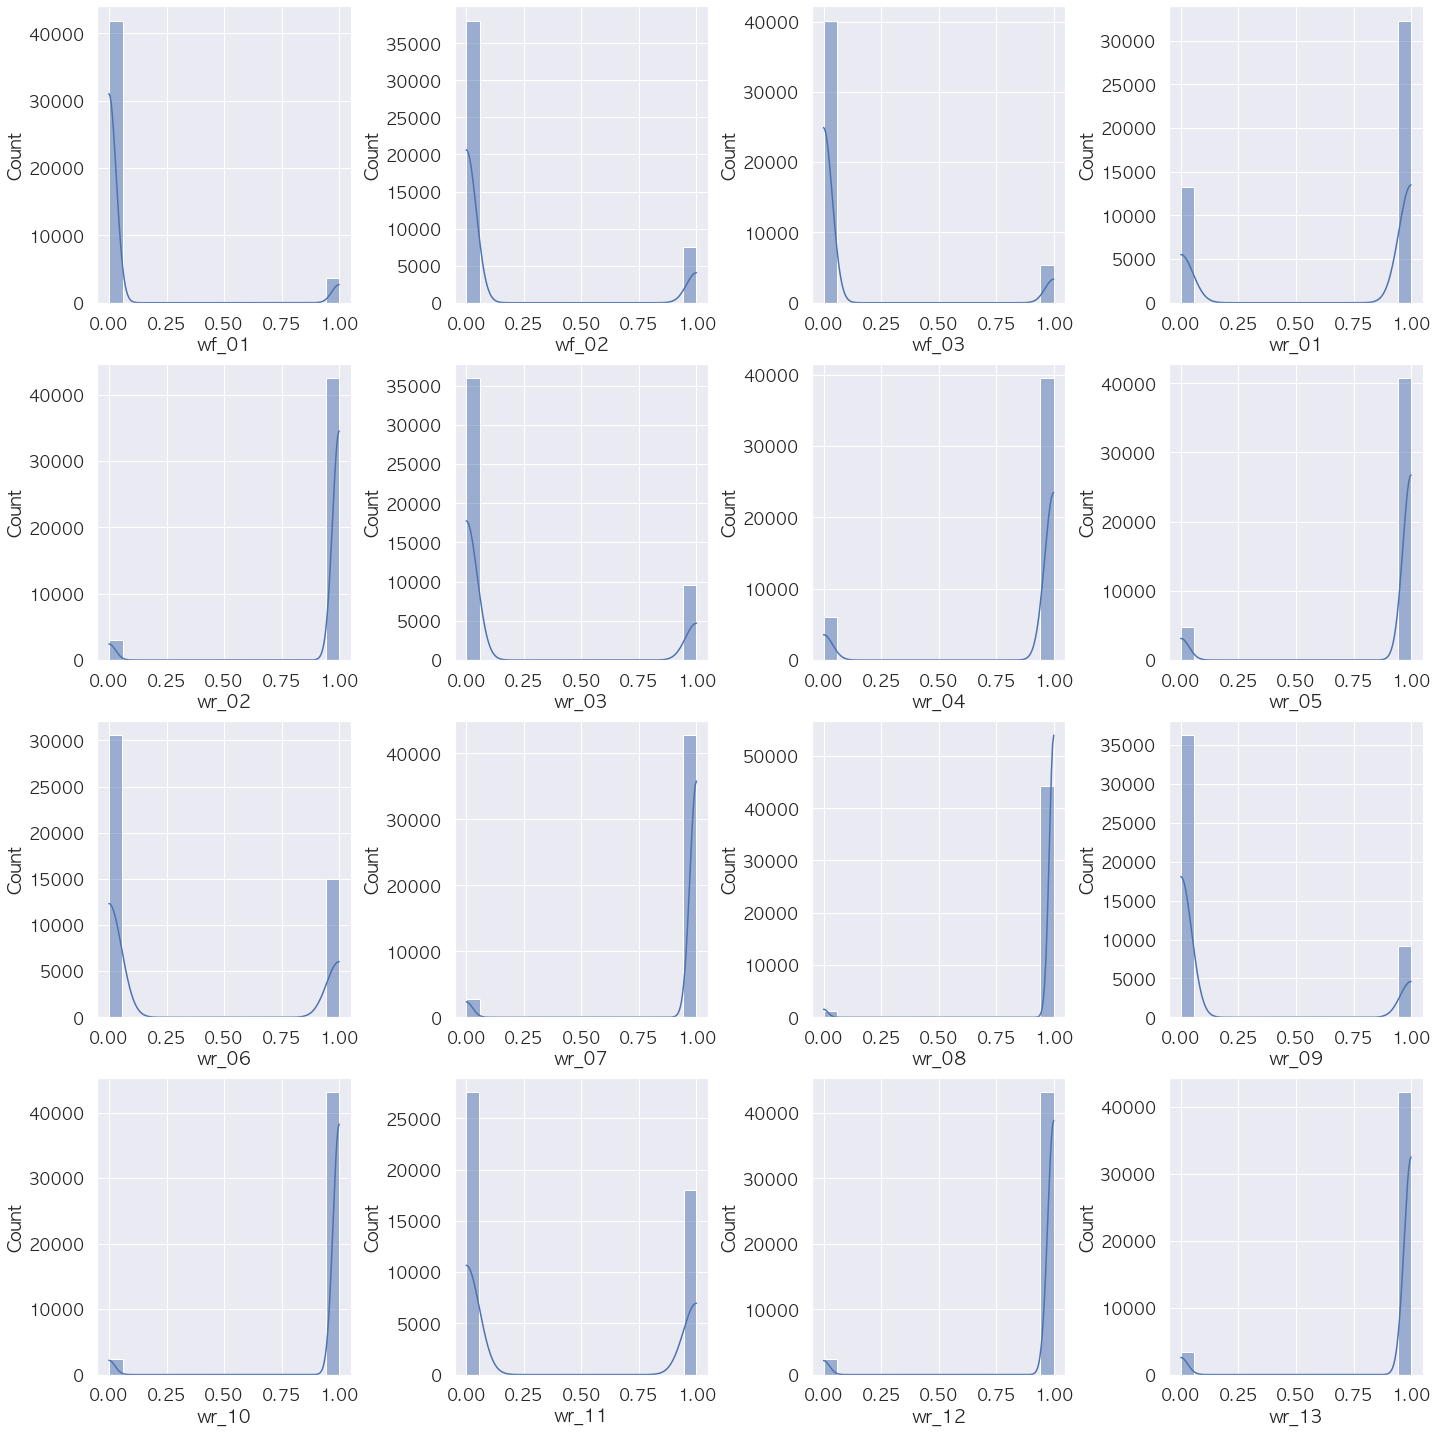

In [529]:
ax_list = []
t_col = tdf1.columns.values
t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])
        
fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])
for idx, name in enumerate(ax_list):
        if idx < len(t_col):
            sns.histplot(tdf1[('%s' % (t_col[idx]))], kde=True, ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()

* 몇몇 feature들은 범주별 관측치가 불균등하다.

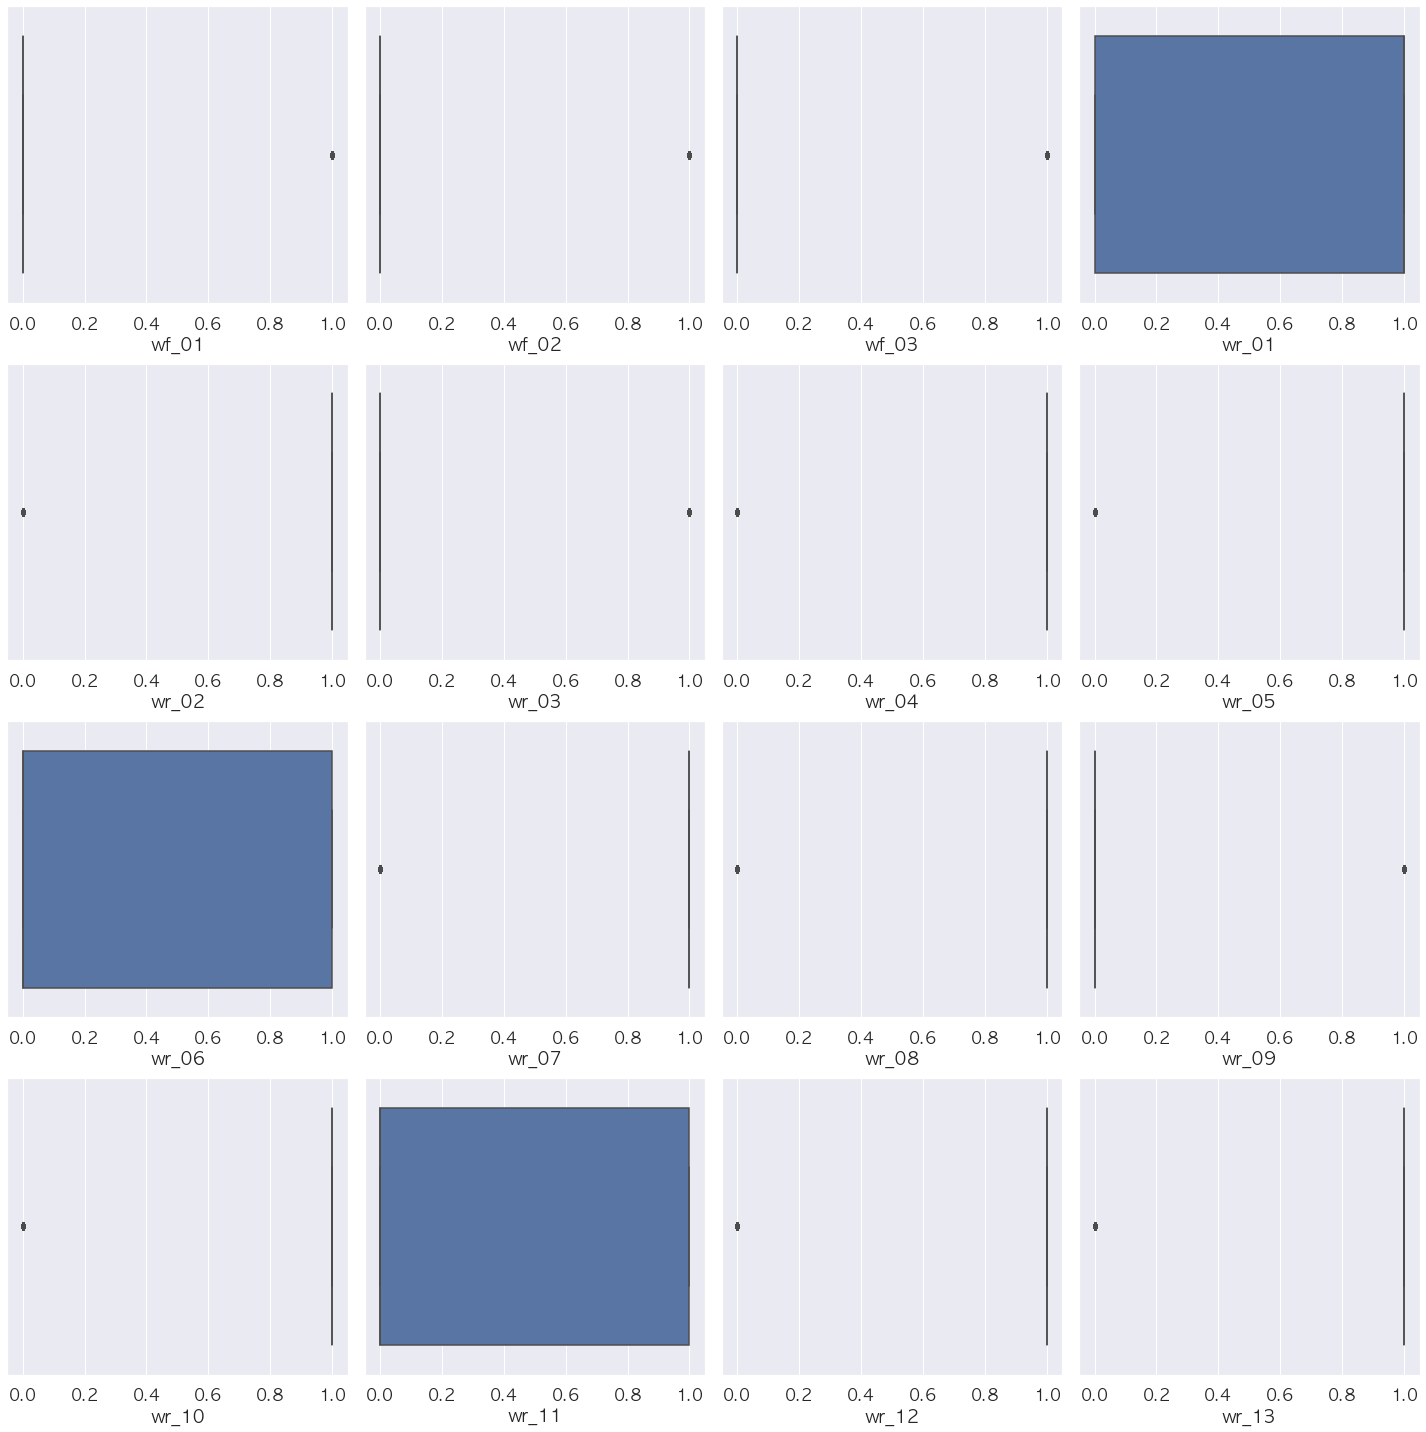

In [530]:
ax_list = []
t_col = tdf1.columns.values
for i in range(np.ceil(np.sqrt(tdf1.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tdf1.shape[1])).astype(np.int16)):
        ax_list.append([int(i),int(j)])
        
fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tdf1.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tdf1.shape[1]))), 
            figsize=[20, 20])

for idx, name in enumerate(ax_list):
    if idx < len(t_col):
        sns.boxplot(x=tdf1[('%s' % (t_col[idx]))], ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()    

##### 변수 간 상관

In [531]:
targ_data = pd.concat([tdf1, df_label], axis=1)

rows= []
for var1 in targ_data:
    col = []
    for var2 in targ_data:
        cramers =cramers_V(targ_data[var1], targ_data[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
results_matrix = pd.DataFrame(cramers_results, columns = targ_data.columns, index = targ_data.columns)
results_matrix

wf_01  wf_02  wf_03  wr_01  wr_02  wr_03  wr_04  wr_05  wr_06  wr_07  \
wf_01   1.00   0.28   0.26   0.06   0.00   0.16   0.04   0.02   0.13   0.01   
wf_02   0.28   1.00   0.25   0.13   0.05   0.19   0.11   0.09   0.20   0.05   
wf_03   0.26   0.25   1.00   0.13   0.03   0.14   0.08   0.07   0.15   0.02   
wr_01   0.06   0.13   0.13   1.00   0.28   0.23   0.40   0.41   0.23   0.30   
wr_02   0.00   0.05   0.03   0.28   1.00   0.07   0.34   0.43   0.09   0.54   
wr_03   0.16   0.19   0.14   0.23   0.07   1.00   0.14   0.11   0.32   0.06   
wr_04   0.04   0.11   0.08   0.40   0.34   0.14   1.00   0.47   0.16   0.38   
wr_05   0.02   0.09   0.07   0.41   0.43   0.11   0.47   1.00   0.15   0.49   
wr_06   0.13   0.20   0.15   0.23   0.09   0.32   0.16   0.15   1.00   0.08   
wr_07   0.01   0.05   0.02   0.30   0.54   0.06   0.38   0.49   0.08   1.00   
wr_08   0.05   0.00   0.02   0.17   0.42   0.00   0.27   0.33   0.04   0.45   
wr_09   0.15   0.18   0.14   0.22   0.07   0.39   0.13   0.11   0.33   0.05   
wr_10   0.01   0.04   0.01   0.27   0.62   0.05   0.35   0.45   0.08   0.58   
wr_11   0.14   0.24   0.15   0.36   0.15   0.38   0.25   0.22   0.30   0.14   
wr_12   0.01   0.04   0.01   0.24   0.48   0.06   0.32   0.39   0.08   0.47   
wr_13   0.01   0.07   0.04   0.34   0.43   0.08   0.43   0.48   0.10   0.45   
voted   0.00   0.02   0.04   0.11   0.04   0.10   0.07   0.09   0.10   0.03   

       wr_08  wr_09  wr_10  wr_11  wr_12  wr_13  voted  
wf_01   0.05   0.15   0.01   0.14   0.01   0.01   0.00  
wf_02   0.00   0.18   0.04   0.24   0.04   0.07   0.02  
wf_03   0.02   0.14   0.01   0.15   0.01   0.04   0.04  
wr_01   0.17   0.22   0.27   0.36   0.24   0.34   0.11  
wr_02   0.42   0.07   0.62   0.15   0.48   0.43   0.04  
wr_03   0.00   0.39   0.05   0.38   0.06   0.08   0.10  
wr_04   0.27   0.13   0.35   0.25   0.32   0.43   0.07  
wr_05   0.33   0.11   0.45   0.22   0.39   0.48   0.09  
wr_06   0.04   0.33   0.08   0.30   0.08   0.10   0.10  
wr_07   0.45   0.05   0.58   0.14   0.47   0.45   0.03  
wr_08   1.00   0.00   0.47   0.07   0.42   0.37   0.02  
wr_09   0.00   1.00   0.05   0.35   0.05   0.07   0.09  
wr_10   0.47   0.05   1.00   0.13   0.50   0.43   0.04  
wr_11   0.07   0.35   0.13   1.00   0.13   0.17   0.12  
wr_12   0.42   0.05   0.50   0.13   1.00   0.40   0.05  
wr_13   0.37   0.07   0.43   0.17   0.40   1.00   0.06  
voted   0.02   0.09   0.04   0.12   0.05   0.06   1.00

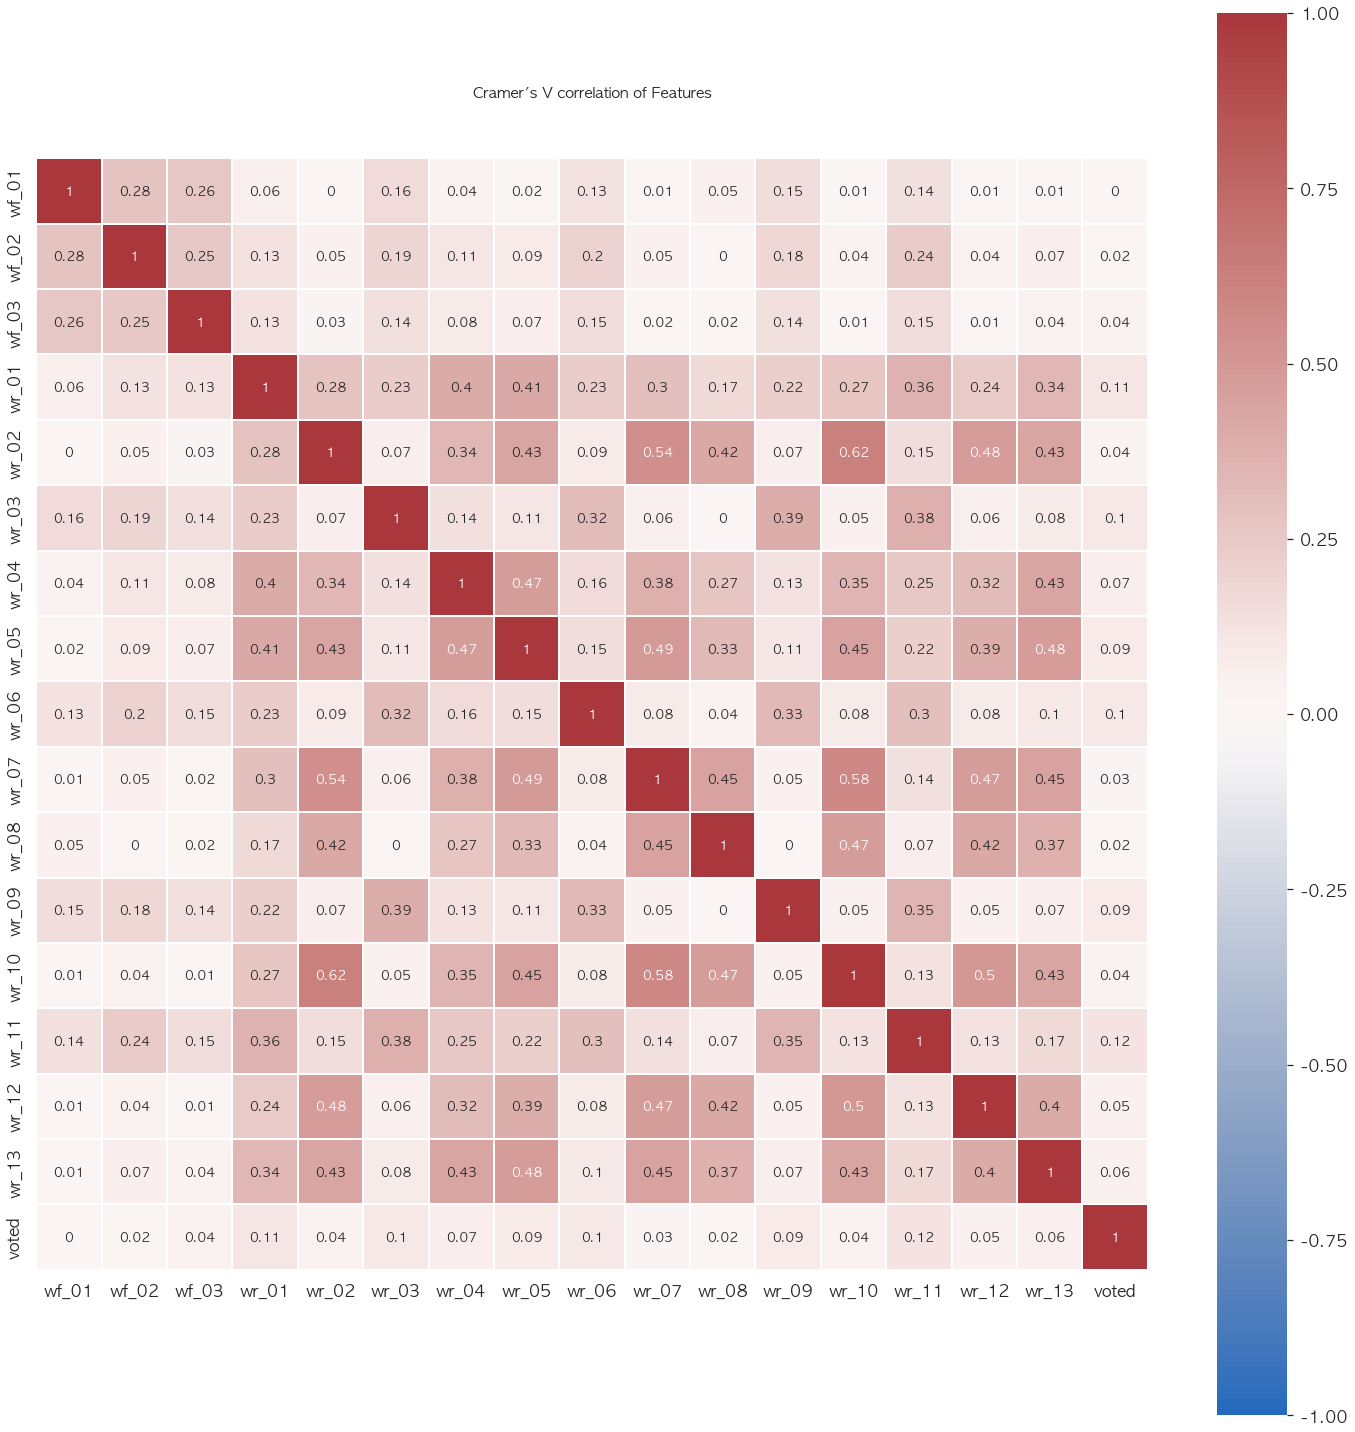

In [533]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

plt.title("Cramer's V correlation of Features", y=1.05, size=15)
g1= sns.heatmap(results_matrix, linewidths=0.1, vmax=1.0, vmin=-1.0,
           square=True, cmap= "vlag", linecolor='white', annot=True, annot_kws={"size": 13},
               ax = ax)
plt.tight_layout()
plt.show()

* Vote와 상관이 높은 Feature들은 몇개 보이지 않는다. 추후 feature selection 단계에서 처리하도록 하자

In [538]:
pd.DataFrame(results_matrix.voted).T

wf_01  wf_02  wf_03  wr_01  wr_02  wr_03  wr_04  wr_05  wr_06  wr_07  \
voted    0.0   0.02   0.04   0.11   0.04    0.1   0.07   0.09    0.1   0.03   

       wr_08  wr_09  wr_10  wr_11  wr_12  wr_13  voted  
voted   0.02   0.09   0.04   0.12   0.05   0.06    1.0

In [539]:
df_wrd_train = tdf1.copy()
df_wrd_test = tdf2.copy()

### Feature Engineering

* feature들의 특성을 고려하여 feature scaling, feature selection을 수행한다.

In [556]:
df_machA_train.shape, df_machE_train.shape, df_tipi_train.shape, df_wrd_train.shape

((45532, 23), (45532, 20), (45532, 15), (45532, 16))

In [557]:
df_d_nominal_train.shape, df_d_ordinal_train.shape, df_d_num_train.shape

((11383, 36), (11383, 2), (11383, 1))

* 분류 모델을 위해 standardscaler, robustscaler, min-max sclaer 등을 활용한다.
* 모든 변인을 scaling 해준 다음에 centering을 해주자

#### Feature Scaling

In [577]:
df_machA_train_raw = df_machA_train.copy()
df_machE_train_raw = df_machE_train.copy()
df_tipi_train_raw = df_tipi_train.copy()
df_d_num_train_raw = df_d_num_train.copy()

df_d_nominal_train_raw = df_d_nominal_train.copy()
df_d_ordinal_train_raw = df_d_ordinal_train.copy()
df_wrd_train_raw = df_wrd_train.copy()

df_machA_test_raw = df_machA_test.copy()
df_machE_test_raw = df_machE_test.copy()
df_tipi_test_raw = df_tipi_test.copy()
df_d_num_test_raw = df_d_num_test.copy()

df_d_nominal_test_raw = df_d_nominal_test.copy()
df_d_ordinal_test_raw = df_d_ordinal_test.copy()
df_wrd_test_raw = df_wrd_test.copy()


In [578]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

##### Numerical

In [579]:
df_machA_train.shape, df_machE_train.shape, df_tipi_train.shape, df_d_num_train.shape

((45532, 23), (45532, 20), (45532, 15), (45532, 1))

* mach_A - std

In [580]:
std_scaler = StandardScaler()
targ_col = df_machA_train.columns.values
df_machA_train = pd.DataFrame(std_scaler.fit_transform(df_machA_train))
df_machA_train.columns = targ_col

df_machA_test = pd.DataFrame(std_scaler.transform(df_machA_test))
df_machA_test.columns = targ_col

* tipi - std

In [581]:
std_scaler = StandardScaler()
targ_col = df_tipi_train.columns.values
df_tipi_train = pd.DataFrame(std_scaler.fit_transform(df_tipi_train))
df_tipi_train.columns = targ_col

df_tipi_test = pd.DataFrame(std_scaler.transform(df_tipi_test))
df_tipi_test.columns = targ_col

* Mach_E (RT) - robust

In [585]:
rbs_scaler = RobustScaler()
targ_col = df_machE_train.columns.values
df_machE_train = pd.DataFrame(rbs_scaler.fit_transform(df_machE_train))
df_machE_train.columns = targ_col

df_machE_test = pd.DataFrame(rbs_scaler.fit_transform(df_machE_test))
df_machE_test.columns = targ_col

* demographic-familiysize - robust

In [582]:
rbs_scaler = RobustScaler()
targ_col = df_d_num_train.columns.values
df_d_num_train = pd.DataFrame(rbs_scaler.fit_transform(df_d_num_train))
df_d_num_train.columns = targ_col

df_d_num_test = pd.DataFrame(rbs_scaler.fit_transform(df_d_num_test))
df_d_num_test.columns = targ_col

* 분포확인

In [614]:
tmp_df.shape

(45532, 59)

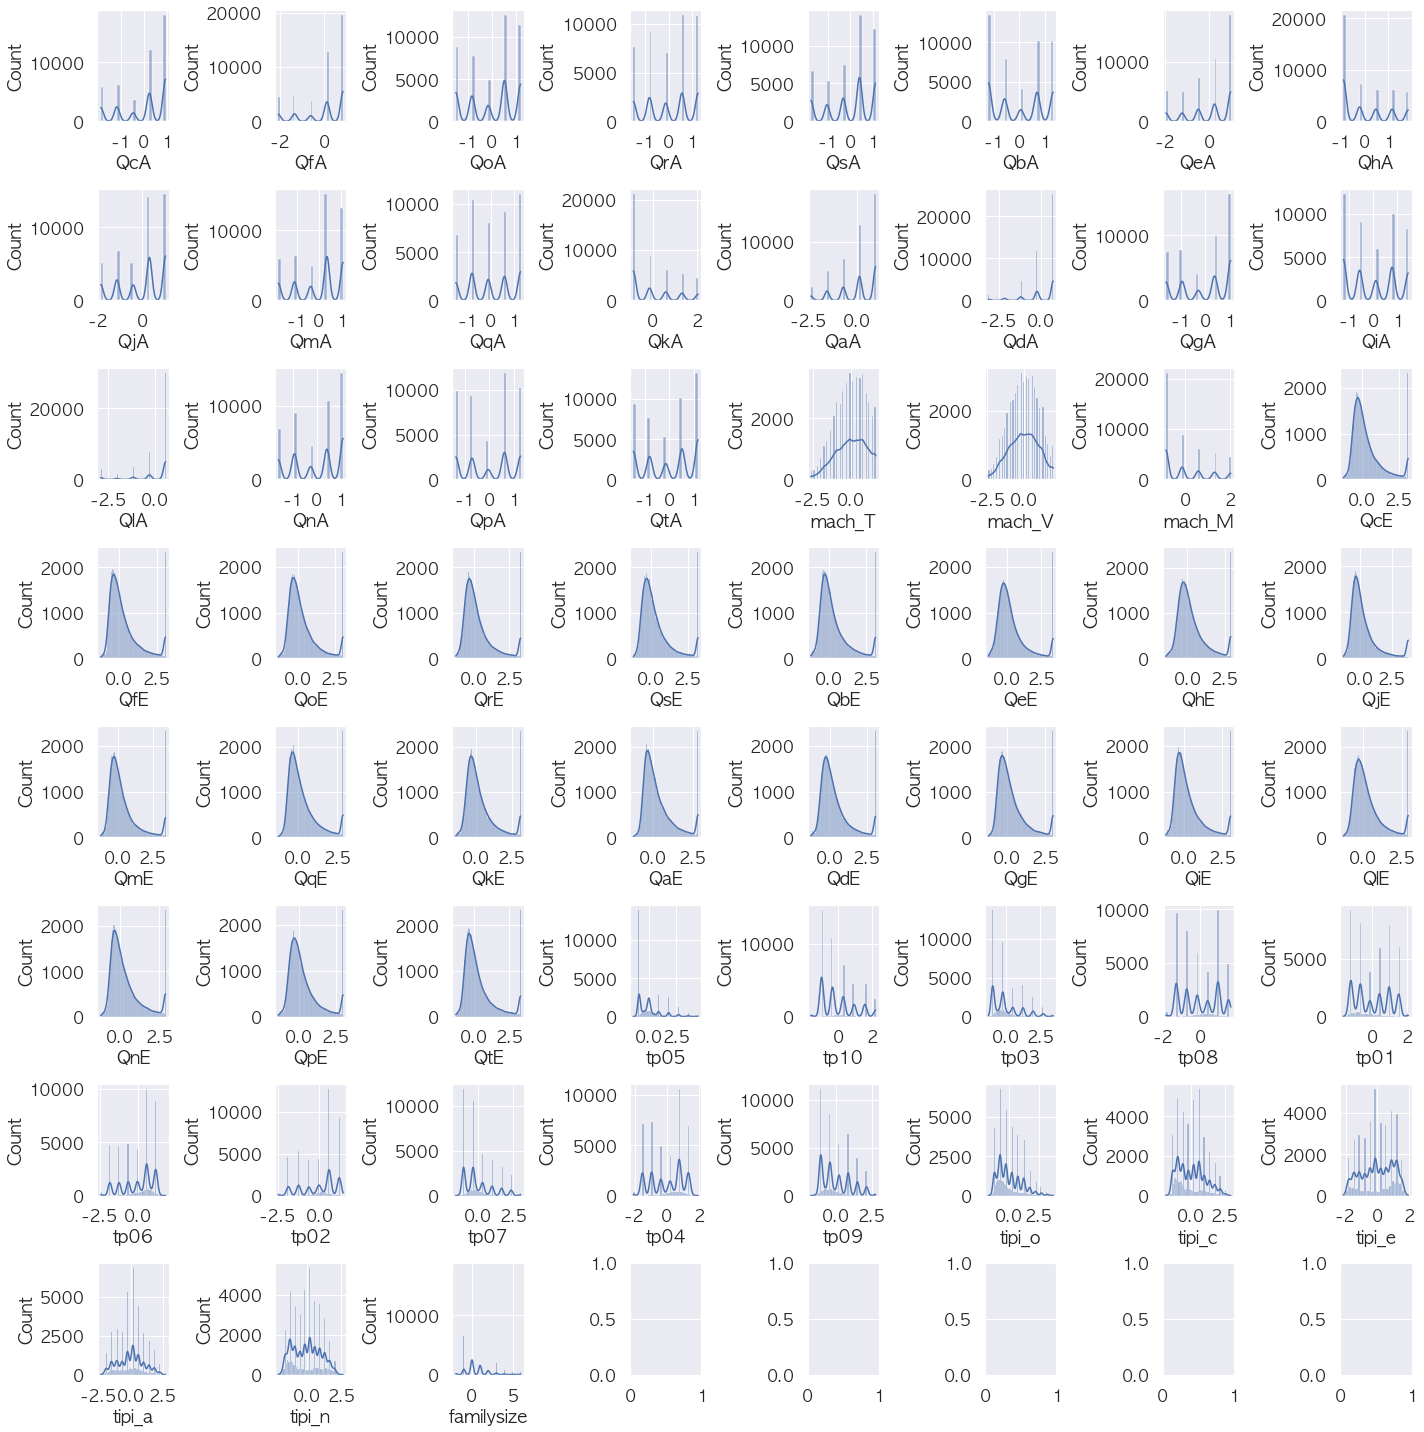

In [621]:
tmp_df = pd.concat([df_machA_train, df_machE_train, df_tipi_train, df_d_num_train], axis = 1)
ax_list = []
t_col = tmp_df.columns.values
for i in range(np.ceil(np.sqrt(tmp_df.shape[1])).astype(np.int16)):
    for j in range(np.floor(np.sqrt(tmp_df.shape[1])).astype(np.int16)+1):
        ax_list.append([int(i),int(j)])
        
fig, ax = plt.subplots(nrows=int(np.ceil(np.sqrt(tmp_df.shape[1]))), 
             ncols=int(np.floor(np.sqrt(tmp_df.shape[1]))+1), 
            figsize=[20, 20])
for idx, name in enumerate(ax_list):
        if idx < len(t_col):
            sns.histplot(tmp_df[('%s' % (t_col[idx]))], kde=True, ax = ax[name[0], name[1]])
plt.tight_layout()
plt.show()

In [612]:
tmp_df.head(3)

QcA       QfA       QoA       QrA       QsA       QbA       QeA  \
0  0.934456 -2.099789 -0.824461  0.578142 -1.042203  0.699521  0.232219   
1 -0.462702 -0.616811 -1.501785  1.280208  0.412424  1.338040  0.962578   
2 -1.859859  0.866167 -0.824461 -0.825990 -1.769516 -1.216035 -1.958857   

        QhA       QjA      QmA  ...      tp02      tp07      tp04      tp09  \
0  1.151459  0.311835 -1.09781  ...  0.573902  3.034256  1.326416  0.851664   
1 -0.902214 -0.422809 -1.82502  ...  1.180297  0.329318 -0.019770 -0.445510   
2 -0.902214 -1.157452 -1.09781  ... -0.032494 -0.346917 -0.942990 -1.083190   

     tipi_o    tipi_c    tipi_e    tipi_a    tipi_n  familysize  
0  0.735629 -0.219609  0.222518  2.251213  1.313987         2.0  
1 -0.261866 -0.361567 -0.452871  1.008228 -0.260617         1.0  
2  1.234376 -1.410589 -0.790565 -0.234757 -1.200190         1.0  

[3 rows x 59 columns]

##### Ordinal

In [588]:
df_d_ordinal_train.shape

(45532, 2)

* std

In [589]:
std_scaler = StandardScaler()
targ_col = df_d_ordinal_train.columns.values
df_d_ordinal_train = pd.DataFrame(std_scaler.fit_transform(df_d_ordinal_train))
df_d_ordinal_train.columns = targ_col

df_d_ordinal_test = pd.DataFrame(std_scaler.transform(df_d_ordinal_test))
df_d_ordinal_test.columns = targ_col

* 분포 확인

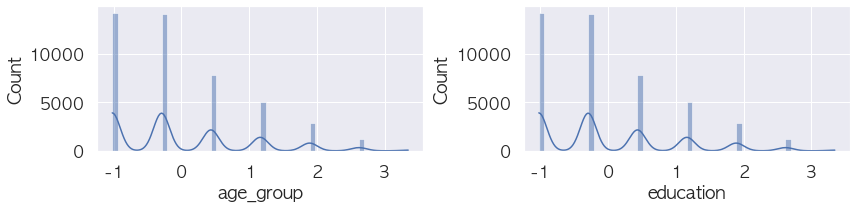

In [597]:
fig, ax = plt.subplots(1, 2, figsize=[12, 3])
sns.histplot(df_d_ordinal_train.age_group, kde=True, ax=ax[0])
sns.histplot(df_d_ordinal_train.education, kde=True, ax=ax[1])
plt.tight_layout()
plt.show()

##### Nominal

* one-hot encoding이 되어있으므로 그대로 둔다.

In [598]:
df_d_nominal_train.shape, df_wrd_train.shape

((45532, 36), (45532, 16))

#### Feature Selection

In [622]:
x_train_num = pd.concat([df_machA_train, df_machE_train, df_tipi_train, df_d_num_train, df_d_ordinal_train], axis = 1)
x_train_cat = pd.concat([df_d_nominal_train, df_wrd_train], axis = 1)

##### Numerical - f_anova

In [656]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x_train_num, df_label, 
                                                                              test_size=0.2, shuffle=True, 
                                                                              stratify=df_label, 
                                                                              random_state=22)

* Feature Selection을 안 한 경우

In [657]:
X_train_filter=X_train.copy()
y_train_filter=y_train.copy()
X_test_filter=X_test.copy()
y_test_filter=y_test.copy()

from sklearn.linear_model import LogisticRegression

model_filter=LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
              intercept_scaling=1, class_weight=None, random_state=0, 
              solver='lbfgs', max_iter=100, multi_class='auto')
model_filter.fit(X_train_filter,y_train_filter)


y_pred_filter=model_filter.predict(X_test_filter)

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

metric_filter=confusion_matrix(y_test_filter,y_pred_filter)

accuracy_filter_basic=(metric_filter[0][0]+metric_filter[1][1])/sum(sum(metric_filter))*100
print('Accuracy using filter : ',accuracy_score(y_test_filter, y_pred_filter)*100,
      '\n',
      'AUC using filter : ',roc_auc_score(y_test_filter, y_pred_filter)*100)


Accuracy using filter :  63.90688481387944 
 AUC using filter :  62.61729252848565


* Feature Selection 을 한 경우

In [658]:
X_train_filter=X_train.copy()
y_train_filter=y_train.copy()
X_test_filter=X_test.copy()
y_test_filter=y_test.copy()

from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
#selector=SelectPercentile(chi2, perceptile=50)
selector=SelectKBest(f_classif, k='all')
selector.fit(X_train_filter,y_train_filter)
threshold = 0.01
is_support = selector.pvalues_ < threshold

In [659]:
Results = pd.DataFrame({"Name":X_train_filter.columns,
              "F":selector.scores_,
              "p-value":selector.pvalues_,
              "Threshold": threshold,
              "Results": is_support})
Results

Name            F       p-value  Threshold  Results
0          QcA    77.776893  1.203731e-18       0.01     True
1          QfA    26.718516  2.365964e-07       0.01     True
2          QoA   196.986869  1.241117e-44       0.01     True
3          QrA    38.226987  6.364279e-10       0.01     True
4          QsA   169.326887  1.265874e-38       0.01     True
..         ...          ...           ...        ...      ...
56      tipi_a   260.358450  2.285778e-58       0.01     True
57      tipi_n   219.213229  1.870569e-49       0.01     True
58  familysize    41.977135  9.352309e-11       0.01     True
59   age_group  4968.950724  0.000000e+00       0.01     True
60   education  4968.950724  0.000000e+00       0.01     True

[61 rows x 5 columns]

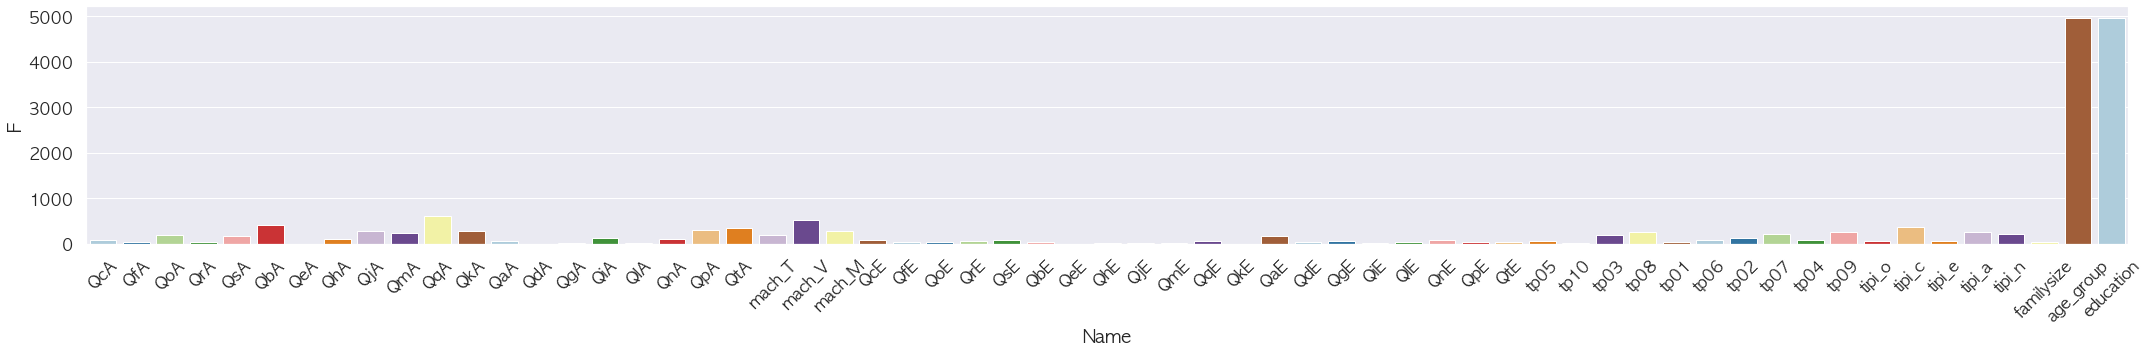

In [660]:
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
g1 = sns.barplot(data=Results, x='Name', y='F', ax=ax, palette="Paired")
g1.set_xticklabels(g1.get_xticklabels(),rotation = 45)
#g1.axhline(Threshold, color="darkred")
plt.tight_layout()
plt.show()

In [661]:
X_train_filter=np.array(X_train_filter[X_train_filter.columns[is_support].values])
X_test_filter=np.array(X_test_filter[X_test_filter.columns[is_support].values])
y_train_filter = np.array(y_train_filter)
y_test_filter = np.array(y_test_filter)

from sklearn.linear_model import LogisticRegression

model_filter=LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
              intercept_scaling=1, class_weight=None, random_state=0, 
              solver='lbfgs', max_iter=100, multi_class='auto')
model_filter.fit(X_train_filter,y_train_filter)


y_pred_filter=model_filter.predict(X_test_filter)

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

metric_filter=confusion_matrix(y_test_filter,y_pred_filter)

accuracy_filter_basic=(metric_filter[0][0]+metric_filter[1][1])/sum(sum(metric_filter))*100
print('Accuracy using filter : ',accuracy_score(y_test_filter, y_pred_filter)*100,
      '\n',
      'AUC using filter : ',roc_auc_score(y_test_filter, y_pred_filter)*100)

Accuracy using filter :  63.6543318326562 
 AUC using filter :  62.334489399322514


##### Numerical - RFE

In [668]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x_train_num, df_label, 
                                                                              test_size=0.2, shuffle=True, 
                                                                              stratify=df_label, 
                                                                              random_state=22)

In [673]:
X_train_wrapper=X_train.copy()
y_train_wrapper=y_train.copy()
X_test_wrapper=X_test.copy()
y_test_wrapper=y_test.copy()

from sklearn.feature_selection import RFE
selector = RFE(LogisticRegression(), n_features_to_select=0.5, step=1)
selector.fit(X_train_wrapper, y_train_wrapper)


RFE(estimator=LogisticRegression(), n_features_to_select=0.5)

In [674]:
is_support = selector.get_support()
Results = pd.DataFrame({"Name":X_train.columns,
              "Results": is_support})
Results

Name  Results
0          QcA    False
1          QfA     True
2          QoA     True
3          QrA    False
4          QsA     True
..         ...      ...
56      tipi_a    False
57      tipi_n     True
58  familysize     True
59   age_group     True
60   education     True

[61 rows x 2 columns]

In [675]:
X_train_wrapper=np.array(X_train_wrapper[X_train_wrapper.columns[is_support].values])
X_test_wrapper=np.array(X_test_wrapper[X_test_wrapper.columns[is_support].values])
y_train_wrapper = np.array(y_train_wrapper)
y_test_wrapper = np.array(y_test_wrapper)

from sklearn.linear_model import LogisticRegression

model_wrapper=LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
              intercept_scaling=1, class_weight=None, random_state=0, 
              solver='lbfgs', max_iter=100, multi_class='auto')
model_wrapper.fit(X_train_wrapper,y_train_wrapper)


y_pred_wrapper=model_wrapper.predict(X_test_wrapper)

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

metric_wrapper=confusion_matrix(y_test_wrapper,y_pred_wrapper)

accuracy_wrapper_basic=(metric_wrapper[0][0]+metric_wrapper[1][1])/sum(sum(metric_wrapper))*100
print('Accuracy using filter : ',accuracy_score(y_test_wrapper, y_pred_wrapper)*100,
      '\n',
      'AUC using filter : ',roc_auc_score(y_test_wrapper, y_pred_wrapper)*100)

Accuracy using filter :  63.961787635884484 
 AUC using filter :  62.66541815432313


##### Categorical - Chi 2

In [662]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x_train_cat, df_label, 
                                                                              test_size=0.2, shuffle=True, 
                                                                              stratify=df_label, 
                                                                              random_state=22)

* Feature Selection 을 안 한 경우

In [663]:
X_train_filter=X_train.copy()
y_train_filter=y_train.copy()
X_test_filter=X_test.copy()
y_test_filter=y_test.copy()

from sklearn.linear_model import LogisticRegression

model_filter=LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
              intercept_scaling=1, class_weight=None, random_state=0, 
              solver='lbfgs', max_iter=100, multi_class='auto')
model_filter.fit(X_train_filter,y_train_filter)


y_pred_filter=model_filter.predict(X_test_filter)

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

metric_filter=confusion_matrix(y_test_filter,y_pred_filter)

accuracy_filter_basic=(metric_filter[0][0]+metric_filter[1][1])/sum(sum(metric_filter))*100
print('Accuracy using filter : ',accuracy_score(y_test_filter, y_pred_filter)*100,
      '\n',
      'AUC using filter : ',roc_auc_score(y_test_filter, y_pred_filter)*100)

Accuracy using filter :  63.64335126825519 
 AUC using filter :  62.255968385293045


* Feature Selection 을 한 경우

In [664]:
X_train_filter=X_train.copy()
y_train_filter=y_train.copy()
X_test_filter=X_test.copy()
y_test_filter=y_test.copy()

In [665]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
#selector=SelectPercentile(chi2, perceptile=50)
selector=SelectKBest(chi2, k='all')
selector.fit(X_train_filter,y_train_filter)
threshold = 0.01
is_support = selector.pvalues_ < threshold

In [666]:
Results = pd.DataFrame({"Name":X_train_filter.columns,
              "chi^2":selector.scores_,
              "p-value":selector.pvalues_,
              "Threshold": threshold,
              "Results": is_support})
Results

Name        chi^2        p-value  Threshold  \
0                        engnat_0     4.942756   2.620022e-02       0.01   
1                        engnat_1     8.271052   4.028215e-03       0.01   
2                        engnat_2    20.350178   6.448710e-06       0.01   
3                   gender_Female     5.736101   1.661964e-02       0.01   
4                     gender_Male     5.032762   2.487220e-02       0.01   
5                          hand_0     3.979708   4.605155e-02       0.01   
6                          hand_1     0.135236   7.130642e-01       0.01   
7                          hand_2     1.978429   1.595560e-01       0.01   
8                          hand_3    12.485868   4.100422e-04       0.01   
9                       married_0     5.367968   2.050985e-02       0.01   
10                      married_1   731.084755  5.203873e-161       0.01   
11                      married_2  1546.176516   0.000000e+00       0.01   
12                      married_3   200.933823   1.306331e-45       0.01   
13                      race_Arab    31.783733   1.723300e-08       0.01   
14                     race_Asian   523.050795  9.179196e-116       0.01   
15                     race_Black    18.694351   1.534364e-05       0.01   
16     race_Indigenous Australian     0.165654   6.840031e-01       0.01   
17           race_Native American     5.789309   1.612392e-02       0.01   
18                     race_Other    79.502322   4.816588e-19       0.01   
19                     race_White   259.155269   2.622095e-58       0.01   
20              religion_Agnostic     1.780889   1.820402e-01       0.01   
21               religion_Atheist    22.649637   1.943970e-06       0.01   
22              religion_Buddhist    12.296115   4.539021e-04       0.01   
23    religion_Christian_Catholic     4.382011   3.632012e-02       0.01   
24      religion_Christian_Mormon    10.232701   1.379725e-03       0.01   
25       religion_Christian_Other     1.131794   2.873930e-01       0.01   
26  religion_Christian_Protestant   184.924798   4.075822e-42       0.01   
27                 religion_Hindu    19.050025   1.273361e-05       0.01   
28                religion_Jewish    15.574339   7.932387e-05       0.01   
29                religion_Muslim    73.826354   8.530014e-18       0.01   
30                 religion_Other    17.300921   3.190322e-05       0.01   
31                  religion_Sikh     3.785388   5.170193e-02       0.01   
32                        urban_0     3.083635   7.908361e-02       0.01   
33                        urban_1    74.674628   5.550490e-18       0.01   
34                        urban_2     1.407413   2.354864e-01       0.01   
35                        urban_3    57.242979   3.851616e-14       0.01   
36                          wf_01     0.007678   9.301754e-01       0.01   
37                          wf_02     9.555555   1.993452e-03       0.01   
38                          wf_03    40.676767   1.796099e-10       0.01   
39                          wr_01   128.808333   7.469395e-30       0.01   
40                          wr_02     4.280532   3.855128e-02       0.01   
41                          wr_03   296.569692   1.841340e-66       0.01   
42                          wr_04    23.698152   1.126907e-06       0.01   
43                          wr_05    35.463777   2.598380e-09       0.01   
44                          wr_06   246.867010   1.251632e-55       0.01   
45                          wr_07     3.934846   4.729548e-02       0.01   
46                          wr_08     0.559284   4.545487e-01       0.01   
47                          wr_09   245.522967   2.457582e-55       0.01   
48                          wr_10     3.386313   6.573980e-02       0.01   
49                          wr_11   305.119499   2.526014e-68       0.01   
50                          wr_12     4.659885   3.087526e-02       0.01   
51                          wr_13     9.476786   2.080882e-03       0.01   



In [667]:
X_train_filter=np.array(X_train_filter[X_train_filter.columns[is_support].values])
X_test_filter=np.array(X_test_filter[X_test_filter.columns[is_support].values])
y_train_filter = np.array(y_train_filter)
y_test_filter = np.array(y_test_filter)

from sklearn.linear_model import LogisticRegression

model_filter=LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
              intercept_scaling=1, class_weight=None, random_state=0, 
              solver='lbfgs', max_iter=100, multi_class='auto')
model_filter.fit(X_train_filter,y_train_filter)


y_pred_filter=model_filter.predict(X_test_filter)

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

metric_filter=confusion_matrix(y_test_filter,y_pred_filter)

accuracy_filter_basic=(metric_filter[0][0]+metric_filter[1][1])/sum(sum(metric_filter))*100
print('Accuracy using filter : ',accuracy_score(y_test_filter, y_pred_filter)*100,
      '\n',
      'AUC using filter : ',roc_auc_score(y_test_filter, y_pred_filter)*100)



Accuracy using filter :  63.423739980234984 
 AUC using filter :  62.001210560682274


##### Categorical -RFE

In [676]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x_train_cat, df_label, 
                                                                              test_size=0.2, shuffle=True, 
                                                                              stratify=df_label, 
                                                                              random_state=22)


In [677]:
X_train_wrapper=X_train.copy()
y_train_wrapper=y_train.copy()
X_test_wrapper=X_test.copy()
y_test_wrapper=y_test.copy()

from sklearn.feature_selection import RFE
selector = RFE(LogisticRegression(), n_features_to_select=0.5, step=1)
selector.fit(X_train_wrapper, y_train_wrapper)


RFE(estimator=LogisticRegression(), n_features_to_select=0.5)

In [678]:
is_support = selector.get_support()
Results = pd.DataFrame({"Name":X_train.columns,
              "Results": is_support})
Results



Name  Results
0                        engnat_0     True
1                        engnat_1    False
2                        engnat_2     True
3                   gender_Female    False
4                     gender_Male     True
5                          hand_0     True
6                          hand_1    False
7                          hand_2    False
8                          hand_3     True
9                       married_0     True
10                      married_1     True
11                      married_2     True
12                      married_3     True
13                      race_Arab     True
14                     race_Asian     True
15                     race_Black     True
16     race_Indigenous Australian     True
17           race_Native American    False
18                     race_Other    False
19                     race_White     True
20              religion_Agnostic    False
21               religion_Atheist     True
22              religion_Buddhist    False
23    religion_Christian_Catholic    False
24      religion_Christian_Mormon     True
25       religion_Christian_Other    False
26  religion_Christian_Protestant     True
27                 religion_Hindu     True
28                religion_Jewish     True
29                religion_Muslim    False
30                 religion_Other     True
31                  religion_Sikh     True
32                        urban_0    False
33                        urban_1    False
34                        urban_2    False
35                        urban_3    False
36                          wf_01    False
37                          wf_02    False
38                          wf_03    False
39                          wr_01     True
40                          wr_02     True
41                          wr_03    False
42                          wr_04    False
43                          wr_05     True
44                          wr_06     True
45                          wr_07    False
46                          wr_08    False
47                          wr_09     True
48                          wr_10    False
49                          wr_11    False
50                          wr_12    False
51                          wr_13    False

In [679]:
X_train_wrapper=np.array(X_train_wrapper[X_train_wrapper.columns[is_support].values])
X_test_wrapper=np.array(X_test_wrapper[X_test_wrapper.columns[is_support].values])
y_train_wrapper = np.array(y_train_wrapper)
y_test_wrapper = np.array(y_test_wrapper)

from sklearn.linear_model import LogisticRegression

model_wrapper=LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
              intercept_scaling=1, class_weight=None, random_state=0, 
              solver='lbfgs', max_iter=100, multi_class='auto')
model_wrapper.fit(X_train_wrapper,y_train_wrapper)


y_pred_wrapper=model_wrapper.predict(X_test_wrapper)

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

metric_wrapper=confusion_matrix(y_test_wrapper,y_pred_wrapper)

accuracy_wrapper_basic=(metric_wrapper[0][0]+metric_wrapper[1][1])/sum(sum(metric_wrapper))*100
print('Accuracy using filter : ',accuracy_score(y_test_wrapper, y_pred_wrapper)*100,
      '\n',
      'AUC using filter : ',roc_auc_score(y_test_wrapper, y_pred_wrapper)*100)

Accuracy using filter :  63.390798287031956 
 AUC using filter :  62.00429291676033


##### Embedded Method

In [688]:
x_train_all = pd.concat([x_train_num, x_train_cat], axis = 1)

In [689]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x_train_all, df_label, 
                                                                              test_size=0.2, shuffle=True, 
                                                                              stratify=df_label, 
                                                                              random_state=22)

In [690]:
X_train_embedded=X_train.copy()
y_train_embedded=y_train.copy()
X_test_embedded=X_test.copy()
y_test_embedded=y_test.copy()

In [691]:
from sklearn.linear_model import LogisticRegression
model_embedded = LogisticRegression(penalty='l1', tol=0.0001, C=1.0, fit_intercept=True, solver='saga',
              intercept_scaling=1, class_weight=None, random_state=0, max_iter=100, multi_class='auto')
model_embedded.fit(X_train_embedded, y_train_embedded)

LogisticRegression(penalty='l1', random_state=0, solver='saga')

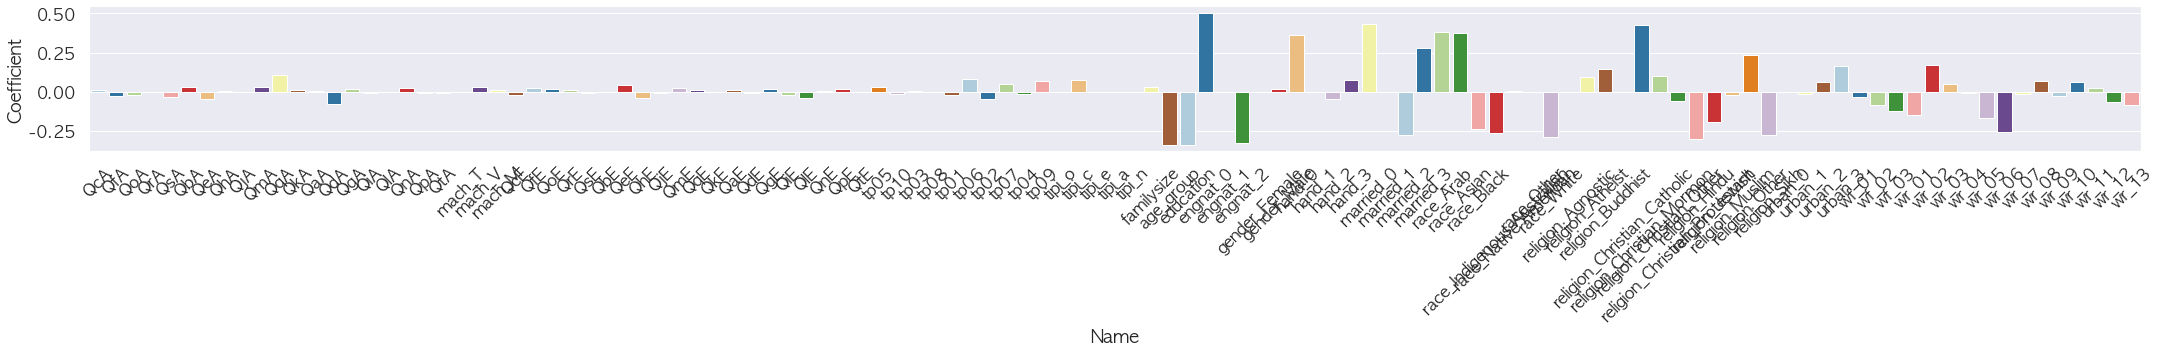

In [692]:
Results = pd.DataFrame({"Name":X_train.columns,
                        "Coefficient":model_embedded.coef_[0]})
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
g1 = sns.barplot(data=Results, x='Name', y='Coefficient', ax=ax, palette="Paired")
g1.set_xticklabels(g1.get_xticklabels(),rotation = 45)
plt.tight_layout()
plt.show()

In [693]:
y_pred_embedded=model_embedded.predict(X_test_embedded)

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

metric_embedded=confusion_matrix(y_test_embedded,y_pred_embedded)

accuracy_wrapper_basic=(metric_embedded[0][0]+metric_embedded[1][1])/sum(sum(metric_embedded))*100
print('Accuracy using filter : ',accuracy_score(y_test_embedded, y_pred_embedded)*100,
      '\n',
      'AUC using filter : ',roc_auc_score(y_test_embedded, y_pred_embedded)*100)

Accuracy using filter :  66.22378390249258 
 AUC using filter :  65.20683168827478


* 어떤 방법으로 해도 드라마틱한 변화가 관찰되지 않는다.

### DL method

In [697]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [698]:
x_train_all = pd.concat([x_train_num, x_train_cat], axis = 1)

In [741]:
y_all = pd.get_dummies(df_label, columns = ['voted'], prefix = ['voted'])

In [742]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x_train_all, y_all, 
                                                                              test_size=0.2, shuffle=True, 
                                                                              stratify=y_all, 
                                                                              random_state=22)

#### Model Specification

In [743]:
dl_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    tf.keras.layers.Dropout(0.20),

    #     tf.keras.layers.Dense(200, activation = 'relu',
    #                           kernel_initializer='he_normal',
    #                           kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    tf.keras.layers.Dense(64, activation='relu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
])

dl_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999),
                 loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "ckp_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard('logs')

In [744]:
dl_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 256)               29184     
                                                                 
 dense_65 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_11 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_66 (Dense)            (None, 128)               16512     
                                                                 
 dense_67 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                      

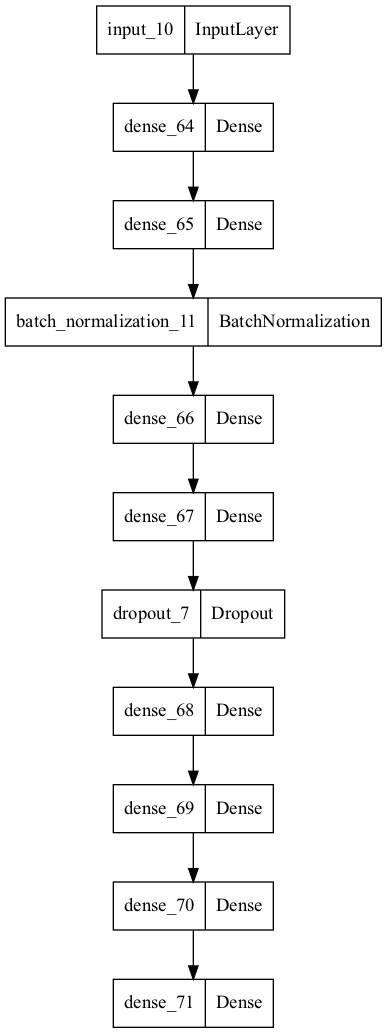

In [745]:
plot_model(dl_model)

#### Model Fitting

In [746]:
history = dl_model.fit(X_train, y_train, epochs=500, 
                    validation_split=0.2, batch_size=32,
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])


Epoch 1/500


2022-01-29 18:10:29.242111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


911/911 [==============================] - ETA: 0s - loss: 11.2272 - accuracy: 0.6013

2022-01-29 18:10:40.498612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


911/911 [==============================] - 13s 14ms/step - loss: 11.2272 - accuracy: 0.6013 - val_loss: 8.1133 - val_accuracy: 0.6472
Epoch 2/500
911/911 [==============================] - 12s 14ms/step - loss: 5.9464 - accuracy: 0.6598 - val_loss: 4.1810 - val_accuracy: 0.6707
Epoch 3/500
911/911 [==============================] - 12s 13ms/step - loss: 3.0608 - accuracy: 0.6738 - val_loss: 2.1860 - val_accuracy: 0.6777
Epoch 4/500
911/911 [==============================] - 13s 14ms/step - loss: 1.6652 - accuracy: 0.6810 - val_loss: 1.2810 - val_accuracy: 0.6824
Epoch 5/500
911/911 [==============================] - 13s 14ms/step - loss: 1.0617 - accuracy: 0.6829 - val_loss: 0.9101 - val_accuracy: 0.6800
Epoch 6/500
911/911 [==============================] - 13s 14ms/step - loss: 0.8208 - accuracy: 0.6829 - val_loss: 0.7625 - val_accuracy: 0.6848
Epoch 7/500
911/911 [==============================] - 13s 14ms/step - loss: 0.7228 - accuracy: 0.6832 - val_loss: 0.7021 - val_accuracy: 0.6

#### Model Assessment

In [749]:
def plot_loss(history):
    df = pd.DataFrame(history.history).filter(['loss','val_loss'])
    plt.subplots(figsize=[12,5])
    g1=sns.lineplot(x=df.index.values, y=df.loss)
    g1=sns.lineplot(x=df.index.values, y=df.val_loss)    
    g1.set_ylabel('Loss')
    g1.set_xlabel('Index')
    g1.set_title('Loss of Train/Validation')
    g1.legend(['Train Loss', 'Validation Loss'], 
          bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()

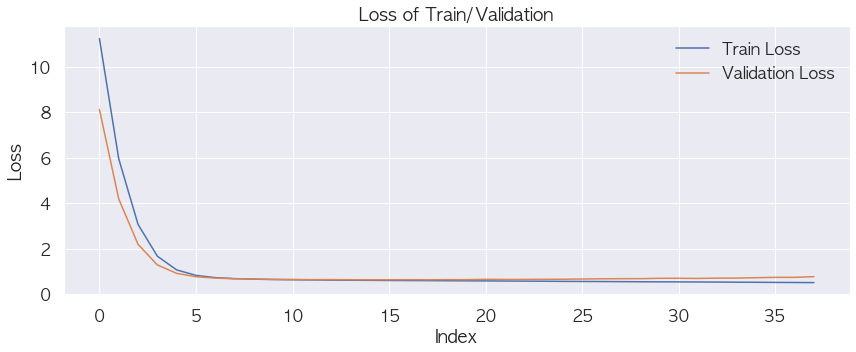

In [750]:
plot_loss(history)


In [770]:
dl_model.evaluate(X_test,  y_test)
y_pred = dl_model.predict(X_test)

predicted = pd.concat([pd.DataFrame(np.argmax(np.array(y_test), 1), columns = ['Actual']), 
                       pd.DataFrame(np.argmax(np.array(y_pred), 1), columns = ['Predicted'])], 
                      axis=1, ignore_index=False)
#predicted.columns = ['Actual Price', 'Predicted Price']


285/285 [==============================] - 2s 7ms/step - loss: 0.6254 - accuracy: 0.6827


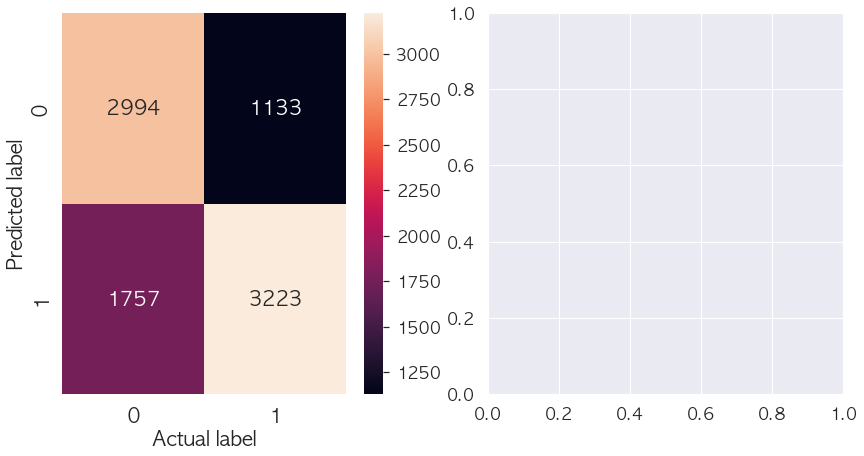

In [773]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 7))
sns.heatmap(confusion_matrix(predicted.Actual, predicted.Predicted),
      annot=True,  annot_kws={"size": 20}, fmt='2.0f', cbar = True, ax = axes[0])
axes[0].set_ylabel('Predicted label', fontsize=20);
axes[0].set_xlabel('Actual label', fontsize=20);
axes[0].tick_params(labelsize=20) 
# axes[0].set_xticklabels(['0','part 2'])
# axes[0].set_yticklabels(['p1','p1'])

In [ ]:
accuracy_score(predicted.Actual, predicted.Predicted)